In [33]:
import pandas as pd
import numpy as np
train = pd.read_csv('/SharedHDD/Code/ML/Recidivism Project/NIJ_s_Recidivism_Challenge_Training_Dataset.csv')
train = train[(train['Recidivism_Arrest_Year1']==False) & (train['Recidivism_Arrest_Year2']==False)]
test = pd.read_csv('/SharedHDD/Code/ML/Recidivism Project/NIJ_s_Recidivism_Challenge_Test_Dataset3.csv')

In [35]:
train  = pd.concat([train[test.columns], train['Recidivism_Arrest_Year3']], axis =1)
train = pd.concat([train,test]).reset_index(drop=True)


for i in train.columns:
    if train[i].dtypes == 'object':
        train[i] = train[i].astype(str).str.replace(' or more', '').replace('nan', np.nan)


int_variables = ['Prior_Arrest_Episodes_Felony', 'Prior_Arrest_Episodes_Misd', 'Prior_Arrest_Episodes_Violent', 'Prior_Arrest_Episodes_Property',\
'Prior_Arrest_Episodes_Drug', 'Prior_Arrest_Episodes_PPViolationCharges', 'Prior_Conviction_Episodes_Felony',\
'Prior_Conviction_Episodes_Misd', 'Prior_Conviction_Episodes_Prop', 'Prior_Conviction_Episodes_Drug', 'Delinquency_Reports',\
                'Program_Attendances', 'Program_UnexcusedAbsences','Residence_Changes']
for i in int_variables:
    train[i] = train[i].astype('int')
    
bool_variables = [i for i in train.columns if train[i].dtypes == 'bool']


from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
nan_variables = ['Gang_Affiliated', 'Supervision_Risk_Score_First', 'Supervision_Level_First', 'Prison_Offense', \
                 'Recidivism_Arrest_Year3', 'Avg_Days_per_DrugTest', 'DrugTests_THC_Positive','DrugTests_Cocaine_Positive', \
                 'DrugTests_Meth_Positive', 'DrugTests_Other_Positive', 'Percent_Days_Employed', 'Jobs_Per_Year']
cat_var = ['Gender', 'Race', 'Age_at_Release','Residence_PUMA', 'Education_Level', 'Dependents', 'Prison_Years']


for i in cat_var + bool_variables:
    train[i] = labelencoder.fit_transform(train[i])

for i in nan_variables:
    train[nan_variables] = train[nan_variables].replace('nan', np.nan)

original = train[nan_variables]
mask = train[nan_variables].isnull()

for i in nan_variables:
    if train[i].dtypes == 'object':
        train[i] = labelencoder.fit_transform(train[i].astype('str'))

train[nan_variables] = train[nan_variables].where(~mask, original)

train[nan_variables] = train[nan_variables].astype('float')

#feature_engineering()

for i in cat_var:
     train[i] = train[i].astype('category')
train['Recidivism_Arrest_Year3'] = train['Recidivism_Arrest_Year3'].astype('float')

In [36]:
train['Recidivism_Arrest_Year3'].value_counts()

0.0    7607
1.0    1791
Name: Recidivism_Arrest_Year3, dtype: int64

In [37]:
train_df = train[train['Recidivism_Arrest_Year3'].notnull()]
test_df = train[train['Recidivism_Arrest_Year3'].isnull()]
feats = [f for f in train_df.columns if f not in ['Recidivism_Arrest_Year3','ID']]




X = train_df[feats]
y  = train_df['Recidivism_Arrest_Year3']

In [38]:
# Libraries
import numpy as np
import pandas as pd

from lightgbm import LGBMClassifier

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances

from IPython.display import display
from sklearn.model_selection import train_test_split

In [39]:
def objective(trial, data = X, target = y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 11, 333),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.02, 0.05, 0.005, 0.1]),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.5),
        #'n_estimators': trial.suggest_int('n_estimators', 50, 3000),
        'random_state': 42,
        'boosting_type': 'gbdt',
        'metric': 'AUC'
    }
    
    model = LGBMClassifier(**params, n_estimators = 4000)  
    model.fit(X_train, y_train, eval_set = [(X_val,y_val)], early_stopping_rounds = 400, verbose = 200)
    y_pred = model.predict_proba(X_val)[:,1]
    roc_auc = roc_auc_score(y_val, y_pred)

    return roc_auc

In [40]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

In [41]:
%%time
study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 500)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_value)

[I 2021-06-29 22:10:49,142] A new study created in memory with name: no-name-4e690539-281c-438a-84c5-4c2acd50bd88
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675643


[I 2021-06-29 22:10:49,926] Trial 0 finished with value: 0.6763944787994726 and parameters: {'reg_alpha': 8.831873540494877, 'reg_lambda': 3.4627274240465904, 'num_leaves': 30, 'min_child_samples': 79, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.2232557718821612}. Best is trial 0 with value: 0.6763944787994726.


[400]	valid_0's auc: 0.671325
Early stopping, best iteration is:
[125]	valid_0's auc: 0.676394


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.674833
[400]	valid_0's auc: 0.676593
[600]	valid_0's auc: 0.675041


[I 2021-06-29 22:10:50,629] Trial 1 finished with value: 0.677532419455138 and parameters: {'reg_alpha': 9.234998614101414, 'reg_lambda': 8.766390618133194, 'num_leaves': 84, 'min_child_samples': 49, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.11571439248779854}. Best is trial 1 with value: 0.677532419455138.


Early stopping, best iteration is:
[304]	valid_0's auc: 0.677532
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668659
[400]	valid_0's auc: 0.672155
[600]	valid_0's auc: 0.673314
[800]	valid_0's auc: 0.674894
[1000]	valid_0's auc: 0.675692
[1200]	valid_0's auc: 0.675767
[1400]	valid_0's auc: 0.674792


[I 2021-06-29 22:10:55,462] Trial 2 finished with value: 0.6760935810299458 and parameters: {'reg_alpha': 4.87958862540716, 'reg_lambda': 4.294738077332541, 'num_leaves': 93, 'min_child_samples': 35, 'max_depth': 20, 'learning_rate': 0.005, 'colsample_bytree': 0.3576613986617355}. Best is trial 1 with value: 0.677532419455138.


Early stopping, best iteration is:
[1171]	valid_0's auc: 0.676094


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.661253
[400]	valid_0's auc: 0.669514
[600]	valid_0's auc: 0.672031
[800]	valid_0's auc: 0.672499
[1000]	valid_0's auc: 0.671728
Early stopping, best iteration is:
[646]	valid_0's auc: 0.672888


[I 2021-06-29 22:10:57,895] Trial 3 finished with value: 0.6728876520673501 and parameters: {'reg_alpha': 2.429035726605277, 'reg_lambda': 8.397928189754758, 'num_leaves': 258, 'min_child_samples': 60, 'max_depth': 11, 'learning_rate': 0.01, 'colsample_bytree': 0.1668489844963903}. Best is trial 1 with value: 0.677532419455138.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675734
[400]	valid_0's auc: 0.671102


[I 2021-06-29 22:10:59,112] Trial 4 finished with value: 0.6762905322972724 and parameters: {'reg_alpha': 5.776217304240815, 'reg_lambda': 8.766874358183212, 'num_leaves': 151, 'min_child_samples': 22, 'max_depth': 20, 'learning_rate': 0.05, 'colsample_bytree': 0.22489487639590583}. Best is trial 1 with value: 0.677532419455138.


Early stopping, best iteration is:
[145]	valid_0's auc: 0.676291
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.67297
[400]	valid_0's auc: 0.675765
[600]	valid_0's auc: 0.676666
[800]	valid_0's auc: 0.675711
Early stopping, best iteration is:
[510]	valid_0's auc: 0.677408


[I 2021-06-29 22:11:00,742] Trial 5 finished with value: 0.6774084131016359 and parameters: {'reg_alpha': 4.454184310686855, 'reg_lambda': 8.934190498884153, 'num_leaves': 164, 'min_child_samples': 71, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.32315556731471595}. Best is trial 1 with value: 0.677532419455138.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.681032
[400]	valid_0's auc: 0.677718


[I 2021-06-29 22:11:01,829] Trial 6 finished with value: 0.6814550321960614 and parameters: {'reg_alpha': 5.376167629991603, 'reg_lambda': 3.0639986483547292, 'num_leaves': 288, 'min_child_samples': 47, 'max_depth': 13, 'learning_rate': 0.05, 'colsample_bytree': 0.1480984734076356}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.673849
Early stopping, best iteration is:
[230]	valid_0's auc: 0.681455
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668066
[400]	valid_0's auc: 0.666676


[I 2021-06-29 22:11:08,168] Trial 7 finished with value: 0.6686367872142156 and parameters: {'reg_alpha': 1.880539419831379, 'reg_lambda': 3.697103432778933, 'num_leaves': 294, 'min_child_samples': 7, 'max_depth': 18, 'learning_rate': 0.005, 'colsample_bytree': 0.4903411591962864}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.668206
Early stopping, best iteration is:
[210]	valid_0's auc: 0.668637


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671626
[400]	valid_0's auc: 0.674027
[600]	valid_0's auc: 0.675244
[800]	valid_0's auc: 0.67427


[I 2021-06-29 22:11:10,167] Trial 8 finished with value: 0.6755738485189448 and parameters: {'reg_alpha': 9.969113541691721, 'reg_lambda': 7.43020687818656, 'num_leaves': 174, 'min_child_samples': 34, 'max_depth': 19, 'learning_rate': 0.01, 'colsample_bytree': 0.3400787863125612}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[517]	valid_0's auc: 0.675574
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.660637
[400]	valid_0's auc: 0.66542
[600]	valid_0's auc: 0.669157
[800]	valid_0's auc: 0.671469
[1000]	valid_0's auc: 0.67373
[1200]	valid_0's auc: 0.675331
[1400]	valid_0's auc: 0.676613
[1600]	valid_0's auc: 0.677666
[1800]	valid_0's auc: 0.678182
[2000]	valid_0's auc: 0.678855
[2200]	valid_0's auc: 0.679285
[2400]	valid_0's auc: 0.679093
[2600]	valid_0's auc: 0.679402
[2800]	valid_0's auc: 0.679584
[3000]	valid_0's auc: 0.679462
Early stopping, best iteration is:
[2725]	valid_0's auc: 0.679701


[I 2021-06-29 22:11:14,246] Trial 9 finished with value: 0.6797007070185772 and parameters: {'reg_alpha': 6.361556686529898, 'reg_lambda': 0.4099154901657373, 'num_leaves': 306, 'min_child_samples': 51, 'max_depth': 13, 'learning_rate': 0.005, 'colsample_bytree': 0.10686826131257901}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.654336


[I 2021-06-29 22:11:15,601] Trial 10 finished with value: 0.670651890458623 and parameters: {'reg_alpha': 0.34229113344027073, 'reg_lambda': 1.0189850768346371, 'num_leaves': 220, 'min_child_samples': 90, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.42729132494992617}. Best is trial 6 with value: 0.6814550321960614.


[400]	valid_0's auc: 0.646407
Early stopping, best iteration is:
[41]	valid_0's auc: 0.670652


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670971
[400]	valid_0's auc: 0.677556
[600]	valid_0's auc: 0.679447
[800]	valid_0's auc: 0.679201


[I 2021-06-29 22:11:16,962] Trial 11 finished with value: 0.6798757748117565 and parameters: {'reg_alpha': 7.094462954265058, 'reg_lambda': 0.1636693580041347, 'num_leaves': 329, 'min_child_samples': 50, 'max_depth': 14, 'learning_rate': 0.02, 'colsample_bytree': 0.10381160581547882}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678194
Early stopping, best iteration is:
[649]	valid_0's auc: 0.679876
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.66627
[400]	valid_0's auc: 0.672804
[600]	valid_0's auc: 0.673491
[800]	valid_0's auc: 0.67351


[I 2021-06-29 22:11:18,640] Trial 12 finished with value: 0.6738687611582922 and parameters: {'reg_alpha': 7.136012684330247, 'reg_lambda': 1.8938646354386461, 'num_leaves': 329, 'min_child_samples': 34, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.17371490272324042}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[583]	valid_0's auc: 0.673869
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.669879
[400]	valid_0's auc: 0.676478
[600]	valid_0's auc: 0.678927
[800]	valid_0's auc: 0.679132


[I 2021-06-29 22:11:19,961] Trial 13 finished with value: 0.6797481212125633 and parameters: {'reg_alpha': 7.7212831960541655, 'reg_lambda': 6.249175336237505, 'num_leaves': 256, 'min_child_samples': 63, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10010847489938017}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.679026
Early stopping, best iteration is:
[695]	valid_0's auc: 0.679748


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669791
[400]	valid_0's auc: 0.669567
[600]	valid_0's auc: 0.668668


[I 2021-06-29 22:11:21,908] Trial 14 finished with value: 0.6713868104654068 and parameters: {'reg_alpha': 3.672630851579127, 'reg_lambda': 2.4686971535389137, 'num_leaves': 331, 'min_child_samples': 45, 'max_depth': 9, 'learning_rate': 0.02, 'colsample_bytree': 0.24935633744098223}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[276]	valid_0's auc: 0.671387
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.672114
[400]	valid_0's auc: 0.676524
[600]	valid_0's auc: 0.676847


[I 2021-06-29 22:11:23,279] Trial 15 finished with value: 0.6779573235781668 and parameters: {'reg_alpha': 7.520102856978543, 'reg_lambda': 5.5270923004378485, 'num_leaves': 265, 'min_child_samples': 16, 'max_depth': 13, 'learning_rate': 0.02, 'colsample_bytree': 0.150261540772599}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.676571
Early stopping, best iteration is:
[490]	valid_0's auc: 0.677957


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds


[I 2021-06-29 22:11:23,936] Trial 16 finished with value: 0.6778460825845842 and parameters: {'reg_alpha': 6.267827604894331, 'reg_lambda': 0.04125203583161863, 'num_leaves': 219, 'min_child_samples': 79, 'max_depth': 17, 'learning_rate': 0.1, 'colsample_bytree': 0.26451652532037634}. Best is trial 6 with value: 0.6814550321960614.


[200]	valid_0's auc: 0.662987
[400]	valid_0's auc: 0.66089
Early stopping, best iteration is:
[43]	valid_0's auc: 0.677846


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.678895
[400]	valid_0's auc: 0.667823
Early stopping, best iteration is:
[191]	valid_0's auc: 0.679092


[I 2021-06-29 22:11:25,680] Trial 17 finished with value: 0.6790916169881409 and parameters: {'reg_alpha': 3.204403972227613, 'reg_lambda': 2.18847809935734, 'num_leaves': 294, 'min_child_samples': 40, 'max_depth': 12, 'learning_rate': 0.05, 'colsample_bytree': 0.19007312125172104}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667477
[400]	valid_0's auc: 0.67363
[600]	valid_0's auc: 0.675678
[800]	valid_0's auc: 0.674948
Early stopping, best iteration is:
[546]	valid_0's auc: 0.676083


[I 2021-06-29 22:11:26,899] Trial 18 finished with value: 0.676082639292872 and parameters: {'reg_alpha': 8.42016575077612, 'reg_lambda': 1.2657174904963562, 'num_leaves': 328, 'min_child_samples': 60, 'max_depth': 14, 'learning_rate': 0.02, 'colsample_bytree': 0.11740360450488244}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.679606
[400]	valid_0's auc: 0.675505


[I 2021-06-29 22:11:27,999] Trial 19 finished with value: 0.6798648330746828 and parameters: {'reg_alpha': 5.432868381286243, 'reg_lambda': 3.0154483510750065, 'num_leaves': 226, 'min_child_samples': 24, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.14248768353099953}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.670139
Early stopping, best iteration is:
[230]	valid_0's auc: 0.679865
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.678639
[400]	valid_0's auc: 0.672771


[I 2021-06-29 22:11:29,008] Trial 20 finished with value: 0.6808769437540007 and parameters: {'reg_alpha': 6.8463114430652094, 'reg_lambda': 5.007750708722567, 'num_leaves': 274, 'min_child_samples': 100, 'max_depth': 11, 'learning_rate': 0.05, 'colsample_bytree': 0.27541380050304426}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[147]	valid_0's auc: 0.680877
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.677746
[400]	valid_0's auc: 0.671938
Early stopping, best iteration is:
[146]	valid_0's auc: 0.680182


[I 2021-06-29 22:11:30,096] Trial 21 finished with value: 0.6801821434498202 and parameters: {'reg_alpha': 6.797782803876146, 'reg_lambda': 5.163614090127635, 'num_leaves': 280, 'min_child_samples': 56, 'max_depth': 11, 'learning_rate': 0.05, 'colsample_bytree': 0.27611096748848474}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.673541
[400]	valid_0's auc: 0.668267


[I 2021-06-29 22:11:31,193] Trial 22 finished with value: 0.6760571085730332 and parameters: {'reg_alpha': 6.480133933344355, 'reg_lambda': 5.063616842580522, 'num_leaves': 276, 'min_child_samples': 91, 'max_depth': 12, 'learning_rate': 0.05, 'colsample_bytree': 0.2897516136531796}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[133]	valid_0's auc: 0.676057
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.665351


[I 2021-06-29 22:11:32,470] Trial 23 finished with value: 0.6740474761971628 and parameters: {'reg_alpha': 4.335023557045583, 'reg_lambda': 6.099341531868749, 'num_leaves': 238, 'min_child_samples': 71, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.387536969025307}. Best is trial 6 with value: 0.6814550321960614.


[400]	valid_0's auc: 0.657097
Early stopping, best iteration is:
[65]	valid_0's auc: 0.674047


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.677066
[400]	valid_0's auc: 0.671266
Early stopping, best iteration is:
[178]	valid_0's auc: 0.678348


[I 2021-06-29 22:11:33,461] Trial 24 finished with value: 0.6783475788671289 and parameters: {'reg_alpha': 8.155049889958658, 'reg_lambda': 4.675646304622143, 'num_leaves': 182, 'min_child_samples': 82, 'max_depth': 11, 'learning_rate': 0.05, 'colsample_bytree': 0.2912823214449026}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.672778
[400]	valid_0's auc: 0.667355


[I 2021-06-29 22:11:34,627] Trial 25 finished with value: 0.6732852018476947 and parameters: {'reg_alpha': 5.393361006984008, 'reg_lambda': 7.124928968352629, 'num_leaves': 193, 'min_child_samples': 65, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.20921675758881544}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[167]	valid_0's auc: 0.673285
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670913


[I 2021-06-29 22:11:35,764] Trial 26 finished with value: 0.6774594745413133 and parameters: {'reg_alpha': 6.760530452055743, 'reg_lambda': 4.067518442929622, 'num_leaves': 302, 'min_child_samples': 43, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.3936274524675898}. Best is trial 6 with value: 0.6814550321960614.


[400]	valid_0's auc: 0.666547
Early stopping, best iteration is:
[76]	valid_0's auc: 0.677459
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.673393
[400]	valid_0's auc: 0.672326
[600]	valid_0's auc: 0.672492


[I 2021-06-29 22:11:36,672] Trial 27 finished with value: 0.6755319051934956 and parameters: {'reg_alpha': 9.582876414751372, 'reg_lambda': 5.821068185009317, 'num_leaves': 282, 'min_child_samples': 99, 'max_depth': 11, 'learning_rate': 0.05, 'colsample_bytree': 0.25725818385504207}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[234]	valid_0's auc: 0.675532
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670046


[I 2021-06-29 22:11:37,694] Trial 28 finished with value: 0.673808581604387 and parameters: {'reg_alpha': 5.98788927214325, 'reg_lambda': 7.168565410879298, 'num_leaves': 135, 'min_child_samples': 98, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.3090503072709227}. Best is trial 6 with value: 0.6814550321960614.


[400]	valid_0's auc: 0.665827
Early stopping, best iteration is:
[99]	valid_0's auc: 0.673809


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds


[I 2021-06-29 22:11:38,265] Trial 29 finished with value: 0.6724663951900125 and parameters: {'reg_alpha': 8.829400013880397, 'reg_lambda': 9.96085573508109, 'num_leaves': 244, 'min_child_samples': 55, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.4442120166980934}. Best is trial 6 with value: 0.6814550321960614.


[200]	valid_0's auc: 0.666348
[400]	valid_0's auc: 0.666405
Early stopping, best iteration is:
[50]	valid_0's auc: 0.672466


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675835
[400]	valid_0's auc: 0.669054


[I 2021-06-29 22:11:39,352] Trial 30 finished with value: 0.6769415656531579 and parameters: {'reg_alpha': 7.8751061079513685, 'reg_lambda': 3.267860837729966, 'num_leaves': 309, 'min_child_samples': 24, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.2300939221396892}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[185]	valid_0's auc: 0.676942
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.674901
[400]	valid_0's auc: 0.675185


[I 2021-06-29 22:11:40,870] Trial 31 finished with value: 0.6785354120202276 and parameters: {'reg_alpha': 6.8038189555165856, 'reg_lambda': 4.968591202609641, 'num_leaves': 319, 'min_child_samples': 56, 'max_depth': 14, 'learning_rate': 0.02, 'colsample_bytree': 0.27707596492273273}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.67272
Early stopping, best iteration is:
[269]	valid_0's auc: 0.678535


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.674232
[400]	valid_0's auc: 0.670688


[I 2021-06-29 22:11:41,906] Trial 32 finished with value: 0.6749592876199716 and parameters: {'reg_alpha': 7.2316063241495545, 'reg_lambda': 5.307658725903253, 'num_leaves': 278, 'min_child_samples': 48, 'max_depth': 12, 'learning_rate': 0.05, 'colsample_bytree': 0.21640607327719413}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[180]	valid_0's auc: 0.674959
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.672842
[400]	valid_0's auc: 0.671788


[I 2021-06-29 22:11:43,067] Trial 33 finished with value: 0.6752419491610423 and parameters: {'reg_alpha': 4.804332131827485, 'reg_lambda': 4.302188603117975, 'num_leaves': 331, 'min_child_samples': 40, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.13102102253605374}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.669319
Early stopping, best iteration is:
[271]	valid_0's auc: 0.675242
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.672636
[400]	valid_0's auc: 0.675138
[600]	valid_0's auc: 0.675822
[800]	valid_0's auc: 0.67379


[I 2021-06-29 22:11:44,931] Trial 34 finished with value: 0.6760005762648191 and parameters: {'reg_alpha': 5.479168401802198, 'reg_lambda': 6.55267027562988, 'num_leaves': 285, 'min_child_samples': 67, 'max_depth': 13, 'learning_rate': 0.02, 'colsample_bytree': 0.19293682337943485}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[584]	valid_0's auc: 0.676001
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.669076
[400]	valid_0's auc: 0.671664
[600]	valid_0's auc: 0.672357
[800]	valid_0's auc: 0.673975
[1000]	valid_0's auc: 0.674824
[1200]	valid_0's auc: 0.674575


[I 2021-06-29 22:11:48,546] Trial 35 finished with value: 0.674957463997126 and parameters: {'reg_alpha': 8.5830924625601, 'reg_lambda': 4.570770868048775, 'num_leaves': 60, 'min_child_samples': 31, 'max_depth': 15, 'learning_rate': 0.005, 'colsample_bytree': 0.3721427888302636}. Best is trial 6 with value: 0.6814550321960614.


[1400]	valid_0's auc: 0.673975
Early stopping, best iteration is:
[1030]	valid_0's auc: 0.674957


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.673872
[400]	valid_0's auc: 0.676387
[600]	valid_0's auc: 0.676376


[I 2021-06-29 22:11:49,904] Trial 36 finished with value: 0.6771986964743899 and parameters: {'reg_alpha': 7.219638060894297, 'reg_lambda': 3.6963685094323626, 'num_leaves': 15, 'min_child_samples': 53, 'max_depth': 11, 'learning_rate': 0.01, 'colsample_bytree': 0.3343078062020321}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.676012
Early stopping, best iteration is:
[451]	valid_0's auc: 0.677199
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.672399
[400]	valid_0's auc: 0.672041
Early stopping, best iteration is:
[165]	valid_0's auc: 0.673369


[I 2021-06-29 22:11:50,851] Trial 37 finished with value: 0.6733690884985931 and parameters: {'reg_alpha': 5.9377409512225805, 'reg_lambda': 2.8719608970235426, 'num_leaves': 263, 'min_child_samples': 76, 'max_depth': 16, 'learning_rate': 0.05, 'colsample_bytree': 0.16863580391841457}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.674494


[I 2021-06-29 22:11:51,813] Trial 38 finished with value: 0.6762558834632056 and parameters: {'reg_alpha': 9.13210211205277, 'reg_lambda': 7.905131324443898, 'num_leaves': 315, 'min_child_samples': 58, 'max_depth': 12, 'learning_rate': 0.05, 'colsample_bytree': 0.31473237453705566}. Best is trial 6 with value: 0.6814550321960614.


[400]	valid_0's auc: 0.669308
Early stopping, best iteration is:
[100]	valid_0's auc: 0.676256


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669158
[400]	valid_0's auc: 0.672674
[600]	valid_0's auc: 0.674069
[800]	valid_0's auc: 0.673949
[1000]	valid_0's auc: 0.672625


[I 2021-06-29 22:11:55,317] Trial 39 finished with value: 0.6744705566973461 and parameters: {'reg_alpha': 4.862495429548853, 'reg_lambda': 1.554252226575752, 'num_leaves': 237, 'min_child_samples': 5, 'max_depth': 9, 'learning_rate': 0.01, 'colsample_bytree': 0.24631389783786498}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[676]	valid_0's auc: 0.674471
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670887
[400]	valid_0's auc: 0.673455
[600]	valid_0's auc: 0.674171
[800]	valid_0's auc: 0.674447
[1000]	valid_0's auc: 0.67429
Early stopping, best iteration is:
[637]	valid_0's auc: 0.674917


[I 2021-06-29 22:11:59,310] Trial 40 finished with value: 0.6749173442945223 and parameters: {'reg_alpha': 4.349077648259774, 'reg_lambda': 0.4578458551342157, 'num_leaves': 210, 'min_child_samples': 29, 'max_depth': 13, 'learning_rate': 0.005, 'colsample_bytree': 0.3517208167241048}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.677279
[400]	valid_0's auc: 0.67282


[I 2021-06-29 22:12:00,385] Trial 41 finished with value: 0.6775397139465203 and parameters: {'reg_alpha': 5.514762391329665, 'reg_lambda': 3.1008573434702758, 'num_leaves': 252, 'min_child_samples': 10, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.1482092123841488}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.669167
Early stopping, best iteration is:
[232]	valid_0's auc: 0.67754
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671414
[400]	valid_0's auc: 0.670728


[I 2021-06-29 22:12:01,627] Trial 42 finished with value: 0.6730663671062205 and parameters: {'reg_alpha': 3.864871351707828, 'reg_lambda': 2.718916830367946, 'num_leaves': 272, 'min_child_samples': 21, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 0.13391918573044898}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.668123
Early stopping, best iteration is:
[337]	valid_0's auc: 0.673066


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675346
[400]	valid_0's auc: 0.6763


[I 2021-06-29 22:12:02,542] Trial 43 finished with value: 0.6773372918106568 and parameters: {'reg_alpha': 5.152601989695102, 'reg_lambda': 3.6396383949361013, 'num_leaves': 227, 'min_child_samples': 48, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.10322112762329536}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.673973
Early stopping, best iteration is:
[210]	valid_0's auc: 0.677337
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.676467
[400]	valid_0's auc: 0.672293


[I 2021-06-29 22:12:03,534] Trial 44 finished with value: 0.6768339719052665 and parameters: {'reg_alpha': 6.6684052956971005, 'reg_lambda': 3.9670990720302775, 'num_leaves': 290, 'min_child_samples': 12, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.18644414216896854}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.668743
Early stopping, best iteration is:
[204]	valid_0's auc: 0.676834
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.673192
[400]	valid_0's auc: 0.676991
[600]	valid_0's auc: 0.676075


[I 2021-06-29 22:12:05,115] Trial 45 finished with value: 0.6779536763324756 and parameters: {'reg_alpha': 5.867601838975198, 'reg_lambda': 5.7390591530420725, 'num_leaves': 305, 'min_child_samples': 27, 'max_depth': 11, 'learning_rate': 0.02, 'colsample_bytree': 0.15031287884281214}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.675505
Early stopping, best iteration is:
[474]	valid_0's auc: 0.677954


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671237
[400]	valid_0's auc: 0.67328


[I 2021-06-29 22:12:05,892] Trial 46 finished with value: 0.6745890921823113 and parameters: {'reg_alpha': 6.242839246186873, 'reg_lambda': 6.605250018902006, 'num_leaves': 209, 'min_child_samples': 38, 'max_depth': 14, 'learning_rate': 0.1, 'colsample_bytree': 0.12251372997774224}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.672414
Early stopping, best iteration is:
[254]	valid_0's auc: 0.67477
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.672678
[400]	valid_0's auc: 0.668298
Early stopping, best iteration is:
[134]	valid_0's auc: 0.674775


[I 2021-06-29 22:12:06,975] Trial 47 finished with value: 0.6747751017125642 and parameters: {'reg_alpha': 7.061063278261102, 'reg_lambda': 0.6499050343565127, 'num_leaves': 143, 'min_child_samples': 44, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.23139817783787617}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669622
[400]	valid_0's auc: 0.677067
[600]	valid_0's auc: 0.679471
[800]	valid_0's auc: 0.678572


[I 2021-06-29 22:12:08,362] Trial 48 finished with value: 0.6800891386846939 and parameters: {'reg_alpha': 7.520005851901253, 'reg_lambda': 1.8722035412595899, 'num_leaves': 252, 'min_child_samples': 16, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10053897603086745}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678116
Early stopping, best iteration is:
[649]	valid_0's auc: 0.680089
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.673812
[400]	valid_0's auc: 0.67104


[I 2021-06-29 22:12:09,920] Trial 49 finished with value: 0.6740839486540752 and parameters: {'reg_alpha': 7.628120325482195, 'reg_lambda': 2.158461712333163, 'num_leaves': 254, 'min_child_samples': 87, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.49769608506962215}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[196]	valid_0's auc: 0.674084
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.674336
[400]	valid_0's auc: 0.675196


[I 2021-06-29 22:12:11,467] Trial 50 finished with value: 0.6777476069509208 and parameters: {'reg_alpha': 8.11636352693585, 'reg_lambda': 1.022367657243831, 'num_leaves': 294, 'min_child_samples': 18, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.27404288741798366}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.672538
Early stopping, best iteration is:
[260]	valid_0's auc: 0.677748


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669828
[400]	valid_0's auc: 0.677299
[600]	valid_0's auc: 0.679391
[800]	valid_0's auc: 0.679232


[I 2021-06-29 22:12:12,890] Trial 51 finished with value: 0.6800544898506271 and parameters: {'reg_alpha': 7.367810532558499, 'reg_lambda': 2.3568379694187716, 'num_leaves': 267, 'min_child_samples': 14, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10244742908187401}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678273
Early stopping, best iteration is:
[649]	valid_0's auc: 0.680054


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669899
[400]	valid_0's auc: 0.677449
[600]	valid_0's auc: 0.679513
[800]	valid_0's auc: 0.679376
[1000]	valid_0's auc: 0.679024
Early stopping, best iteration is:
[748]	valid_0's auc: 0.680036


[I 2021-06-29 22:12:14,456] Trial 52 finished with value: 0.6800362536221709 and parameters: {'reg_alpha': 7.558697313213572, 'reg_lambda': 1.6665827656356333, 'num_leaves': 270, 'min_child_samples': 12, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.10011625137487078}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667561
[400]	valid_0's auc: 0.674206
[600]	valid_0's auc: 0.676725
[800]	valid_0's auc: 0.675402
Early stopping, best iteration is:
[583]	valid_0's auc: 0.676847


[I 2021-06-29 22:12:15,917] Trial 53 finished with value: 0.6768467372651858 and parameters: {'reg_alpha': 7.519812685988954, 'reg_lambda': 1.669418712885399, 'num_leaves': 272, 'min_child_samples': 14, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.11788067839008001}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669687
[400]	valid_0's auc: 0.676715
[600]	valid_0's auc: 0.67905
[800]	valid_0's auc: 0.678798


[I 2021-06-29 22:12:17,256] Trial 54 finished with value: 0.6796441747103631 and parameters: {'reg_alpha': 8.580024320165752, 'reg_lambda': 2.1131647159878337, 'num_leaves': 263, 'min_child_samples': 8, 'max_depth': 20, 'learning_rate': 0.02, 'colsample_bytree': 0.1003698568007983}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678539
Early stopping, best iteration is:
[704]	valid_0's auc: 0.679644


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.666447
[400]	valid_0's auc: 0.673251
[600]	valid_0's auc: 0.673933
[800]	valid_0's auc: 0.674044


[I 2021-06-29 22:12:18,831] Trial 55 finished with value: 0.6744596149602723 and parameters: {'reg_alpha': 7.889801682263568, 'reg_lambda': 2.42006739360726, 'num_leaves': 245, 'min_child_samples': 17, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.16444368604697976}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[576]	valid_0's auc: 0.67446
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670477
[400]	valid_0's auc: 0.677434
[600]	valid_0's auc: 0.679033
[800]	valid_0's auc: 0.679101


[I 2021-06-29 22:12:20,435] Trial 56 finished with value: 0.6796806471672755 and parameters: {'reg_alpha': 6.335916195601083, 'reg_lambda': 1.309719364311849, 'num_leaves': 297, 'min_child_samples': 5, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10207155419967998}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677552
Early stopping, best iteration is:
[686]	valid_0's auc: 0.679681


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667904
[400]	valid_0's auc: 0.674201
[600]	valid_0's auc: 0.676285
[800]	valid_0's auc: 0.675222


[I 2021-06-29 22:12:21,881] Trial 57 finished with value: 0.6767099655517644 and parameters: {'reg_alpha': 8.201356772544454, 'reg_lambda': 1.7311920850654496, 'num_leaves': 269, 'min_child_samples': 11, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.11461083646424342}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.675328
Early stopping, best iteration is:
[628]	valid_0's auc: 0.67671
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.66734
[400]	valid_0's auc: 0.673194
[600]	valid_0's auc: 0.675477
[800]	valid_0's auc: 0.674461


[I 2021-06-29 22:12:23,397] Trial 58 finished with value: 0.6757525635578152 and parameters: {'reg_alpha': 7.400279165745119, 'reg_lambda': 2.5104035618916227, 'num_leaves': 234, 'min_child_samples': 20, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.13136138227775002}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.674064
Early stopping, best iteration is:
[629]	valid_0's auc: 0.675753
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671471
[400]	valid_0's auc: 0.673116
[600]	valid_0's auc: 0.670652


[I 2021-06-29 22:12:26,149] Trial 59 finished with value: 0.6742225439903421 and parameters: {'reg_alpha': 6.9006332279741915, 'reg_lambda': 0.8611067786238253, 'num_leaves': 319, 'min_child_samples': 15, 'max_depth': 19, 'learning_rate': 0.01, 'colsample_bytree': 0.4693766050977437}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[339]	valid_0's auc: 0.674223
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.657845
[400]	valid_0's auc: 0.66335
[600]	valid_0's auc: 0.667185
[800]	valid_0's auc: 0.668367
[1000]	valid_0's auc: 0.668361
[1200]	valid_0's auc: 0.669656
[1400]	valid_0's auc: 0.669848
[1600]	valid_0's auc: 0.670247
[1800]	valid_0's auc: 0.670145
[2000]	valid_0's auc: 0.669463
Early stopping, best iteration is:
[1777]	valid_0's auc: 0.67053


[I 2021-06-29 22:12:35,095] Trial 60 finished with value: 0.6705297077279666 and parameters: {'reg_alpha': 0.6129265059353957, 'reg_lambda': 3.4284264435818184, 'num_leaves': 286, 'min_child_samples': 33, 'max_depth': 17, 'learning_rate': 0.005, 'colsample_bytree': 0.16258893973356017}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670801
[400]	valid_0's auc: 0.67797
[600]	valid_0's auc: 0.679221
[800]	valid_0's auc: 0.679276


[I 2021-06-29 22:12:36,499] Trial 61 finished with value: 0.679850244091918 and parameters: {'reg_alpha': 6.580274349786345, 'reg_lambda': 0.19357625054909722, 'num_leaves': 257, 'min_child_samples': 51, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.11049682202424965}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678227
Early stopping, best iteration is:
[658]	valid_0's auc: 0.67985


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.674675
[400]	valid_0's auc: 0.67565
[600]	valid_0's auc: 0.673643


[I 2021-06-29 22:12:38,032] Trial 62 finished with value: 0.6780667409489038 and parameters: {'reg_alpha': 7.847048706969189, 'reg_lambda': 4.6819599378437875, 'num_leaves': 115, 'min_child_samples': 61, 'max_depth': 13, 'learning_rate': 0.02, 'colsample_bytree': 0.29973742648486457}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[305]	valid_0's auc: 0.678067
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.67297
[400]	valid_0's auc: 0.677968
[600]	valid_0's auc: 0.677567


[I 2021-06-29 22:12:39,609] Trial 63 finished with value: 0.679153620164892 and parameters: {'reg_alpha': 7.021497084774326, 'reg_lambda': 2.0032633003710956, 'num_leaves': 280, 'min_child_samples': 25, 'max_depth': 12, 'learning_rate': 0.02, 'colsample_bytree': 0.1422222409604223}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.676272
Early stopping, best iteration is:
[448]	valid_0's auc: 0.679154
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670986
[400]	valid_0's auc: 0.674301
[600]	valid_0's auc: 0.673628


[I 2021-06-29 22:12:41,098] Trial 64 finished with value: 0.6751671806243721 and parameters: {'reg_alpha': 7.394445191971217, 'reg_lambda': 1.3763821384040837, 'num_leaves': 322, 'min_child_samples': 36, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.20171978566323}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[352]	valid_0's auc: 0.675167
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671
[400]	valid_0's auc: 0.671545


[I 2021-06-29 22:12:41,729] Trial 65 finished with value: 0.6762996504115004 and parameters: {'reg_alpha': 6.114472647339074, 'reg_lambda': 5.259741276471443, 'num_leaves': 306, 'min_child_samples': 95, 'max_depth': 20, 'learning_rate': 0.1, 'colsample_bytree': 0.12281177941654033}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[120]	valid_0's auc: 0.6763
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.669372
[400]	valid_0's auc: 0.673342
[600]	valid_0's auc: 0.673035


[I 2021-06-29 22:12:43,183] Trial 66 finished with value: 0.6734930948520951 and parameters: {'reg_alpha': 9.034957712877313, 'reg_lambda': 4.343054977049576, 'num_leaves': 333, 'min_child_samples': 70, 'max_depth': 14, 'learning_rate': 0.02, 'colsample_bytree': 0.2460809126736789}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[393]	valid_0's auc: 0.673493
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.67551
[400]	valid_0's auc: 0.676509
[600]	valid_0's auc: 0.674077
Early stopping, best iteration is:
[297]	valid_0's auc: 0.6789


[I 2021-06-29 22:12:44,781] Trial 67 finished with value: 0.6789001365893511 and parameters: {'reg_alpha': 6.579967987483641, 'reg_lambda': 2.6104517778275245, 'num_leaves': 248, 'min_child_samples': 46, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.2672218581646187}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.66802
[400]	valid_0's auc: 0.675877
[600]	valid_0's auc: 0.678171
[800]	valid_0's auc: 0.678911
[1000]	valid_0's auc: 0.678639
[1200]	valid_0's auc: 0.678627


[I 2021-06-29 22:12:46,390] Trial 68 finished with value: 0.6791590910334289 and parameters: {'reg_alpha': 9.625327107863887, 'reg_lambda': 4.924817855832312, 'num_leaves': 299, 'min_child_samples': 8, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10057152337280957}. Best is trial 6 with value: 0.6814550321960614.


[1400]	valid_0's auc: 0.678236
Early stopping, best iteration is:
[1072]	valid_0's auc: 0.679181


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.674244
[400]	valid_0's auc: 0.675461
[600]	valid_0's auc: 0.675877


[I 2021-06-29 22:12:47,494] Trial 69 finished with value: 0.6759093951225383 and parameters: {'reg_alpha': 8.209225082340451, 'reg_lambda': 3.9755181902114622, 'num_leaves': 262, 'min_child_samples': 76, 'max_depth': 11, 'learning_rate': 0.05, 'colsample_bytree': 0.17684346345090934}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.674385
Early stopping, best iteration is:
[595]	valid_0's auc: 0.675915


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.673801
[400]	valid_0's auc: 0.667875
Early stopping, best iteration is:
[189]	valid_0's auc: 0.674243


[I 2021-06-29 22:12:48,631] Trial 70 finished with value: 0.6742426038416439 and parameters: {'reg_alpha': 6.9807520003326555, 'reg_lambda': 0.880150852203192, 'num_leaves': 312, 'min_child_samples': 41, 'max_depth': 13, 'learning_rate': 0.05, 'colsample_bytree': 0.28688433581757933}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.676954
[400]	valid_0's auc: 0.671928


[I 2021-06-29 22:12:49,987] Trial 71 finished with value: 0.6774375910671658 and parameters: {'reg_alpha': 3.930443701359348, 'reg_lambda': 3.0823956634662597, 'num_leaves': 228, 'min_child_samples': 23, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.1405882943769305}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.665633
Early stopping, best iteration is:
[242]	valid_0's auc: 0.677438
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670783
[400]	valid_0's auc: 0.669696


[I 2021-06-29 22:12:51,135] Trial 72 finished with value: 0.6717734185086776 and parameters: {'reg_alpha': 5.567663165107902, 'reg_lambda': 2.3947147928560333, 'num_leaves': 211, 'min_child_samples': 19, 'max_depth': 16, 'learning_rate': 0.05, 'colsample_bytree': 0.1567519265841022}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.669266
Early stopping, best iteration is:
[223]	valid_0's auc: 0.671773
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671974
[400]	valid_0's auc: 0.672567


[I 2021-06-29 22:12:52,299] Trial 73 finished with value: 0.6747240402728869 and parameters: {'reg_alpha': 4.993306791629454, 'reg_lambda': 3.1471414156521766, 'num_leaves': 196, 'min_child_samples': 14, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.12936126632714437}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.672127
Early stopping, best iteration is:
[337]	valid_0's auc: 0.674724


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675855
[400]	valid_0's auc: 0.675995
Early stopping, best iteration is:
[160]	valid_0's auc: 0.677284


[I 2021-06-29 22:12:53,119] Trial 74 finished with value: 0.677284406748134 and parameters: {'reg_alpha': 5.235030280766347, 'reg_lambda': 2.8528243224864713, 'num_leaves': 276, 'min_child_samples': 53, 'max_depth': 12, 'learning_rate': 0.05, 'colsample_bytree': 0.11113556202203956}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.677593
[400]	valid_0's auc: 0.669975


[I 2021-06-29 22:12:54,271] Trial 75 finished with value: 0.6780685645717495 and parameters: {'reg_alpha': 5.69579271561977, 'reg_lambda': 1.7730510239362192, 'num_leaves': 287, 'min_child_samples': 28, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.17758541907769965}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.6655
Early stopping, best iteration is:
[204]	valid_0's auc: 0.678069
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.674237
[400]	valid_0's auc: 0.675213
[600]	valid_0's auc: 0.67412


[I 2021-06-29 22:12:57,632] Trial 76 finished with value: 0.676720907288838 and parameters: {'reg_alpha': 4.51517061081375, 'reg_lambda': 5.5087826866443255, 'num_leaves': 220, 'min_child_samples': 11, 'max_depth': 17, 'learning_rate': 0.01, 'colsample_bytree': 0.41019505338821327}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[325]	valid_0's auc: 0.676721
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.663625
[400]	valid_0's auc: 0.667577
[600]	valid_0's auc: 0.670814
[800]	valid_0's auc: 0.674259
[1000]	valid_0's auc: 0.675464
[1200]	valid_0's auc: 0.676385
[1400]	valid_0's auc: 0.677449
[1600]	valid_0's auc: 0.677731
[1800]	valid_0's auc: 0.677808
[2000]	valid_0's auc: 0.678169
[2200]	valid_0's auc: 0.677966
[2400]	valid_0's auc: 0.677983
Early stopping, best iteration is:
[2131]	valid_0's auc: 0.678229


[I 2021-06-29 22:13:01,372] Trial 77 finished with value: 0.6782290433821638 and parameters: {'reg_alpha': 7.208605275667157, 'reg_lambda': 3.4480864057401774, 'num_leaves': 249, 'min_child_samples': 57, 'max_depth': 9, 'learning_rate': 0.005, 'colsample_bytree': 0.1394784726162303}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670506
[400]	valid_0's auc: 0.668701


[I 2021-06-29 22:13:02,271] Trial 78 finished with value: 0.671762476771604 and parameters: {'reg_alpha': 3.1234776097577055, 'reg_lambda': 5.884434840578703, 'num_leaves': 167, 'min_child_samples': 22, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 0.12054036135205205}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.666235
Early stopping, best iteration is:
[272]	valid_0's auc: 0.671762
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.672328
[400]	valid_0's auc: 0.677275
[600]	valid_0's auc: 0.677753


[I 2021-06-29 22:13:03,705] Trial 79 finished with value: 0.6786174750482804 and parameters: {'reg_alpha': 7.696288491589567, 'reg_lambda': 3.8023089293903536, 'num_leaves': 238, 'min_child_samples': 5, 'max_depth': 13, 'learning_rate': 0.02, 'colsample_bytree': 0.15335727162486423}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.677217
Early stopping, best iteration is:
[475]	valid_0's auc: 0.678617


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.663842
[400]	valid_0's auc: 0.661278
Early stopping, best iteration is:
[74]	valid_0's auc: 0.670344


[I 2021-06-29 22:13:04,505] Trial 80 finished with value: 0.6703436981977137 and parameters: {'reg_alpha': 6.404251352157164, 'reg_lambda': 4.312801868929541, 'num_leaves': 267, 'min_child_samples': 31, 'max_depth': 14, 'learning_rate': 0.1, 'colsample_bytree': 0.33105920081083196}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.67079
[400]	valid_0's auc: 0.678058
[600]	valid_0's auc: 0.67963
[800]	valid_0's auc: 0.678979


[I 2021-06-29 22:13:05,867] Trial 81 finished with value: 0.6801164930273782 and parameters: {'reg_alpha': 6.617099701917742, 'reg_lambda': 0.20305878732712396, 'num_leaves': 257, 'min_child_samples': 49, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11035010865891834}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677686
Early stopping, best iteration is:
[652]	valid_0's auc: 0.680116
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670769
[400]	valid_0's auc: 0.678116
[600]	valid_0's auc: 0.679699
[800]	valid_0's auc: 0.679124


[I 2021-06-29 22:13:07,249] Trial 82 finished with value: 0.6802988553119399 and parameters: {'reg_alpha': 6.730580648484524, 'reg_lambda': 0.017931634410539132, 'num_leaves': 256, 'min_child_samples': 47, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.10017519164396223}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678167
Early stopping, best iteration is:
[659]	valid_0's auc: 0.680299
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670842
[400]	valid_0's auc: 0.677775
[600]	valid_0's auc: 0.679517
[800]	valid_0's auc: 0.679126


[I 2021-06-29 22:13:08,634] Trial 83 finished with value: 0.679892187417367 and parameters: {'reg_alpha': 7.330577895871416, 'reg_lambda': 0.3554230779427109, 'num_leaves': 280, 'min_child_samples': 50, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10138168493881941}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.67828
Early stopping, best iteration is:
[707]	valid_0's auc: 0.679892


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670597
[400]	valid_0's auc: 0.678023
[600]	valid_0's auc: 0.679411
[800]	valid_0's auc: 0.678643


[I 2021-06-29 22:13:10,030] Trial 84 finished with value: 0.6798247133720793 and parameters: {'reg_alpha': 6.845370016751915, 'reg_lambda': 0.035804181498804696, 'num_leaves': 258, 'min_child_samples': 48, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10135102279606008}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677469
Early stopping, best iteration is:
[693]	valid_0's auc: 0.679825


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.67086
[400]	valid_0's auc: 0.677664
[600]	valid_0's auc: 0.679197
[800]	valid_0's auc: 0.678535


[I 2021-06-29 22:13:11,343] Trial 85 finished with value: 0.6795785242879209 and parameters: {'reg_alpha': 7.280761421973898, 'reg_lambda': 0.4023973897609877, 'num_leaves': 283, 'min_child_samples': 43, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.10939148329184628}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.67762
Early stopping, best iteration is:
[649]	valid_0's auc: 0.679579
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.667968
[400]	valid_0's auc: 0.674963
[600]	valid_0's auc: 0.67673
[800]	valid_0's auc: 0.675371


[I 2021-06-29 22:13:12,823] Trial 86 finished with value: 0.677379235136106 and parameters: {'reg_alpha': 6.153835394092485, 'reg_lambda': 0.3088267761685332, 'num_leaves': 274, 'min_child_samples': 51, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.1283216899978645}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.674197
Early stopping, best iteration is:
[628]	valid_0's auc: 0.677379
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670218
[400]	valid_0's auc: 0.672417
[600]	valid_0's auc: 0.672798
[800]	valid_0's auc: 0.672333
Early stopping, best iteration is:
[537]	valid_0's auc: 0.673024


[I 2021-06-29 22:13:14,566] Trial 87 finished with value: 0.6730244237807713 and parameters: {'reg_alpha': 8.43913567271246, 'reg_lambda': 0.6100637716364383, 'num_leaves': 293, 'min_child_samples': 46, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.254273648474137}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670147
[400]	valid_0's auc: 0.676595
[600]	valid_0's auc: 0.678235
[800]	valid_0's auc: 0.678131


[I 2021-06-29 22:13:15,787] Trial 88 finished with value: 0.6788271916755264 and parameters: {'reg_alpha': 7.966397746393028, 'reg_lambda': 1.0929035771036226, 'num_leaves': 242, 'min_child_samples': 55, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.1118949452453197}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677737
Early stopping, best iteration is:
[649]	valid_0's auc: 0.678827
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.676287
[400]	valid_0's auc: 0.676985
[600]	valid_0's auc: 0.673907
Early stopping, best iteration is:
[292]	valid_0's auc: 0.678864


[I 2021-06-29 22:13:17,301] Trial 89 finished with value: 0.6788636641324388 and parameters: {'reg_alpha': 7.604926742758239, 'reg_lambda': 1.5004162185924732, 'num_leaves': 267, 'min_child_samples': 65, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.31987130124164276}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670789
[400]	valid_0's auc: 0.67812
[600]	valid_0's auc: 0.679836
[800]	valid_0's auc: 0.679378


[I 2021-06-29 22:13:18,680] Trial 90 finished with value: 0.6802824427063294 and parameters: {'reg_alpha': 6.729214729834371, 'reg_lambda': 0.6218214409045549, 'num_leaves': 255, 'min_child_samples': 41, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10295600405959508}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677979
Early stopping, best iteration is:
[649]	valid_0's auc: 0.680282
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.66852
[400]	valid_0's auc: 0.674343
[600]	valid_0's auc: 0.675419
[800]	valid_0's auc: 0.674376


[I 2021-06-29 22:13:20,131] Trial 91 finished with value: 0.6758218612259487 and parameters: {'reg_alpha': 6.717369174653519, 'reg_lambda': 0.7416438162452432, 'num_leaves': 254, 'min_child_samples': 49, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12064650214963207}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.674004
Early stopping, best iteration is:
[622]	valid_0's auc: 0.675822
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670107
[400]	valid_0's auc: 0.677485
[600]	valid_0's auc: 0.679248
[800]	valid_0's auc: 0.678758


[I 2021-06-29 22:13:21,570] Trial 92 finished with value: 0.679616820367679 and parameters: {'reg_alpha': 6.472646303044442, 'reg_lambda': 1.1855346755672966, 'num_leaves': 279, 'min_child_samples': 42, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10189336669038061}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677354
Early stopping, best iteration is:
[654]	valid_0's auc: 0.679617


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675917
[400]	valid_0's auc: 0.675951
[600]	valid_0's auc: 0.672857


[I 2021-06-29 22:13:23,505] Trial 93 finished with value: 0.6772369925541479 and parameters: {'reg_alpha': 5.9275157030075345, 'reg_lambda': 0.15961472222291853, 'num_leaves': 261, 'min_child_samples': 39, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.30456396773682487}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[305]	valid_0's auc: 0.677237
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.674376
[400]	valid_0's auc: 0.676914
[600]	valid_0's auc: 0.674708


[I 2021-06-29 22:13:25,301] Trial 94 finished with value: 0.6776600730543312 and parameters: {'reg_alpha': 7.120223052174674, 'reg_lambda': 0.01963799746983241, 'num_leaves': 291, 'min_child_samples': 37, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.23561511104238328}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.67351
Early stopping, best iteration is:
[462]	valid_0's auc: 0.67766


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670745
[400]	valid_0's auc: 0.677658
[600]	valid_0's auc: 0.679695
[800]	valid_0's auc: 0.679398


[I 2021-06-29 22:13:28,918] Trial 95 finished with value: 0.6802678537235642 and parameters: {'reg_alpha': 7.532672020167775, 'reg_lambda': 0.4464812132484466, 'num_leaves': 230, 'min_child_samples': 59, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10049245437312203}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678275
Early stopping, best iteration is:
[689]	valid_0's auc: 0.680268


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.673903
[400]	valid_0's auc: 0.678101
[600]	valid_0's auc: 0.678163


[I 2021-06-29 22:13:30,338] Trial 96 finished with value: 0.6789876704859408 and parameters: {'reg_alpha': 6.764512637569282, 'reg_lambda': 1.9661411908823776, 'num_leaves': 229, 'min_child_samples': 59, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.13549002246621544}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.677204
Early stopping, best iteration is:
[502]	valid_0's auc: 0.678988


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.676148
[400]	valid_0's auc: 0.675816
[600]	valid_0's auc: 0.673417
Early stopping, best iteration is:
[293]	valid_0's auc: 0.678935


[I 2021-06-29 22:13:32,024] Trial 97 finished with value: 0.6789347854234178 and parameters: {'reg_alpha': 7.588964113053734, 'reg_lambda': 2.31687481706707, 'num_leaves': 244, 'min_child_samples': 63, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.28200846710737076}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667501
[400]	valid_0's auc: 0.673404
[600]	valid_0's auc: 0.675576
[800]	valid_0's auc: 0.67499


[I 2021-06-29 22:13:33,401] Trial 98 finished with value: 0.6759586329393701 and parameters: {'reg_alpha': 8.000512274907784, 'reg_lambda': 0.5295166901662245, 'num_leaves': 269, 'min_child_samples': 55, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12590755931086212}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.675058
Early stopping, best iteration is:
[628]	valid_0's auc: 0.675959
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670823
[400]	valid_0's auc: 0.678278
[600]	valid_0's auc: 0.679482
[800]	valid_0's auc: 0.679075


[I 2021-06-29 22:13:34,858] Trial 99 finished with value: 0.6796970597728862 and parameters: {'reg_alpha': 6.196066340634316, 'reg_lambda': 0.7972015218780152, 'num_leaves': 234, 'min_child_samples': 53, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11181965712848843}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678151
Early stopping, best iteration is:
[655]	valid_0's auc: 0.679697


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.67299
[400]	valid_0's auc: 0.672869
[600]	valid_0's auc: 0.6702
Early stopping, best iteration is:
[275]	valid_0's auc: 0.674051


[I 2021-06-29 22:13:36,615] Trial 100 finished with value: 0.674051123442854 and parameters: {'reg_alpha': 6.931161760820547, 'reg_lambda': 5.285952436394885, 'num_leaves': 252, 'min_child_samples': 46, 'max_depth': 11, 'learning_rate': 0.02, 'colsample_bytree': 0.3567986760539305}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670499
[400]	valid_0's auc: 0.677717
[600]	valid_0's auc: 0.679847
[800]	valid_0's auc: 0.678816


[I 2021-06-29 22:13:37,931] Trial 101 finished with value: 0.6801839670726659 and parameters: {'reg_alpha': 7.385487313700256, 'reg_lambda': 0.9871200910852052, 'num_leaves': 301, 'min_child_samples': 45, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10210061588704253}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678167
Early stopping, best iteration is:
[647]	valid_0's auc: 0.680184
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.66732
[400]	valid_0's auc: 0.673015
[600]	valid_0's auc: 0.675472
[800]	valid_0's auc: 0.674883


[I 2021-06-29 22:13:39,346] Trial 102 finished with value: 0.6757142674780573 and parameters: {'reg_alpha': 7.4342534719279865, 'reg_lambda': 4.565958707293989, 'num_leaves': 301, 'min_child_samples': 47, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.11724728213361084}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.674777
Early stopping, best iteration is:
[640]	valid_0's auc: 0.675714
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670477
[400]	valid_0's auc: 0.677664
[600]	valid_0's auc: 0.679635
[800]	valid_0's auc: 0.679024


[I 2021-06-29 22:13:40,816] Trial 103 finished with value: 0.6800781969476202 and parameters: {'reg_alpha': 7.118065370917257, 'reg_lambda': 1.4544559614878039, 'num_leaves': 273, 'min_child_samples': 41, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.10759948309081391}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678424
Early stopping, best iteration is:
[701]	valid_0's auc: 0.680078


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669507
[400]	valid_0's auc: 0.676604
[600]	valid_0's auc: 0.678583
[800]	valid_0's auc: 0.678249


[I 2021-06-29 22:13:42,153] Trial 104 finished with value: 0.6790624390226112 and parameters: {'reg_alpha': 7.774245210929812, 'reg_lambda': 1.4751257843785466, 'num_leaves': 262, 'min_child_samples': 45, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10972822048818529}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677489
Early stopping, best iteration is:
[686]	valid_0's auc: 0.679062


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.673367
[400]	valid_0's auc: 0.678143
[600]	valid_0's auc: 0.677272


[I 2021-06-29 22:13:43,594] Trial 105 finished with value: 0.678757894007393 and parameters: {'reg_alpha': 6.4763616258938255, 'reg_lambda': 1.0703155939854259, 'num_leaves': 285, 'min_child_samples': 35, 'max_depth': 20, 'learning_rate': 0.02, 'colsample_bytree': 0.14584096956386858}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.675906
Early stopping, best iteration is:
[430]	valid_0's auc: 0.678758
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670741
[400]	valid_0's auc: 0.678045
[600]	valid_0's auc: 0.679934
[800]	valid_0's auc: 0.679546


[I 2021-06-29 22:13:45,333] Trial 106 finished with value: 0.6807146413207406 and parameters: {'reg_alpha': 7.122060124397379, 'reg_lambda': 1.2520442823348863, 'num_leaves': 273, 'min_child_samples': 43, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10041734992641338}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678386
Early stopping, best iteration is:
[696]	valid_0's auc: 0.680715


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.663921
[400]	valid_0's auc: 0.669722
[600]	valid_0's auc: 0.672924
[800]	valid_0's auc: 0.673989
[1000]	valid_0's auc: 0.674502
[1200]	valid_0's auc: 0.675836
[1400]	valid_0's auc: 0.675718
[1600]	valid_0's auc: 0.675946
[1800]	valid_0's auc: 0.675702


[I 2021-06-29 22:13:48,158] Trial 107 finished with value: 0.6760498140816509 and parameters: {'reg_alpha': 7.097835685222113, 'reg_lambda': 0.9399717155944847, 'num_leaves': 273, 'min_child_samples': 43, 'max_depth': 19, 'learning_rate': 0.01, 'colsample_bytree': 0.13491214892119777}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[1570]	valid_0's auc: 0.676077


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.66207


[I 2021-06-29 22:13:48,932] Trial 108 finished with value: 0.6670301754872264 and parameters: {'reg_alpha': 6.053014010228049, 'reg_lambda': 0.6595332121949176, 'num_leaves': 297, 'min_child_samples': 39, 'max_depth': 10, 'learning_rate': 0.005, 'colsample_bytree': 0.12433625060152881}. Best is trial 6 with value: 0.6814550321960614.


[400]	valid_0's auc: 0.665597
Early stopping, best iteration is:
[53]	valid_0's auc: 0.66703
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.673657
[400]	valid_0's auc: 0.675138
[600]	valid_0's auc: 0.671602


[I 2021-06-29 22:13:50,866] Trial 109 finished with value: 0.6768667971164876 and parameters: {'reg_alpha': 5.740192719220817, 'reg_lambda': 1.2237155538821867, 'num_leaves': 256, 'min_child_samples': 41, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.26810695606160934}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[324]	valid_0's auc: 0.676867
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.677638
[400]	valid_0's auc: 0.677908


[I 2021-06-29 22:13:51,679] Trial 110 finished with value: 0.6792794501412397 and parameters: {'reg_alpha': 6.589511818933697, 'reg_lambda': 0.20560697510827544, 'num_leaves': 309, 'min_child_samples': 51, 'max_depth': 18, 'learning_rate': 0.05, 'colsample_bytree': 0.10813448924633566}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.674835
Early stopping, best iteration is:
[210]	valid_0's auc: 0.679279
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670386
[400]	valid_0's auc: 0.67789
[600]	valid_0's auc: 0.679901
[800]	valid_0's auc: 0.679172


[I 2021-06-29 22:13:53,115] Trial 111 finished with value: 0.6803608584886908 and parameters: {'reg_alpha': 6.900272143805456, 'reg_lambda': 1.397693343229891, 'num_leaves': 289, 'min_child_samples': 45, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10128190492841141}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678707
Early stopping, best iteration is:
[652]	valid_0's auc: 0.680361
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668476
[400]	valid_0's auc: 0.67423
[600]	valid_0's auc: 0.67578
[800]	valid_0's auc: 0.674717


[I 2021-06-29 22:13:54,616] Trial 112 finished with value: 0.6760662266872615 and parameters: {'reg_alpha': 6.871399934702937, 'reg_lambda': 1.3462182757987342, 'num_leaves': 288, 'min_child_samples': 44, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.11828387271791103}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.674498
Early stopping, best iteration is:
[622]	valid_0's auc: 0.676066
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.677795
[400]	valid_0's auc: 0.677655
[600]	valid_0's auc: 0.673134


[I 2021-06-29 22:13:56,379] Trial 113 finished with value: 0.680349916751617 and parameters: {'reg_alpha': 6.3278575080558435, 'reg_lambda': 0.002471485962185105, 'num_leaves': 277, 'min_child_samples': 49, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.2955143776668479}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[305]	valid_0's auc: 0.68035
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.676177
[400]	valid_0's auc: 0.677573
[600]	valid_0's auc: 0.674283


[I 2021-06-29 22:13:58,167] Trial 114 finished with value: 0.6785025868090064 and parameters: {'reg_alpha': 6.298129994293404, 'reg_lambda': 0.01533202621691665, 'num_leaves': 323, 'min_child_samples': 49, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.30300415989777874}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[297]	valid_0's auc: 0.678503
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.674409
[400]	valid_0's auc: 0.676477
[600]	valid_0's auc: 0.674122
Early stopping, best iteration is:
[298]	valid_0's auc: 0.678067


[I 2021-06-29 22:13:59,767] Trial 115 finished with value: 0.678066740948904 and parameters: {'reg_alpha': 6.78068723148236, 'reg_lambda': 4.927101567756399, 'num_leaves': 305, 'min_child_samples': 52, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.2897369641467251}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675424
[400]	valid_0's auc: 0.676234
[600]	valid_0's auc: 0.673083


[I 2021-06-29 22:14:01,399] Trial 116 finished with value: 0.6787943664643054 and parameters: {'reg_alpha': 6.6330944264645275, 'reg_lambda': 0.5064349502869174, 'num_leaves': 279, 'min_child_samples': 54, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.2978651576201783}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[305]	valid_0's auc: 0.678794
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.676725
[400]	valid_0's auc: 0.678608
[600]	valid_0's auc: 0.67528


[I 2021-06-29 22:14:02,204] Trial 117 finished with value: 0.6787779538586948 and parameters: {'reg_alpha': 6.973507869129299, 'reg_lambda': 0.9784387818489841, 'num_leaves': 291, 'min_child_samples': 57, 'max_depth': 11, 'learning_rate': 0.05, 'colsample_bytree': 0.10004446869164303}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[243]	valid_0's auc: 0.678778
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.

[I 2021-06-29 22:14:02,841] Trial 118 finished with value: 0.6752747743722634 and parameters: {'reg_alpha': 6.344314348132166, 'reg_lambda': 1.8891940399377758, 'num_leaves': 242, 'min_child_samples': 85, 'max_depth': 17, 'learning_rate': 0.1, 'colsample_bytree': 0.26182491272037023}. Best is trial 6 with value: 0.6814550321960614.


[200]	valid_0's auc: 0.667132
[400]	valid_0's auc: 0.664986
Early stopping, best iteration is:
[43]	valid_0's auc: 0.675275


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675933
[400]	valid_0's auc: 0.677047


[I 2021-06-29 22:14:04,531] Trial 119 finished with value: 0.6783840513240414 and parameters: {'reg_alpha': 5.308000997859155, 'reg_lambda': 5.55899509986088, 'num_leaves': 249, 'min_child_samples': 61, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.31215251707008257}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.674567
Early stopping, best iteration is:
[266]	valid_0's auc: 0.678384


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.674458
[400]	valid_0's auc: 0.675025


[I 2021-06-29 22:14:05,966] Trial 120 finished with value: 0.6777877266535244 and parameters: {'reg_alpha': 7.287606158742224, 'reg_lambda': 6.125435178315059, 'num_leaves': 315, 'min_child_samples': 48, 'max_depth': 12, 'learning_rate': 0.02, 'colsample_bytree': 0.2764901229905172}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.673657
Early stopping, best iteration is:
[276]	valid_0's auc: 0.677788


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670663
[400]	valid_0's auc: 0.6777
[600]	valid_0's auc: 0.679615
[800]	valid_0's auc: 0.678886


[I 2021-06-29 22:14:07,326] Trial 121 finished with value: 0.6799560142169637 and parameters: {'reg_alpha': 7.143359621613586, 'reg_lambda': 0.7706358930550813, 'num_leaves': 263, 'min_child_samples': 41, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10680442677980086}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678307
Early stopping, best iteration is:
[647]	valid_0's auc: 0.679956
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668175
[400]	valid_0's auc: 0.673785
[600]	valid_0's auc: 0.675399
[800]	valid_0's auc: 0.674361
[1000]	valid_0's auc: 0.674108


[I 2021-06-29 22:14:08,727] Trial 122 finished with value: 0.6756486170556151 and parameters: {'reg_alpha': 7.467747280538684, 'reg_lambda': 1.2101517097632066, 'num_leaves': 274, 'min_child_samples': 45, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.11598610579745053}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[628]	valid_0's auc: 0.675649
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.672583
[400]	valid_0's auc: 0.670925
[600]	valid_0's auc: 0.66804


[I 2021-06-29 22:14:10,677] Trial 123 finished with value: 0.6731338411515084 and parameters: {'reg_alpha': 6.670233559060884, 'reg_lambda': 1.6096073045019315, 'num_leaves': 283, 'min_child_samples': 32, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.3748410663065879}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[290]	valid_0's auc: 0.673134
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671048
[400]	valid_0's auc: 0.678049
[600]	valid_0's auc: 0.679744
[800]	valid_0's auc: 0.679168


[I 2021-06-29 22:14:12,039] Trial 124 finished with value: 0.6800927859303849 and parameters: {'reg_alpha': 7.054905834554109, 'reg_lambda': 0.35888686964286687, 'num_leaves': 258, 'min_child_samples': 37, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10091587629984523}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678337
Early stopping, best iteration is:
[649]	valid_0's auc: 0.680093
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.67131
[400]	valid_0's auc: 0.672508
[600]	valid_0's auc: 0.671268


[I 2021-06-29 22:14:12,895] Trial 125 finished with value: 0.6743556684580722 and parameters: {'reg_alpha': 7.729049151999245, 'reg_lambda': 0.33379421257249475, 'num_leaves': 255, 'min_child_samples': 37, 'max_depth': 17, 'learning_rate': 0.05, 'colsample_bytree': 0.12790009879292774}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[271]	valid_0's auc: 0.674356
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670831
[400]	valid_0's auc: 0.677977
[600]	valid_0's auc: 0.67944
[800]	valid_0's auc: 0.678913


[I 2021-06-29 22:14:14,388] Trial 126 finished with value: 0.6798228897492335 and parameters: {'reg_alpha': 5.923466987482656, 'reg_lambda': 0.02274422733307975, 'num_leaves': 264, 'min_child_samples': 47, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10077430607890765}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677148
Early stopping, best iteration is:
[691]	valid_0's auc: 0.679823


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.673519
[400]	valid_0's auc: 0.674356
[600]	valid_0's auc: 0.671828


[I 2021-06-29 22:14:16,191] Trial 127 finished with value: 0.6762741196916618 and parameters: {'reg_alpha': 6.444003937307834, 'reg_lambda': 0.5364029451802796, 'num_leaves': 299, 'min_child_samples': 44, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.3399456002908886}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[294]	valid_0's auc: 0.676274
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.669959
[400]	valid_0's auc: 0.67046
[600]	valid_0's auc: 0.669791


[I 2021-06-29 22:14:18,017] Trial 128 finished with value: 0.6713594561227225 and parameters: {'reg_alpha': 6.9000582602441485, 'reg_lambda': 0.24513426563949162, 'num_leaves': 235, 'min_child_samples': 39, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.24145868725514108}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[308]	valid_0's auc: 0.671359
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.673628


[I 2021-06-29 22:14:18,973] Trial 129 finished with value: 0.6759786927906718 and parameters: {'reg_alpha': 8.240621369410738, 'reg_lambda': 0.6956195764224367, 'num_leaves': 278, 'min_child_samples': 50, 'max_depth': 18, 'learning_rate': 0.05, 'colsample_bytree': 0.291578677405349}. Best is trial 6 with value: 0.6814550321960614.


[400]	valid_0's auc: 0.666968
Early stopping, best iteration is:
[148]	valid_0's auc: 0.675979


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.674722
[400]	valid_0's auc: 0.674782
[600]	valid_0's auc: 0.672291


[I 2021-06-29 22:14:20,832] Trial 130 finished with value: 0.676425480387848 and parameters: {'reg_alpha': 7.36575158489673, 'reg_lambda': 0.9067589082082433, 'num_leaves': 248, 'min_child_samples': 34, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.32419081734203137}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[324]	valid_0's auc: 0.676425
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.674073
[400]	valid_0's auc: 0.67625
[600]	valid_0's auc: 0.675517


[I 2021-06-29 22:14:22,570] Trial 131 finished with value: 0.6769999215842177 and parameters: {'reg_alpha': 7.136164234278969, 'reg_lambda': 1.7947110382918268, 'num_leaves': 270, 'min_child_samples': 42, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.22063037736114333}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.672744
Early stopping, best iteration is:
[441]	valid_0's auc: 0.677


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.66997
[400]	valid_0's auc: 0.677015
[600]	valid_0's auc: 0.67938
[800]	valid_0's auc: 0.679703
[1000]	valid_0's auc: 0.679362


[I 2021-06-29 22:14:24,209] Trial 132 finished with value: 0.680207674169659 and parameters: {'reg_alpha': 7.0087420749285245, 'reg_lambda': 5.11603756465424, 'num_leaves': 288, 'min_child_samples': 47, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10026716833368327}. Best is trial 6 with value: 0.6814550321960614.


[1200]	valid_0's auc: 0.678554
Early stopping, best iteration is:
[889]	valid_0's auc: 0.680208


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670063
[400]	valid_0's auc: 0.676916
[600]	valid_0's auc: 0.679132
[800]	valid_0's auc: 0.678535


[I 2021-06-29 22:14:25,557] Trial 133 finished with value: 0.6794216927231977 and parameters: {'reg_alpha': 6.71040068359066, 'reg_lambda': 4.761870001355309, 'num_leaves': 294, 'min_child_samples': 49, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10034419570830283}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678116
Early stopping, best iteration is:
[627]	valid_0's auc: 0.679422
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.667745
[400]	valid_0's auc: 0.673568
[600]	valid_0's auc: 0.675528
[800]	valid_0's auc: 0.674312


[I 2021-06-29 22:14:26,954] Trial 134 finished with value: 0.6757762706548082 and parameters: {'reg_alpha': 6.9823282096956465, 'reg_lambda': 5.058626558499963, 'num_leaves': 285, 'min_child_samples': 46, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11817811982624551}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[596]	valid_0's auc: 0.675776
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.67007
[400]	valid_0's auc: 0.676478
[600]	valid_0's auc: 0.678621
[800]	valid_0's auc: 0.678483


[I 2021-06-29 22:14:28,285] Trial 135 finished with value: 0.6793706312835204 and parameters: {'reg_alpha': 7.56353608229579, 'reg_lambda': 5.216121006654339, 'num_leaves': 259, 'min_child_samples': 51, 'max_depth': 12, 'learning_rate': 0.02, 'colsample_bytree': 0.10067174585721543}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677733
Early stopping, best iteration is:
[686]	valid_0's auc: 0.679371


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669678
[400]	valid_0's auc: 0.676938
[600]	valid_0's auc: 0.678736
[800]	valid_0's auc: 0.679309
[1000]	valid_0's auc: 0.679115
Early stopping, best iteration is:
[748]	valid_0's auc: 0.679896


[I 2021-06-29 22:14:29,792] Trial 136 finished with value: 0.6798958346630584 and parameters: {'reg_alpha': 6.201756963466388, 'reg_lambda': 9.856587405234343, 'num_leaves': 289, 'min_child_samples': 53, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11332490171397683}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.672729
[400]	valid_0's auc: 0.672124
[600]	valid_0's auc: 0.672094


[I 2021-06-29 22:14:30,673] Trial 137 finished with value: 0.6750541160079437 and parameters: {'reg_alpha': 6.50758230426311, 'reg_lambda': 5.635551838351001, 'num_leaves': 304, 'min_child_samples': 44, 'max_depth': 18, 'learning_rate': 0.05, 'colsample_bytree': 0.1344386932514467}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[272]	valid_0's auc: 0.675054
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.675047
[400]	valid_0's auc: 0.675618
[600]	valid_0's auc: 0.673876
Early stopping, best iteration is:
[305]	valid_0's auc: 0.678134


[I 2021-06-29 22:14:32,126] Trial 138 finished with value: 0.6781342149941917 and parameters: {'reg_alpha': 7.853405806371488, 'reg_lambda': 5.386219388218707, 'num_leaves': 278, 'min_child_samples': 48, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.28304609165200983}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667792
[400]	valid_0's auc: 0.673282
[600]	valid_0's auc: 0.675962
[800]	valid_0's auc: 0.675368


[I 2021-06-29 22:14:33,500] Trial 139 finished with value: 0.6762102928920652 and parameters: {'reg_alpha': 7.324986256894153, 'reg_lambda': 4.5058305221347705, 'num_leaves': 266, 'min_child_samples': 43, 'max_depth': 11, 'learning_rate': 0.02, 'colsample_bytree': 0.12673864897736858}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.674819
Early stopping, best iteration is:
[628]	valid_0's auc: 0.67621
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.659117
[400]	valid_0's auc: 0.663498
[600]	valid_0's auc: 0.667435
[800]	valid_0's auc: 0.670081
[1000]	valid_0's auc: 0.67226
[1200]	valid_0's auc: 0.673816
[1400]	valid_0's auc: 0.675211
[1600]	valid_0's auc: 0.676557
[1800]	valid_0's auc: 0.677157
[2000]	valid_0's auc: 0.677848
[2200]	valid_0's auc: 0.678326
[2400]	valid_0's auc: 0.678475
[2600]	valid_0's auc: 0.678743
[2800]	valid_0's auc: 0.678878
[3000]	valid_0's auc: 0.679028
[3200]	valid_0's auc: 0.679011
[3400]	valid_0's auc: 0.678891
[3600]	valid_0's auc: 0.678791
Early stopping, best iteration is:
[3245]	valid_0's auc: 0.679232


[I 2021-06-29 22:14:38,028] Trial 140 finished with value: 0.6792320359472536 and parameters: {'reg_alpha': 6.825060780983252, 'reg_lambda': 5.831890394365968, 'num_leaves': 258, 'min_child_samples': 56, 'max_depth': 17, 'learning_rate': 0.005, 'colsample_bytree': 0.10721240569303829}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670572
[400]	valid_0's auc: 0.677842
[600]	valid_0's auc: 0.679721
[800]	valid_0's auc: 0.678927


[I 2021-06-29 22:14:39,599] Trial 141 finished with value: 0.680092785930385 and parameters: {'reg_alpha': 7.1686715035246475, 'reg_lambda': 1.5507814398002477, 'num_leaves': 273, 'min_child_samples': 41, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.10855493266421545}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678078
Early stopping, best iteration is:
[649]	valid_0's auc: 0.680093
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668469
[400]	valid_0's auc: 0.673741
[600]	valid_0's auc: 0.675561
[800]	valid_0's auc: 0.674578


[I 2021-06-29 22:14:40,981] Trial 142 finished with value: 0.676144642469623 and parameters: {'reg_alpha': 7.207566466307173, 'reg_lambda': 0.42895991745975315, 'num_leaves': 269, 'min_child_samples': 37, 'max_depth': 20, 'learning_rate': 0.02, 'colsample_bytree': 0.11858439237129216}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.674263
Early stopping, best iteration is:
[628]	valid_0's auc: 0.676145
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670094
[400]	valid_0's auc: 0.677111
[600]	valid_0's auc: 0.679363
[800]	valid_0's auc: 0.679429
[1000]	valid_0's auc: 0.678796
Early stopping, best iteration is:
[748]	valid_0's auc: 0.679967


[I 2021-06-29 22:14:42,404] Trial 143 finished with value: 0.6799669559540373 and parameters: {'reg_alpha': 7.022105433545398, 'reg_lambda': 4.799086652301389, 'num_leaves': 283, 'min_child_samples': 46, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.10113285258271126}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671172
[400]	valid_0's auc: 0.678098
[600]	valid_0's auc: 0.679816
[800]	valid_0's auc: 0.679168


[I 2021-06-29 22:14:43,837] Trial 144 finished with value: 0.6801128457816868 and parameters: {'reg_alpha': 6.7077709317139975, 'reg_lambda': 1.0764574146108303, 'num_leaves': 293, 'min_child_samples': 40, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10918450279994497}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678373
Early stopping, best iteration is:
[654]	valid_0's auc: 0.680113


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.664765
[400]	valid_0's auc: 0.671969
[600]	valid_0's auc: 0.676227
[800]	valid_0's auc: 0.678231
[1000]	valid_0's auc: 0.678937
[1200]	valid_0's auc: 0.679391
[1400]	valid_0's auc: 0.679597
[1600]	valid_0's auc: 0.679582
[1800]	valid_0's auc: 0.679216
Early stopping, best iteration is:
[1464]	valid_0's auc: 0.679777


[I 2021-06-29 22:14:46,301] Trial 145 finished with value: 0.6797772991780933 and parameters: {'reg_alpha': 6.635122527173264, 'reg_lambda': 1.0394453547335643, 'num_leaves': 296, 'min_child_samples': 39, 'max_depth': 18, 'learning_rate': 0.01, 'colsample_bytree': 0.11079666826235611}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.674378
[400]	valid_0's auc: 0.67545
[600]	valid_0's auc: 0.672826


[I 2021-06-29 22:14:48,114] Trial 146 finished with value: 0.6773154083365095 and parameters: {'reg_alpha': 6.31469170619771, 'reg_lambda': 0.004189091650696983, 'num_leaves': 289, 'min_child_samples': 42, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.272356401137327}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[348]	valid_0's auc: 0.677315
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.667705
[400]	valid_0's auc: 0.674564
[600]	valid_0's auc: 0.675315
[800]	valid_0's auc: 0.674731


[I 2021-06-29 22:14:49,674] Trial 147 finished with value: 0.675872922665626 and parameters: {'reg_alpha': 6.080274676803249, 'reg_lambda': 0.6600867254259021, 'num_leaves': 312, 'min_child_samples': 36, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.12350723660767307}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673468
Early stopping, best iteration is:
[628]	valid_0's auc: 0.675873
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.678692
[400]	valid_0's auc: 0.674965


[I 2021-06-29 22:14:50,665] Trial 148 finished with value: 0.6795657589280015 and parameters: {'reg_alpha': 6.763081058434649, 'reg_lambda': 0.20432655347814166, 'num_leaves': 277, 'min_child_samples': 40, 'max_depth': 18, 'learning_rate': 0.05, 'colsample_bytree': 0.13864633741214255}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.670683
Early stopping, best iteration is:
[232]	valid_0's auc: 0.679566
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670229
[400]	valid_0's auc: 0.670218
[600]	valid_0's auc: 0.66772


[I 2021-06-29 22:14:52,566] Trial 149 finished with value: 0.6714178120537823 and parameters: {'reg_alpha': 4.607359686677101, 'reg_lambda': 0.8287553427085351, 'num_leaves': 297, 'min_child_samples': 45, 'max_depth': 10, 'learning_rate': 0.02, 'colsample_bytree': 0.2550149804031906}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[291]	valid_0's auc: 0.671418
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.66633
[400]	valid_0's auc: 0.672386
[600]	valid_0's auc: 0.673652


[I 2021-06-29 22:14:54,165] Trial 150 finished with value: 0.6739927675117943 and parameters: {'reg_alpha': 6.52377722465586, 'reg_lambda': 1.2951757961971706, 'num_leaves': 305, 'min_child_samples': 38, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.15741780400665104}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.673165
Early stopping, best iteration is:
[498]	valid_0's auc: 0.673993


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670118
[400]	valid_0's auc: 0.677144
[600]	valid_0's auc: 0.678791
[800]	valid_0's auc: 0.678437


[I 2021-06-29 22:14:55,408] Trial 151 finished with value: 0.6794709305400295 and parameters: {'reg_alpha': 7.441156551898574, 'reg_lambda': 1.2653207845794607, 'num_leaves': 264, 'min_child_samples': 47, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.106821197311938}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677467
Early stopping, best iteration is:
[652]	valid_0's auc: 0.679471
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670278
[400]	valid_0's auc: 0.677304
[600]	valid_0's auc: 0.679033
[800]	valid_0's auc: 0.678406


[I 2021-06-29 22:14:56,772] Trial 152 finished with value: 0.6797225904927247 and parameters: {'reg_alpha': 6.99370794970817, 'reg_lambda': 2.1246012622764052, 'num_leaves': 252, 'min_child_samples': 50, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10004790246909648}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677525
Early stopping, best iteration is:
[688]	valid_0's auc: 0.679723


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.67448
[400]	valid_0's auc: 0.670696


[I 2021-06-29 22:14:58,434] Trial 153 finished with value: 0.6749611112428172 and parameters: {'reg_alpha': 7.242563584924643, 'reg_lambda': 1.0934026819294456, 'num_leaves': 273, 'min_child_samples': 43, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.44430311509891196}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[193]	valid_0's auc: 0.674961
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671281
[400]	valid_0's auc: 0.673314


[I 2021-06-29 22:14:59,032] Trial 154 finished with value: 0.6750030545682665 and parameters: {'reg_alpha': 7.720961844890018, 'reg_lambda': 0.493641931349574, 'num_leaves': 283, 'min_child_samples': 48, 'max_depth': 18, 'learning_rate': 0.1, 'colsample_bytree': 0.11553246863873806}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[123]	valid_0's auc: 0.675003
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670676
[400]	valid_0's auc: 0.677656
[600]	valid_0's auc: 0.678935
[800]	valid_0's auc: 0.678386


[I 2021-06-29 22:15:00,369] Trial 155 finished with value: 0.6794891667684856 and parameters: {'reg_alpha': 6.832750381997927, 'reg_lambda': 1.632243273711384, 'num_leaves': 241, 'min_child_samples': 52, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10799357245398117}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677573
Early stopping, best iteration is:
[647]	valid_0's auc: 0.679489
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.669623
[400]	valid_0's auc: 0.677024
[600]	valid_0's auc: 0.678933
[800]	valid_0's auc: 0.678999
[1000]	valid_0's auc: 0.678415
Early stopping, best iteration is:
[748]	valid_0's auc: 0.679509


[I 2021-06-29 22:15:01,862] Trial 156 finished with value: 0.6795092266197873 and parameters: {'reg_alpha': 7.053970011544337, 'reg_lambda': 5.1585089403251185, 'num_leaves': 292, 'min_child_samples': 41, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10088884092173478}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667627
[400]	valid_0's auc: 0.673517
[600]	valid_0's auc: 0.676331
[800]	valid_0's auc: 0.675805


[I 2021-06-29 22:15:03,241] Trial 157 finished with value: 0.6767008474375362 and parameters: {'reg_alpha': 8.033979856343885, 'reg_lambda': 1.5300270457530982, 'num_leaves': 259, 'min_child_samples': 45, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.12483704581761852}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.675753
Early stopping, best iteration is:
[628]	valid_0's auc: 0.676701
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.672056
[400]	valid_0's auc: 0.666806
Early stopping, best iteration is:
[175]	valid_0's auc: 0.673296


[I 2021-06-29 22:15:04,162] Trial 158 finished with value: 0.6732961435847684 and parameters: {'reg_alpha': 7.6647544620731285, 'reg_lambda': 0.8877876477991146, 'num_leaves': 249, 'min_child_samples': 96, 'max_depth': 19, 'learning_rate': 0.05, 'colsample_bytree': 0.20623396826881446}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.67551
[400]	valid_0's auc: 0.676478
[600]	valid_0's auc: 0.674097
Early stopping, best iteration is:
[305]	valid_0's auc: 0.677983


[I 2021-06-29 22:15:05,729] Trial 159 finished with value: 0.6779828542980054 and parameters: {'reg_alpha': 7.475513100949938, 'reg_lambda': 0.35707131830701033, 'num_leaves': 270, 'min_child_samples': 59, 'max_depth': 11, 'learning_rate': 0.02, 'colsample_bytree': 0.2953576681541946}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668053
[400]	valid_0's auc: 0.674606
[600]	valid_0's auc: 0.675667
[800]	valid_0's auc: 0.674295
Early stopping, best iteration is:
[496]	valid_0's auc: 0.675913


[I 2021-06-29 22:15:07,273] Trial 160 finished with value: 0.6759130423682297 and parameters: {'reg_alpha': 5.676390061159942, 'reg_lambda': 0.1595340640728272, 'num_leaves': 277, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11571448234071766}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670725
[400]	valid_0's auc: 0.677926
[600]	valid_0's auc: 0.67991
[800]	valid_0's auc: 0.679555


[I 2021-06-29 22:15:08,697] Trial 161 finished with value: 0.6805523388874806 and parameters: {'reg_alpha': 7.255327923250323, 'reg_lambda': 1.1860773926394548, 'num_leaves': 271, 'min_child_samples': 41, 'max_depth': 20, 'learning_rate': 0.02, 'colsample_bytree': 0.10854531097577917}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678508
Early stopping, best iteration is:
[709]	valid_0's auc: 0.680552


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670816
[400]	valid_0's auc: 0.678329
[600]	valid_0's auc: 0.680127
[800]	valid_0's auc: 0.679097


[I 2021-06-29 22:15:10,098] Trial 162 finished with value: 0.6804246852882873 and parameters: {'reg_alpha': 6.8443098705513155, 'reg_lambda': 1.413969742708689, 'num_leaves': 287, 'min_child_samples': 40, 'max_depth': 20, 'learning_rate': 0.02, 'colsample_bytree': 0.10755855499955311}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.67824
Early stopping, best iteration is:
[702]	valid_0's auc: 0.680425


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670874
[400]	valid_0's auc: 0.678225
[600]	valid_0's auc: 0.67956
[800]	valid_0's auc: 0.679511


[I 2021-06-29 22:15:11,593] Trial 163 finished with value: 0.6800891386846937 and parameters: {'reg_alpha': 6.594759178882486, 'reg_lambda': 1.3874545739143327, 'num_leaves': 286, 'min_child_samples': 35, 'max_depth': 20, 'learning_rate': 0.02, 'colsample_bytree': 0.10861619730156781}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678205
Early stopping, best iteration is:
[691]	valid_0's auc: 0.680089


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668449
[400]	valid_0's auc: 0.674026
[600]	valid_0's auc: 0.676057
[800]	valid_0's auc: 0.675661


[I 2021-06-29 22:15:13,065] Trial 164 finished with value: 0.6764893071874446 and parameters: {'reg_alpha': 7.152603859631753, 'reg_lambda': 1.0960433146935393, 'num_leaves': 300, 'min_child_samples': 40, 'max_depth': 20, 'learning_rate': 0.02, 'colsample_bytree': 0.12983623740654385}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.675353
Early stopping, best iteration is:
[634]	valid_0's auc: 0.676489
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668115
[400]	valid_0's auc: 0.674022
[600]	valid_0's auc: 0.675209
[800]	valid_0's auc: 0.674097


[I 2021-06-29 22:15:14,467] Trial 165 finished with value: 0.6755866138788641 and parameters: {'reg_alpha': 6.848715588976465, 'reg_lambda': 0.5933400333899154, 'num_leaves': 181, 'min_child_samples': 33, 'max_depth': 20, 'learning_rate': 0.02, 'colsample_bytree': 0.11939801592844124}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[592]	valid_0's auc: 0.675587
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.673885
[400]	valid_0's auc: 0.678087
[600]	valid_0's auc: 0.677598


[I 2021-06-29 22:15:15,928] Trial 166 finished with value: 0.6789949649773233 and parameters: {'reg_alpha': 6.386335953005617, 'reg_lambda': 0.7991116033919143, 'num_leaves': 281, 'min_child_samples': 38, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.144890175955518}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.676416
Early stopping, best iteration is:
[470]	valid_0's auc: 0.678995


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.677046
[400]	valid_0's auc: 0.678105
[600]	valid_0's auc: 0.674744


[I 2021-06-29 22:15:16,695] Trial 167 finished with value: 0.6791299130678989 and parameters: {'reg_alpha': 7.3026436484171455, 'reg_lambda': 4.105547094329658, 'num_leaves': 274, 'min_child_samples': 43, 'max_depth': 19, 'learning_rate': 0.05, 'colsample_bytree': 0.10722889607944745}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[243]	valid_0's auc: 0.67913
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670468
[400]	valid_0's auc: 0.677791
[600]	valid_0's auc: 0.679506
[800]	valid_0's auc: 0.679103


[I 2021-06-29 22:15:18,047] Trial 168 finished with value: 0.6798538913376091 and parameters: {'reg_alpha': 6.7315082270539754, 'reg_lambda': 0.01688108866442195, 'num_leaves': 292, 'min_child_samples': 44, 'max_depth': 20, 'learning_rate': 0.02, 'colsample_bytree': 0.10128671625583932}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677689
Early stopping, best iteration is:
[654]	valid_0's auc: 0.679854
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668409
[400]	valid_0's auc: 0.674102
[600]	valid_0's auc: 0.675393
[800]	valid_0's auc: 0.674492
Early stopping, best iteration is:
[545]	valid_0's auc: 0.675804


[I 2021-06-29 22:15:19,340] Trial 169 finished with value: 0.6758036249974925 and parameters: {'reg_alpha': 6.988097822121578, 'reg_lambda': 1.1558448420929526, 'num_leaves': 268, 'min_child_samples': 41, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.114793664917993}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668132
[400]	valid_0's auc: 0.673825
[600]	valid_0's auc: 0.674573
[800]	valid_0's auc: 0.673903
[1000]	valid_0's auc: 0.673386
Early stopping, best iteration is:
[724]	valid_0's auc: 0.675061


[I 2021-06-29 22:15:20,889] Trial 170 finished with value: 0.6750614104993262 and parameters: {'reg_alpha': 6.478071594871414, 'reg_lambda': 1.7641063085365154, 'num_leaves': 286, 'min_child_samples': 47, 'max_depth': 12, 'learning_rate': 0.02, 'colsample_bytree': 0.1308905516799763}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669842
[400]	valid_0's auc: 0.677022
[600]	valid_0's auc: 0.679148
[800]	valid_0's auc: 0.678415


[I 2021-06-29 22:15:22,184] Trial 171 finished with value: 0.6794581651801102 and parameters: {'reg_alpha': 7.498398904211297, 'reg_lambda': 1.4339211730849915, 'num_leaves': 262, 'min_child_samples': 49, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.1008027498091276}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677591
Early stopping, best iteration is:
[695]	valid_0's auc: 0.679458


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670688
[400]	valid_0's auc: 0.677924
[600]	valid_0's auc: 0.679841
[800]	valid_0's auc: 0.678829


[I 2021-06-29 22:15:23,489] Trial 172 finished with value: 0.6801730253355922 and parameters: {'reg_alpha': 7.222072431919858, 'reg_lambda': 0.9696580897015197, 'num_leaves': 253, 'min_child_samples': 45, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10061380208710773}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.67809
Early stopping, best iteration is:
[652]	valid_0's auc: 0.680173
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.67047
[400]	valid_0's auc: 0.67756
[600]	valid_0's auc: 0.679593
[800]	valid_0's auc: 0.67905


[I 2021-06-29 22:15:24,933] Trial 173 finished with value: 0.6799049527772865 and parameters: {'reg_alpha': 7.149600806950051, 'reg_lambda': 0.9652715310633271, 'num_leaves': 279, 'min_child_samples': 42, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.1001303709341131}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678278
Early stopping, best iteration is:
[697]	valid_0's auc: 0.679905


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670803
[400]	valid_0's auc: 0.678242
[600]	valid_0's auc: 0.679743
[800]	valid_0's auc: 0.678437


[I 2021-06-29 22:15:26,290] Trial 174 finished with value: 0.679859362206146 and parameters: {'reg_alpha': 6.89175298749322, 'reg_lambda': 0.4854530668335223, 'num_leaves': 266, 'min_child_samples': 46, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.1119842055733698}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677875
Early stopping, best iteration is:
[649]	valid_0's auc: 0.679859
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.667521
[400]	valid_0's auc: 0.673094
[600]	valid_0's auc: 0.675725
[800]	valid_0's auc: 0.674673


[I 2021-06-29 22:15:27,645] Trial 175 finished with value: 0.6759677510535981 and parameters: {'reg_alpha': 7.286157458808789, 'reg_lambda': 4.925566978976044, 'num_leaves': 60, 'min_child_samples': 39, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.12316996309546488}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.674423
Early stopping, best iteration is:
[628]	valid_0's auc: 0.675968
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670687
[400]	valid_0's auc: 0.678291
[600]	valid_0's auc: 0.679799
[800]	valid_0's auc: 0.679112


[I 2021-06-29 22:15:29,013] Trial 176 finished with value: 0.6804575104995085 and parameters: {'reg_alpha': 6.661718494830644, 'reg_lambda': 0.6540851959937597, 'num_leaves': 256, 'min_child_samples': 36, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10691468492953728}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677676
Early stopping, best iteration is:
[649]	valid_0's auc: 0.680458
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.6764
[400]	valid_0's auc: 0.677529


[I 2021-06-29 22:15:29,851] Trial 177 finished with value: 0.6779646180695493 and parameters: {'reg_alpha': 6.221640436022127, 'reg_lambda': 0.6865661213500891, 'num_leaves': 221, 'min_child_samples': 44, 'max_depth': 18, 'learning_rate': 0.05, 'colsample_bytree': 0.11131980354363254}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.675422
Early stopping, best iteration is:
[236]	valid_0's auc: 0.677965
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670448
[400]	valid_0's auc: 0.677813
[600]	valid_0's auc: 0.679593
[800]	valid_0's auc: 0.679254


[I 2021-06-29 22:15:31,240] Trial 178 finished with value: 0.6803845655856838 and parameters: {'reg_alpha': 6.6178190797001815, 'reg_lambda': 1.2330330656579207, 'num_leaves': 273, 'min_child_samples': 50, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.10005253289931326}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678183
Early stopping, best iteration is:
[652]	valid_0's auc: 0.680385


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675468
[400]	valid_0's auc: 0.676489
[600]	valid_0's auc: 0.673903


[I 2021-06-29 22:15:32,899] Trial 179 finished with value: 0.6786867727164139 and parameters: {'reg_alpha': 6.683485041034746, 'reg_lambda': 1.2569855687996099, 'num_leaves': 293, 'min_child_samples': 54, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.2790288752146738}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[305]	valid_0's auc: 0.678687
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.669038
[400]	valid_0's auc: 0.67526
[600]	valid_0's auc: 0.67568
[800]	valid_0's auc: 0.674728


[I 2021-06-29 22:15:34,438] Trial 180 finished with value: 0.6762613543317426 and parameters: {'reg_alpha': 6.352897466741904, 'reg_lambda': 0.919108107968418, 'num_leaves': 245, 'min_child_samples': 50, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.11927228293280584}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673719
Early stopping, best iteration is:
[628]	valid_0's auc: 0.676261
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670719
[400]	valid_0's auc: 0.677773
[600]	valid_0's auc: 0.679562
[800]	valid_0's auc: 0.679039


[I 2021-06-29 22:15:35,859] Trial 181 finished with value: 0.6800052520337955 and parameters: {'reg_alpha': 6.6365778224327885, 'reg_lambda': 1.4979774995534336, 'num_leaves': 277, 'min_child_samples': 47, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.10042136534120615}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678295
Early stopping, best iteration is:
[658]	valid_0's auc: 0.680005


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669698
[400]	valid_0's auc: 0.676998
[600]	valid_0's auc: 0.679185
[800]	valid_0's auc: 0.679403
[1000]	valid_0's auc: 0.678946


[I 2021-06-29 22:15:37,547] Trial 182 finished with value: 0.6800781969476201 and parameters: {'reg_alpha': 6.864848402629361, 'reg_lambda': 5.428976073047922, 'num_leaves': 270, 'min_child_samples': 45, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.10735362203232662}. Best is trial 6 with value: 0.6814550321960614.


[1200]	valid_0's auc: 0.678326
Early stopping, best iteration is:
[891]	valid_0's auc: 0.680078


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670183
[400]	valid_0's auc: 0.677476
[600]	valid_0's auc: 0.679553
[800]	valid_0's auc: 0.678944


[I 2021-06-29 22:15:39,055] Trial 183 finished with value: 0.6799396016113531 and parameters: {'reg_alpha': 6.000490256579554, 'reg_lambda': 1.1015947468723066, 'num_leaves': 256, 'min_child_samples': 42, 'max_depth': 20, 'learning_rate': 0.02, 'colsample_bytree': 0.10823520408887959}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677775
Early stopping, best iteration is:
[658]	valid_0's auc: 0.67994


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668106
[400]	valid_0's auc: 0.674146
[600]	valid_0's auc: 0.675477
[800]	valid_0's auc: 0.674447


[I 2021-06-29 22:15:40,615] Trial 184 finished with value: 0.6759713982992893 and parameters: {'reg_alpha': 6.522350668641125, 'reg_lambda': 0.7536674428515187, 'num_leaves': 284, 'min_child_samples': 52, 'max_depth': 19, 'learning_rate': 0.02, 'colsample_bytree': 0.11530703068489617}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673488
Early stopping, best iteration is:
[627]	valid_0's auc: 0.675971
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670424
[400]	valid_0's auc: 0.677771
[600]	valid_0's auc: 0.679693
[800]	valid_0's auc: 0.678818


[I 2021-06-29 22:15:41,999] Trial 185 finished with value: 0.6801511418614448 and parameters: {'reg_alpha': 7.006185875748986, 'reg_lambda': 1.3952872787981387, 'num_leaves': 300, 'min_child_samples': 48, 'max_depth': 13, 'learning_rate': 0.02, 'colsample_bytree': 0.10035134450096168}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677932
Early stopping, best iteration is:
[649]	valid_0's auc: 0.680151
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.660011


[I 2021-06-29 22:15:42,656] Trial 186 finished with value: 0.6656752237129326 and parameters: {'reg_alpha': 6.805769242042496, 'reg_lambda': 1.3358576373828726, 'num_leaves': 309, 'min_child_samples': 49, 'max_depth': 13, 'learning_rate': 0.005, 'colsample_bytree': 0.10265978304037739}. Best is trial 6 with value: 0.6814550321960614.


[400]	valid_0's auc: 0.664639
Early stopping, best iteration is:
[40]	valid_0's auc: 0.665675
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.674423
[400]	valid_0's auc: 0.676137
[600]	valid_0's auc: 0.673458


[I 2021-06-29 22:15:44,265] Trial 187 finished with value: 0.6777895502763701 and parameters: {'reg_alpha': 6.937489673071815, 'reg_lambda': 0.9500525349446745, 'num_leaves': 301, 'min_child_samples': 51, 'max_depth': 13, 'learning_rate': 0.02, 'colsample_bytree': 0.26263633814946047}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[311]	valid_0's auc: 0.67779
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.664277
[400]	valid_0's auc: 0.669693
[600]	valid_0's auc: 0.672981
[800]	valid_0's auc: 0.673841
[1000]	valid_0's auc: 0.674015
[1200]	valid_0's auc: 0.675432
[1400]	valid_0's auc: 0.675393
[1600]	valid_0's auc: 0.67561
[1800]	valid_0's auc: 0.67535


[I 2021-06-29 22:15:47,201] Trial 188 finished with value: 0.6756777950211448 and parameters: {'reg_alpha': 6.670910957311053, 'reg_lambda': 0.6352012128405367, 'num_leaves': 289, 'min_child_samples': 47, 'max_depth': 12, 'learning_rate': 0.01, 'colsample_bytree': 0.11945766365187936}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[1593]	valid_0's auc: 0.675678


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.67687
[400]	valid_0's auc: 0.677602


[I 2021-06-29 22:15:48,043] Trial 189 finished with value: 0.6781834528110234 and parameters: {'reg_alpha': 6.264510027736183, 'reg_lambda': 1.2115237268460701, 'num_leaves': 297, 'min_child_samples': 55, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.10011956608132093}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.674655
Early stopping, best iteration is:
[207]	valid_0's auc: 0.678183
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668422
[400]	valid_0's auc: 0.674144
[600]	valid_0's auc: 0.675525
[800]	valid_0's auc: 0.674677


[I 2021-06-29 22:15:49,463] Trial 190 finished with value: 0.6758710990427803 and parameters: {'reg_alpha': 7.318278939995889, 'reg_lambda': 1.686530457469915, 'num_leaves': 305, 'min_child_samples': 49, 'max_depth': 13, 'learning_rate': 0.02, 'colsample_bytree': 0.1245657092322813}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.67444
Early stopping, best iteration is:
[628]	valid_0's auc: 0.675871
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670701
[400]	valid_0's auc: 0.677748
[600]	valid_0's auc: 0.680191
[800]	valid_0's auc: 0.679338


[I 2021-06-29 22:15:50,822] Trial 191 finished with value: 0.6803225624089329 and parameters: {'reg_alpha': 7.18020085934068, 'reg_lambda': 1.4678869602741713, 'num_leaves': 273, 'min_child_samples': 40, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10017181942314435}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.679
Early stopping, best iteration is:
[649]	valid_0's auc: 0.680323
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670267
[400]	valid_0's auc: 0.677319
[600]	valid_0's auc: 0.679489
[800]	valid_0's auc: 0.67927


[I 2021-06-29 22:15:52,178] Trial 192 finished with value: 0.6799286598742794 and parameters: {'reg_alpha': 7.080479479751595, 'reg_lambda': 1.869633512877329, 'num_leaves': 152, 'min_child_samples': 45, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10018335075096357}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678317
Early stopping, best iteration is:
[649]	valid_0's auc: 0.679929
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670666
[400]	valid_0's auc: 0.67801
[600]	valid_0's auc: 0.680038
[800]	valid_0's auc: 0.679354


[I 2021-06-29 22:15:53,559] Trial 193 finished with value: 0.6804994538249578 and parameters: {'reg_alpha': 7.002071275449036, 'reg_lambda': 1.3742407302045065, 'num_leaves': 284, 'min_child_samples': 43, 'max_depth': 11, 'learning_rate': 0.02, 'colsample_bytree': 0.10836641750561986}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678517
Early stopping, best iteration is:
[649]	valid_0's auc: 0.680499
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.669412
[400]	valid_0's auc: 0.676511
[600]	valid_0's auc: 0.67845
[800]	valid_0's auc: 0.678421


[I 2021-06-29 22:15:54,950] Trial 194 finished with value: 0.6793104517296151 and parameters: {'reg_alpha': 7.561775512086643, 'reg_lambda': 2.024148654136559, 'num_leaves': 282, 'min_child_samples': 43, 'max_depth': 11, 'learning_rate': 0.02, 'colsample_bytree': 0.11357802918032542}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.67774
Early stopping, best iteration is:
[701]	valid_0's auc: 0.67931


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675204
[400]	valid_0's auc: 0.676343
[600]	valid_0's auc: 0.673174
Early stopping, best iteration is:
[286]	valid_0's auc: 0.677935


[I 2021-06-29 22:15:56,651] Trial 195 finished with value: 0.6779354401040194 and parameters: {'reg_alpha': 6.995746023164736, 'reg_lambda': 1.2320452630103051, 'num_leaves': 266, 'min_child_samples': 46, 'max_depth': 14, 'learning_rate': 0.02, 'colsample_bytree': 0.3063619903721644}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670765
[400]	valid_0's auc: 0.677706
[600]	valid_0's auc: 0.679422
[800]	valid_0's auc: 0.678749


[I 2021-06-29 22:15:58,001] Trial 196 finished with value: 0.6797700046867108 and parameters: {'reg_alpha': 7.263649740322828, 'reg_lambda': 1.4239937359555936, 'num_leaves': 275, 'min_child_samples': 48, 'max_depth': 11, 'learning_rate': 0.02, 'colsample_bytree': 0.10155835319107855}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678309
Early stopping, best iteration is:
[649]	valid_0's auc: 0.67977
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670253
[400]	valid_0's auc: 0.677753
[600]	valid_0's auc: 0.679854
[800]	valid_0's auc: 0.679004


[I 2021-06-29 22:15:59,345] Trial 197 finished with value: 0.680231381266652 and parameters: {'reg_alpha': 6.927925988678012, 'reg_lambda': 1.6083501886642322, 'num_leaves': 254, 'min_child_samples': 44, 'max_depth': 12, 'learning_rate': 0.02, 'colsample_bytree': 0.10101468325236236}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678492
Early stopping, best iteration is:
[647]	valid_0's auc: 0.680231
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.675572
[400]	valid_0's auc: 0.670154


[I 2021-06-29 22:15:59,938] Trial 198 finished with value: 0.6781652165825673 and parameters: {'reg_alpha': 7.404411129052432, 'reg_lambda': 1.6084299416179766, 'num_leaves': 252, 'min_child_samples': 44, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.10042879293390576}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[134]	valid_0's auc: 0.678165
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.669558
[400]	valid_0's auc: 0.676779
[600]	valid_0's auc: 0.679117
[800]	valid_0's auc: 0.678785


[I 2021-06-29 22:16:01,524] Trial 199 finished with value: 0.6796733526758929 and parameters: {'reg_alpha': 7.0693675239013025, 'reg_lambda': 5.046501498209375, 'num_leaves': 287, 'min_child_samples': 39, 'max_depth': 12, 'learning_rate': 0.02, 'colsample_bytree': 0.10701258530783023}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678459
Early stopping, best iteration is:
[707]	valid_0's auc: 0.679673


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.678519
[400]	valid_0's auc: 0.672607


[I 2021-06-29 22:16:02,567] Trial 200 finished with value: 0.679253919421401 and parameters: {'reg_alpha': 6.803919392983355, 'reg_lambda': 1.703220141663977, 'num_leaves': 262, 'min_child_samples': 35, 'max_depth': 11, 'learning_rate': 0.05, 'colsample_bytree': 0.19007387186140007}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.67094
Early stopping, best iteration is:
[230]	valid_0's auc: 0.679254
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670227
[400]	valid_0's auc: 0.677788
[600]	valid_0's auc: 0.679389
[800]	valid_0's auc: 0.678787


[I 2021-06-29 22:16:03,899] Trial 201 finished with value: 0.6797554157039458 and parameters: {'reg_alpha': 6.509126623347662, 'reg_lambda': 1.3268607311140714, 'num_leaves': 256, 'min_child_samples': 46, 'max_depth': 12, 'learning_rate': 0.02, 'colsample_bytree': 0.10026999879773403}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677853
Early stopping, best iteration is:
[649]	valid_0's auc: 0.679755
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670561
[400]	valid_0's auc: 0.677552
[600]	valid_0's auc: 0.679602
[800]	valid_0's auc: 0.678617


[I 2021-06-29 22:16:05,160] Trial 202 finished with value: 0.680039900867862 and parameters: {'reg_alpha': 6.9251510946704595, 'reg_lambda': 1.0006248060198697, 'num_leaves': 272, 'min_child_samples': 44, 'max_depth': 11, 'learning_rate': 0.02, 'colsample_bytree': 0.11402394476842584}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677489
Early stopping, best iteration is:
[649]	valid_0's auc: 0.68004
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.67049
[400]	valid_0's auc: 0.67748
[600]	valid_0's auc: 0.679391
[800]	valid_0's auc: 0.678608
[1000]	valid_0's auc: 0.678005


[I 2021-06-29 22:16:06,410] Trial 203 finished with value: 0.6798611858289916 and parameters: {'reg_alpha': 7.111347233659729, 'reg_lambda': 1.5194217928095437, 'num_leaves': 280, 'min_child_samples': 42, 'max_depth': 10, 'learning_rate': 0.02, 'colsample_bytree': 0.100527954369868}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[649]	valid_0's auc: 0.679861
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670499
[400]	valid_0's auc: 0.67822
[600]	valid_0's auc: 0.679914
[800]	valid_0's auc: 0.679732


[I 2021-06-29 22:16:07,734] Trial 204 finished with value: 0.6804885120878841 and parameters: {'reg_alpha': 6.59671187192803, 'reg_lambda': 0.2700677764472358, 'num_leaves': 260, 'min_child_samples': 50, 'max_depth': 11, 'learning_rate': 0.02, 'colsample_bytree': 0.10734097036254991}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678353
Early stopping, best iteration is:
[649]	valid_0's auc: 0.680489
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670869
[400]	valid_0's auc: 0.677804
[600]	valid_0's auc: 0.679551
[800]	valid_0's auc: 0.678886
[1000]	valid_0's auc: 0.678173


[I 2021-06-29 22:16:09,002] Trial 205 finished with value: 0.6800818441933113 and parameters: {'reg_alpha': 7.251867381057108, 'reg_lambda': 0.8486177049449436, 'num_leaves': 268, 'min_child_samples': 51, 'max_depth': 11, 'learning_rate': 0.02, 'colsample_bytree': 0.10025648865710553}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[648]	valid_0's auc: 0.680082
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668314
[400]	valid_0's auc: 0.674035
[600]	valid_0's auc: 0.674987
[800]	valid_0's auc: 0.674109


[I 2021-06-29 22:16:10,368] Trial 206 finished with value: 0.6754443712969058 and parameters: {'reg_alpha': 6.818151828771599, 'reg_lambda': 1.1699523413880974, 'num_leaves': 245, 'min_child_samples': 76, 'max_depth': 11, 'learning_rate': 0.02, 'colsample_bytree': 0.12013592910772494}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673896
Early stopping, best iteration is:
[628]	valid_0's auc: 0.675444
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.669855
[400]	valid_0's auc: 0.67686
[600]	valid_0's auc: 0.678765
[800]	valid_0's auc: 0.678586


[I 2021-06-29 22:16:11,656] Trial 207 finished with value: 0.6791590910334288 and parameters: {'reg_alpha': 7.701223600765769, 'reg_lambda': 1.882991916101136, 'num_leaves': 260, 'min_child_samples': 53, 'max_depth': 12, 'learning_rate': 0.02, 'colsample_bytree': 0.10749544859996378}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677859
Early stopping, best iteration is:
[691]	valid_0's auc: 0.679159


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668971
[400]	valid_0's auc: 0.674784
[600]	valid_0's auc: 0.675501
[800]	valid_0's auc: 0.673876


[I 2021-06-29 22:16:13,101] Trial 208 finished with value: 0.6759331022195313 and parameters: {'reg_alpha': 6.3724654840610295, 'reg_lambda': 0.366137010276244, 'num_leaves': 276, 'min_child_samples': 48, 'max_depth': 11, 'learning_rate': 0.02, 'colsample_bytree': 0.1153082124795376}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673553
Early stopping, best iteration is:
[628]	valid_0's auc: 0.675933
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.667043
[400]	valid_0's auc: 0.673086
[600]	valid_0's auc: 0.675344
[800]	valid_0's auc: 0.675085
Early stopping, best iteration is:
[557]	valid_0's auc: 0.675663


[I 2021-06-29 22:16:14,381] Trial 209 finished with value: 0.67566320603838 and parameters: {'reg_alpha': 7.453745819222467, 'reg_lambda': 4.69739193871321, 'num_leaves': 290, 'min_child_samples': 40, 'max_depth': 10, 'learning_rate': 0.02, 'colsample_bytree': 0.12779809028960323}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.67022
[400]	valid_0's auc: 0.677235
[600]	valid_0's auc: 0.67921
[800]	valid_0's auc: 0.678873


[I 2021-06-29 22:16:15,750] Trial 210 finished with value: 0.6796569400702823 and parameters: {'reg_alpha': 6.548196636852413, 'reg_lambda': 1.403443891073064, 'num_leaves': 251, 'min_child_samples': 43, 'max_depth': 13, 'learning_rate': 0.02, 'colsample_bytree': 0.10743088431465932}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678089
Early stopping, best iteration is:
[649]	valid_0's auc: 0.679657
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670785
[400]	valid_0's auc: 0.678087
[600]	valid_0's auc: 0.679385
[800]	valid_0's auc: 0.679037


[I 2021-06-29 22:16:17,194] Trial 211 finished with value: 0.6800417244907078 and parameters: {'reg_alpha': 6.640708294819187, 'reg_lambda': 0.09660277968561935, 'num_leaves': 264, 'min_child_samples': 50, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10809022686754653}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678001
Early stopping, best iteration is:
[689]	valid_0's auc: 0.680042


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670338
[400]	valid_0's auc: 0.677494
[600]	valid_0's auc: 0.679349
[800]	valid_0's auc: 0.679252


[I 2021-06-29 22:16:18,583] Trial 212 finished with value: 0.6800143701480235 and parameters: {'reg_alpha': 6.9352284053255655, 'reg_lambda': 0.5241575172853815, 'num_leaves': 256, 'min_child_samples': 47, 'max_depth': 12, 'learning_rate': 0.02, 'colsample_bytree': 0.100193766316974}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678191
Early stopping, best iteration is:
[707]	valid_0's auc: 0.680014
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670203
[400]	valid_0's auc: 0.677129
[600]	valid_0's auc: 0.679059
[800]	valid_0's auc: 0.678844
[1000]	valid_0's auc: 0.678114


[I 2021-06-29 22:16:19,796] Trial 213 finished with value: 0.6795675825508471 and parameters: {'reg_alpha': 7.166983082681599, 'reg_lambda': 0.3034859913298975, 'num_leaves': 238, 'min_child_samples': 91, 'max_depth': 11, 'learning_rate': 0.02, 'colsample_bytree': 0.11354652963397678}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[653]	valid_0's auc: 0.679568
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.676265
[400]	valid_0's auc: 0.676801
[600]	valid_0's auc: 0.673604
Early stopping, best iteration is:
[293]	valid_0's auc: 0.679088


[I 2021-06-29 22:16:21,397] Trial 214 finished with value: 0.6790879697424498 and parameters: {'reg_alpha': 6.837753074578835, 'reg_lambda': 0.006605967239290883, 'num_leaves': 198, 'min_child_samples': 46, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.28792663073918423}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667601
[400]	valid_0's auc: 0.673234
[600]	valid_0's auc: 0.673756
[800]	valid_0's auc: 0.672645


[I 2021-06-29 22:16:23,165] Trial 215 finished with value: 0.6742808999214018 and parameters: {'reg_alpha': 4.169909333532146, 'reg_lambda': 5.175768295583779, 'num_leaves': 282, 'min_child_samples': 49, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.12116455066454945}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.671458
Early stopping, best iteration is:
[628]	valid_0's auc: 0.674281
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.676298
[400]	valid_0's auc: 0.673874


[I 2021-06-29 22:16:24,476] Trial 216 finished with value: 0.6784150529124168 and parameters: {'reg_alpha': 1.6244453678877884, 'reg_lambda': 0.7115709569771029, 'num_leaves': 262, 'min_child_samples': 37, 'max_depth': 18, 'learning_rate': 0.05, 'colsample_bytree': 0.10677044298269113}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[158]	valid_0's auc: 0.678415
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.6703
[400]	valid_0's auc: 0.678083
[600]	valid_0's auc: 0.679349
[800]	valid_0's auc: 0.678869


[I 2021-06-29 22:16:25,835] Trial 217 finished with value: 0.6798174188806968 and parameters: {'reg_alpha': 6.616903798271144, 'reg_lambda': 0.18113492518692076, 'num_leaves': 271, 'min_child_samples': 45, 'max_depth': 10, 'learning_rate': 0.02, 'colsample_bytree': 0.11350887676886909}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677669
Early stopping, best iteration is:
[648]	valid_0's auc: 0.679817
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.674523
[400]	valid_0's auc: 0.676316
[600]	valid_0's auc: 0.673163
Early stopping, best iteration is:
[294]	valid_0's auc: 0.677494


[I 2021-06-29 22:16:27,432] Trial 218 finished with value: 0.67749412337538 and parameters: {'reg_alpha': 7.044292050040362, 'reg_lambda': 1.0951725233679803, 'num_leaves': 248, 'min_child_samples': 57, 'max_depth': 11, 'learning_rate': 0.02, 'colsample_bytree': 0.3178450854302898}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670437
[400]	valid_0's auc: 0.677782
[600]	valid_0's auc: 0.678623
[800]	valid_0's auc: 0.678149


[I 2021-06-29 22:16:28,820] Trial 219 finished with value: 0.679215623341643 and parameters: {'reg_alpha': 6.130679162121759, 'reg_lambda': 0.5187983896143539, 'num_leaves': 298, 'min_child_samples': 52, 'max_depth': 20, 'learning_rate': 0.02, 'colsample_bytree': 0.10113133989597248}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.676927
Early stopping, best iteration is:
[647]	valid_0's auc: 0.679216
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670065
[400]	valid_0's auc: 0.677445
[600]	valid_0's auc: 0.679092
[800]	valid_0's auc: 0.678783


[I 2021-06-29 22:16:30,189] Trial 220 finished with value: 0.6795967605163771 and parameters: {'reg_alpha': 6.443090433672168, 'reg_lambda': 0.9540511532835412, 'num_leaves': 277, 'min_child_samples': 41, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10018188893042018}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677438
Early stopping, best iteration is:
[652]	valid_0's auc: 0.679597


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670612
[400]	valid_0's auc: 0.678103
[600]	valid_0's auc: 0.679478
[800]	valid_0's auc: 0.67865


[I 2021-06-29 22:16:31,618] Trial 221 finished with value: 0.6799104236458233 and parameters: {'reg_alpha': 6.763010323923983, 'reg_lambda': 1.3100707843714277, 'num_leaves': 294, 'min_child_samples': 39, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10968017769470323}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678096
Early stopping, best iteration is:
[693]	valid_0's auc: 0.67991


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670088
[400]	valid_0's auc: 0.677374
[600]	valid_0's auc: 0.679015
[800]	valid_0's auc: 0.679075


[I 2021-06-29 22:16:32,993] Trial 222 finished with value: 0.6798083007664688 and parameters: {'reg_alpha': 6.764091487845588, 'reg_lambda': 1.08663922231105, 'num_leaves': 287, 'min_child_samples': 42, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10962193108560417}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678112
Early stopping, best iteration is:
[653]	valid_0's auc: 0.679808
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670663
[400]	valid_0's auc: 0.67801
[600]	valid_0's auc: 0.67967
[800]	valid_0's auc: 0.678816


[I 2021-06-29 22:16:34,320] Trial 223 finished with value: 0.6801438473700624 and parameters: {'reg_alpha': 6.955922168918747, 'reg_lambda': 0.7505057270745995, 'num_leaves': 291, 'min_child_samples': 44, 'max_depth': 13, 'learning_rate': 0.02, 'colsample_bytree': 0.10019978062937959}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677839
Early stopping, best iteration is:
[651]	valid_0's auc: 0.680144
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670575
[400]	valid_0's auc: 0.677445
[600]	valid_0's auc: 0.678926
[800]	valid_0's auc: 0.6784


[I 2021-06-29 22:16:35,654] Trial 224 finished with value: 0.6793998092490503 and parameters: {'reg_alpha': 7.334134885987881, 'reg_lambda': 0.773970705325883, 'num_leaves': 283, 'min_child_samples': 48, 'max_depth': 13, 'learning_rate': 0.02, 'colsample_bytree': 0.10064136425270995}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677616
Early stopping, best iteration is:
[649]	valid_0's auc: 0.6794
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670796
[400]	valid_0's auc: 0.678069
[600]	valid_0's auc: 0.67944
[800]	valid_0's auc: 0.679372


[I 2021-06-29 22:16:37,021] Trial 225 finished with value: 0.6800143701480234 and parameters: {'reg_alpha': 6.964511867405703, 'reg_lambda': 0.6250669278187984, 'num_leaves': 269, 'min_child_samples': 44, 'max_depth': 13, 'learning_rate': 0.02, 'colsample_bytree': 0.1006318056455271}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677972
Early stopping, best iteration is:
[659]	valid_0's auc: 0.680014
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.673561
[400]	valid_0's auc: 0.672822


[I 2021-06-29 22:16:37,937] Trial 226 finished with value: 0.675719738346594 and parameters: {'reg_alpha': 7.130601329334733, 'reg_lambda': 0.37218032164687137, 'num_leaves': 288, 'min_child_samples': 45, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.12043917699709786}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.672474
Early stopping, best iteration is:
[272]	valid_0's auc: 0.67572
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.676292
[400]	valid_0's auc: 0.67687
[600]	valid_0's auc: 0.673506
Early stopping, best iteration is:
[273]	valid_0's auc: 0.6793


[I 2021-06-29 22:16:39,970] Trial 227 finished with value: 0.6792995099925414 and parameters: {'reg_alpha': 6.6245949387808425, 'reg_lambda': 1.503444403942878, 'num_leaves': 300, 'min_child_samples': 47, 'max_depth': 13, 'learning_rate': 0.02, 'colsample_bytree': 0.27161169117902595}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.66997
[400]	valid_0's auc: 0.676613
[600]	valid_0's auc: 0.678997
[800]	valid_0's auc: 0.679772
[1000]	valid_0's auc: 0.678955


[I 2021-06-29 22:16:41,556] Trial 228 finished with value: 0.6798903637945215 and parameters: {'reg_alpha': 7.198171589391718, 'reg_lambda': 4.916640726809707, 'num_leaves': 255, 'min_child_samples': 43, 'max_depth': 14, 'learning_rate': 0.02, 'colsample_bytree': 0.10078740781703648}. Best is trial 6 with value: 0.6814550321960614.


[1200]	valid_0's auc: 0.678058
Early stopping, best iteration is:
[825]	valid_0's auc: 0.67989
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.673424
[400]	valid_0's auc: 0.671095


[I 2021-06-29 22:16:43,196] Trial 229 finished with value: 0.6736061594685234 and parameters: {'reg_alpha': 7.478377901543977, 'reg_lambda': 0.8607732729531592, 'num_leaves': 274, 'min_child_samples': 50, 'max_depth': 12, 'learning_rate': 0.02, 'colsample_bytree': 0.4023847668349685}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.667052
Early stopping, best iteration is:
[214]	valid_0's auc: 0.673606
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668263
[400]	valid_0's auc: 0.674179
[600]	valid_0's auc: 0.675878
[800]	valid_0's auc: 0.674352
Early stopping, best iteration is:
[547]	valid_0's auc: 0.67603


[I 2021-06-29 22:16:44,518] Trial 230 finished with value: 0.6760297542303491 and parameters: {'reg_alpha': 7.01414127574177, 'reg_lambda': 0.2261010340987003, 'num_leaves': 265, 'min_child_samples': 46, 'max_depth': 13, 'learning_rate': 0.02, 'colsample_bytree': 0.11568636281482547}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670904
[400]	valid_0's auc: 0.677966
[600]	valid_0's auc: 0.679489
[800]	valid_0's auc: 0.678568


[I 2021-06-29 22:16:45,911] Trial 231 finished with value: 0.6799633087083462 and parameters: {'reg_alpha': 6.761370516651847, 'reg_lambda': 1.0991086153078298, 'num_leaves': 294, 'min_child_samples': 40, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.1080529364034354}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677815
Early stopping, best iteration is:
[652]	valid_0's auc: 0.679963


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669713
[400]	valid_0's auc: 0.677759
[600]	valid_0's auc: 0.679148
[800]	valid_0's auc: 0.678672


[I 2021-06-29 22:16:47,349] Trial 232 finished with value: 0.6794782250314119 and parameters: {'reg_alpha': 6.474706638734986, 'reg_lambda': 1.292339975409255, 'num_leaves': 292, 'min_child_samples': 41, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10773832000783815}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677529
Early stopping, best iteration is:
[647]	valid_0's auc: 0.679478


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671029
[400]	valid_0's auc: 0.678244
[600]	valid_0's auc: 0.680131
[800]	valid_0's auc: 0.679495


[I 2021-06-29 22:16:48,776] Trial 233 finished with value: 0.6806143420642318 and parameters: {'reg_alpha': 6.902818647833992, 'reg_lambda': 0.9775026382830823, 'num_leaves': 316, 'min_child_samples': 37, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10083227686701533}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678563
Early stopping, best iteration is:
[659]	valid_0's auc: 0.680614


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.67108
[400]	valid_0's auc: 0.678402
[600]	valid_0's auc: 0.680084
[800]	valid_0's auc: 0.67962


[I 2021-06-29 22:16:50,242] Trial 234 finished with value: 0.68069822871513 and parameters: {'reg_alpha': 6.9736416285622465, 'reg_lambda': 0.8691087420729318, 'num_leaves': 326, 'min_child_samples': 36, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10081106551796053}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678605
Early stopping, best iteration is:
[691]	valid_0's auc: 0.680698


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671077
[400]	valid_0's auc: 0.67822
[600]	valid_0's auc: 0.679914
[800]	valid_0's auc: 0.679661


[I 2021-06-29 22:16:51,668] Trial 235 finished with value: 0.6805213372991051 and parameters: {'reg_alpha': 7.0447901723726885, 'reg_lambda': 0.9468968753454349, 'num_leaves': 322, 'min_child_samples': 36, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10094827574226793}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678477
Early stopping, best iteration is:
[695]	valid_0's auc: 0.680521


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670907
[400]	valid_0's auc: 0.678007
[600]	valid_0's auc: 0.679876
[800]	valid_0's auc: 0.679086


[I 2021-06-29 22:16:53,039] Trial 236 finished with value: 0.6802204395295783 and parameters: {'reg_alpha': 7.260044332528222, 'reg_lambda': 0.9532849084213235, 'num_leaves': 333, 'min_child_samples': 34, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10022606543654261}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678681
Early stopping, best iteration is:
[659]	valid_0's auc: 0.68022
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.675326
[400]	valid_0's auc: 0.677445
[600]	valid_0's auc: 0.674235


[I 2021-06-29 22:16:54,739] Trial 237 finished with value: 0.6791262658222077 and parameters: {'reg_alpha': 7.345149682538239, 'reg_lambda': 0.9344720554767435, 'num_leaves': 325, 'min_child_samples': 34, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.2974157251683073}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[305]	valid_0's auc: 0.679126
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.673274
[400]	valid_0's auc: 0.674644
[600]	valid_0's auc: 0.673037


[I 2021-06-29 22:16:55,618] Trial 238 finished with value: 0.6760188124932754 and parameters: {'reg_alpha': 7.593971556375484, 'reg_lambda': 0.9509418892270247, 'num_leaves': 330, 'min_child_samples': 31, 'max_depth': 17, 'learning_rate': 0.05, 'colsample_bytree': 0.11507719728801347}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[258]	valid_0's auc: 0.676019
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.659003
[400]	valid_0's auc: 0.663461
[600]	valid_0's auc: 0.667284
[800]	valid_0's auc: 0.669946
[1000]	valid_0's auc: 0.672313
[1200]	valid_0's auc: 0.673756
[1400]	valid_0's auc: 0.675317
[1600]	valid_0's auc: 0.676746
[1800]	valid_0's auc: 0.677129
[2000]	valid_0's auc: 0.677923
[2200]	valid_0's auc: 0.678419
[2400]	valid_0's auc: 0.678707
[2600]	valid_0's auc: 0.67874
[2800]	valid_0's auc: 0.678858
[3000]	valid_0's auc: 0.678951
Early stopping, best iteration is:
[2761]	valid_0's auc: 0.679161


[I 2021-06-29 22:16:59,638] Trial 239 finished with value: 0.6791609146562744 and parameters: {'reg_alpha': 7.262778763855077, 'reg_lambda': 5.320020219904869, 'num_leaves': 315, 'min_child_samples': 33, 'max_depth': 17, 'learning_rate': 0.005, 'colsample_bytree': 0.10580284761373791}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669715
[400]	valid_0's auc: 0.676996
[600]	valid_0's auc: 0.679434
[800]	valid_0's auc: 0.678975


[I 2021-06-29 22:17:00,932] Trial 240 finished with value: 0.6798903637945214 and parameters: {'reg_alpha': 7.830465956831858, 'reg_lambda': 1.165275007445377, 'num_leaves': 332, 'min_child_samples': 35, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10614241856088033}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.67778
Early stopping, best iteration is:
[649]	valid_0's auc: 0.67989
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670792
[400]	valid_0's auc: 0.677961
[600]	valid_0's auc: 0.679664
[800]	valid_0's auc: 0.679108


[I 2021-06-29 22:17:02,314] Trial 241 finished with value: 0.6800964331760762 and parameters: {'reg_alpha': 6.9458877847541745, 'reg_lambda': 1.2665458365552256, 'num_leaves': 321, 'min_child_samples': 37, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10108653643216955}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677799
Early stopping, best iteration is:
[647]	valid_0's auc: 0.680096
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670634
[400]	valid_0's auc: 0.678005
[600]	valid_0's auc: 0.680016
[800]	valid_0's auc: 0.679066


[I 2021-06-29 22:17:03,673] Trial 242 finished with value: 0.6804429215167437 and parameters: {'reg_alpha': 7.058936460609348, 'reg_lambda': 1.5733932381756404, 'num_leaves': 318, 'min_child_samples': 36, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.1000275492644585}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678506
Early stopping, best iteration is:
[649]	valid_0's auc: 0.680443
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670836
[400]	valid_0's auc: 0.678072
[600]	valid_0's auc: 0.680093
[800]	valid_0's auc: 0.679447


[I 2021-06-29 22:17:05,008] Trial 243 finished with value: 0.680470275859428 and parameters: {'reg_alpha': 7.169118417721199, 'reg_lambda': 1.7622994445054672, 'num_leaves': 325, 'min_child_samples': 36, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10004040718895559}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.6787
Early stopping, best iteration is:
[649]	valid_0's auc: 0.68047
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670491
[400]	valid_0's auc: 0.677835
[600]	valid_0's auc: 0.680164
[800]	valid_0's auc: 0.679356


[I 2021-06-29 22:17:06,348] Trial 244 finished with value: 0.6806034003271579 and parameters: {'reg_alpha': 7.137841671184203, 'reg_lambda': 1.8216189107324554, 'num_leaves': 319, 'min_child_samples': 36, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10019979057020749}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678499
Early stopping, best iteration is:
[649]	valid_0's auc: 0.680603
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670719
[400]	valid_0's auc: 0.677977
[600]	valid_0's auc: 0.680262
[800]	valid_0's auc: 0.679657


[I 2021-06-29 22:17:07,745] Trial 245 finished with value: 0.6808970036053024 and parameters: {'reg_alpha': 7.176945016618476, 'reg_lambda': 1.6466692675813883, 'num_leaves': 326, 'min_child_samples': 35, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11359674614964882}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678741
Early stopping, best iteration is:
[652]	valid_0's auc: 0.680897
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670696
[400]	valid_0's auc: 0.677955
[600]	valid_0's auc: 0.679923
[800]	valid_0's auc: 0.679201


[I 2021-06-29 22:17:09,140] Trial 246 finished with value: 0.68026967734641 and parameters: {'reg_alpha': 7.154846109808867, 'reg_lambda': 1.7502282842811288, 'num_leaves': 324, 'min_child_samples': 35, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11404517235389218}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678313
Early stopping, best iteration is:
[649]	valid_0's auc: 0.68027
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668624
[400]	valid_0's auc: 0.674571
[600]	valid_0's auc: 0.675842
[800]	valid_0's auc: 0.674797
Early stopping, best iteration is:
[547]	valid_0's auc: 0.676258


[I 2021-06-29 22:17:10,510] Trial 247 finished with value: 0.6762577070860514 and parameters: {'reg_alpha': 7.184795141425406, 'reg_lambda': 2.2739439331302367, 'num_leaves': 319, 'min_child_samples': 32, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12151553452939914}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.66829
[400]	valid_0's auc: 0.673582
[600]	valid_0's auc: 0.675519
[800]	valid_0's auc: 0.674651


[I 2021-06-29 22:17:11,921] Trial 248 finished with value: 0.6760680503101071 and parameters: {'reg_alpha': 7.453011973879089, 'reg_lambda': 1.7165303328344794, 'num_leaves': 326, 'min_child_samples': 36, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11499824840277818}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.674562
Early stopping, best iteration is:
[628]	valid_0's auc: 0.676068
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668268
[400]	valid_0's auc: 0.673843
[600]	valid_0's auc: 0.675154
[800]	valid_0's auc: 0.67458


[I 2021-06-29 22:17:13,407] Trial 249 finished with value: 0.6755410233077236 and parameters: {'reg_alpha': 6.808788530956449, 'reg_lambda': 1.8635683069306865, 'num_leaves': 332, 'min_child_samples': 34, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12873965021414177}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[593]	valid_0's auc: 0.675541
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.67073
[400]	valid_0's auc: 0.67816
[600]	valid_0's auc: 0.680365
[800]	valid_0's auc: 0.679316


[I 2021-06-29 22:17:14,773] Trial 250 finished with value: 0.6808660020169268 and parameters: {'reg_alpha': 7.1174720520635395, 'reg_lambda': 1.690557157111559, 'num_leaves': 319, 'min_child_samples': 36, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11147369416683174}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678995
Early stopping, best iteration is:
[649]	valid_0's auc: 0.680866
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670683
[400]	valid_0's auc: 0.67799
[600]	valid_0's auc: 0.679779
[800]	valid_0's auc: 0.679238


[I 2021-06-29 22:17:16,106] Trial 251 finished with value: 0.680302502557631 and parameters: {'reg_alpha': 7.088542165548922, 'reg_lambda': 1.6100723056585418, 'num_leaves': 321, 'min_child_samples': 38, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11319339620895902}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678001
Early stopping, best iteration is:
[647]	valid_0's auc: 0.680303
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.664121
[400]	valid_0's auc: 0.669725
[600]	valid_0's auc: 0.672866
[800]	valid_0's auc: 0.673954
[1000]	valid_0's auc: 0.674325
[1200]	valid_0's auc: 0.67566
[1400]	valid_0's auc: 0.675866
[1600]	valid_0's auc: 0.676345
[1800]	valid_0's auc: 0.676136
[2000]	valid_0's auc: 0.675198
Early stopping, best iteration is:
[1742]	valid_0's auc: 0.676477


[I 2021-06-29 22:17:18,989] Trial 252 finished with value: 0.6764090677822375 and parameters: {'reg_alpha': 7.150313973487539, 'reg_lambda': 1.8734676102243288, 'num_leaves': 320, 'min_child_samples': 36, 'max_depth': 16, 'learning_rate': 0.01, 'colsample_bytree': 0.13367714651982365}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668629
[400]	valid_0's auc: 0.674263
[600]	valid_0's auc: 0.676216
[800]	valid_0's auc: 0.675311
Early stopping, best iteration is:
[584]	valid_0's auc: 0.676336


[I 2021-06-29 22:17:20,402] Trial 253 finished with value: 0.6763361228684128 and parameters: {'reg_alpha': 7.0939602183428985, 'reg_lambda': 2.1348074076237893, 'num_leaves': 316, 'min_child_samples': 37, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.1240894594962808}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670499
[400]	valid_0's auc: 0.678174
[600]	valid_0's auc: 0.679602
[800]	valid_0's auc: 0.678993


[I 2021-06-29 22:17:21,897] Trial 254 finished with value: 0.6800818441933114 and parameters: {'reg_alpha': 6.834768681088237, 'reg_lambda': 1.9732065189245644, 'num_leaves': 322, 'min_child_samples': 29, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.1138056551067971}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.67872
Early stopping, best iteration is:
[701]	valid_0's auc: 0.680082


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668839
[400]	valid_0's auc: 0.674139
[600]	valid_0's auc: 0.675599
[800]	valid_0's auc: 0.675081
Early stopping, best iteration is:
[548]	valid_0's auc: 0.676201


[I 2021-06-29 22:17:23,241] Trial 255 finished with value: 0.6762011747778371 and parameters: {'reg_alpha': 7.382548562712734, 'reg_lambda': 1.7357686294190988, 'num_leaves': 327, 'min_child_samples': 38, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11833829646060393}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671017
[400]	valid_0's auc: 0.678459
[600]	valid_0's auc: 0.68004
[800]	valid_0's auc: 0.679126


[I 2021-06-29 22:17:24,641] Trial 256 finished with value: 0.6806070475728492 and parameters: {'reg_alpha': 6.687820164594767, 'reg_lambda': 1.5771332009656351, 'num_leaves': 310, 'min_child_samples': 36, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10982044682064958}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678136
Early stopping, best iteration is:
[649]	valid_0's auc: 0.680607


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670471
[400]	valid_0's auc: 0.677576
[600]	valid_0's auc: 0.679362
[800]	valid_0's auc: 0.678247


[I 2021-06-29 22:17:25,938] Trial 257 finished with value: 0.679687941658658 and parameters: {'reg_alpha': 6.62214722226902, 'reg_lambda': 1.4910702912061795, 'num_leaves': 316, 'min_child_samples': 36, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11085900098733927}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677024
Early stopping, best iteration is:
[653]	valid_0's auc: 0.679688
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.66827
[400]	valid_0's auc: 0.674471
[600]	valid_0's auc: 0.676746
[800]	valid_0's auc: 0.675736


[I 2021-06-29 22:17:27,406] Trial 258 finished with value: 0.6769433892760035 and parameters: {'reg_alpha': 6.792222561091241, 'reg_lambda': 1.6296397902105624, 'num_leaves': 311, 'min_child_samples': 33, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.12346395116696611}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.675339
Early stopping, best iteration is:
[628]	valid_0's auc: 0.676943
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.673407
[400]	valid_0's auc: 0.669694


[I 2021-06-29 22:17:28,018] Trial 259 finished with value: 0.6759057478768471 and parameters: {'reg_alpha': 7.00824300634269, 'reg_lambda': 1.6757630402561488, 'num_leaves': 326, 'min_child_samples': 38, 'max_depth': 16, 'learning_rate': 0.1, 'colsample_bytree': 0.1122931260069059}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[108]	valid_0's auc: 0.675906
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668084
[400]	valid_0's auc: 0.674589
[600]	valid_0's auc: 0.675412
[800]	valid_0's auc: 0.674669


[I 2021-06-29 22:17:29,583] Trial 260 finished with value: 0.6761519369610055 and parameters: {'reg_alpha': 6.3758675992587115, 'reg_lambda': 2.1413925948634294, 'num_leaves': 312, 'min_child_samples': 35, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.1346625907814971}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673794
Early stopping, best iteration is:
[628]	valid_0's auc: 0.676152
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671212
[400]	valid_0's auc: 0.678774
[600]	valid_0's auc: 0.68035
[800]	valid_0's auc: 0.680261


[I 2021-06-29 22:17:31,216] Trial 261 finished with value: 0.6807328775491968 and parameters: {'reg_alpha': 5.05224522209862, 'reg_lambda': 1.8076166501391793, 'num_leaves': 322, 'min_child_samples': 38, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10902177964703014}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678457
Early stopping, best iteration is:
[652]	valid_0's auc: 0.680733


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670978
[400]	valid_0's auc: 0.678357
[600]	valid_0's auc: 0.679887
[800]	valid_0's auc: 0.679234


[I 2021-06-29 22:17:32,604] Trial 262 finished with value: 0.6803152679175503 and parameters: {'reg_alpha': 6.569930431935368, 'reg_lambda': 1.4947343980711145, 'num_leaves': 318, 'min_child_samples': 37, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10910423865556873}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678309
Early stopping, best iteration is:
[649]	valid_0's auc: 0.680315


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671622
[400]	valid_0's auc: 0.678949
[600]	valid_0's auc: 0.680551
[800]	valid_0's auc: 0.680323
[1000]	valid_0's auc: 0.678382
Early stopping, best iteration is:
[744]	valid_0's auc: 0.681183


[I 2021-06-29 22:17:34,337] Trial 263 finished with value: 0.6811833123920644 and parameters: {'reg_alpha': 4.971635146002813, 'reg_lambda': 1.9627836736687594, 'num_leaves': 333, 'min_child_samples': 38, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10772969052319718}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667813
[400]	valid_0's auc: 0.674097
[600]	valid_0's auc: 0.674751
[800]	valid_0's auc: 0.673085


[I 2021-06-29 22:17:36,004] Trial 264 finished with value: 0.6749866419626558 and parameters: {'reg_alpha': 5.444127613923117, 'reg_lambda': 2.0060606822869627, 'num_leaves': 333, 'min_child_samples': 38, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12669296153472123}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[592]	valid_0's auc: 0.674987
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668932
[400]	valid_0's auc: 0.674361
[600]	valid_0's auc: 0.675791
[800]	valid_0's auc: 0.674206


[I 2021-06-29 22:17:37,762] Trial 265 finished with value: 0.6763616535882515 and parameters: {'reg_alpha': 5.0250934661551465, 'reg_lambda': 1.454040706612159, 'num_leaves': 317, 'min_child_samples': 37, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12085756070455433}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673537
Early stopping, best iteration is:
[629]	valid_0's auc: 0.676362
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671573
[400]	valid_0's auc: 0.67808
[600]	valid_0's auc: 0.680084
[800]	valid_0's auc: 0.679332


[I 2021-06-29 22:17:39,461] Trial 266 finished with value: 0.6803462695059258 and parameters: {'reg_alpha': 4.623392966035413, 'reg_lambda': 1.5916188246626175, 'num_leaves': 328, 'min_child_samples': 33, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10883981563300223}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.67789
Early stopping, best iteration is:
[654]	valid_0's auc: 0.680346


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671274
[400]	valid_0's auc: 0.678614
[600]	valid_0's auc: 0.680045
[800]	valid_0's auc: 0.679717


[I 2021-06-29 22:17:41,098] Trial 267 finished with value: 0.6804739231051191 and parameters: {'reg_alpha': 5.144148667356031, 'reg_lambda': 1.8587988427008248, 'num_leaves': 327, 'min_child_samples': 32, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10871227476361438}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678738
Early stopping, best iteration is:
[658]	valid_0's auc: 0.680474


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671646
[400]	valid_0's auc: 0.678424
[600]	valid_0's auc: 0.679909
[800]	valid_0's auc: 0.679414


[I 2021-06-29 22:17:42,814] Trial 268 finished with value: 0.6805961058357755 and parameters: {'reg_alpha': 4.678696279863395, 'reg_lambda': 2.549183496865987, 'num_leaves': 331, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10731931529159655}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678514
Early stopping, best iteration is:
[654]	valid_0's auc: 0.680596


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671478
[400]	valid_0's auc: 0.678012
[600]	valid_0's auc: 0.679748
[800]	valid_0's auc: 0.679374


[I 2021-06-29 22:17:44,570] Trial 269 finished with value: 0.6802222631524238 and parameters: {'reg_alpha': 4.6649201524422805, 'reg_lambda': 2.92119855354881, 'num_leaves': 328, 'min_child_samples': 27, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10691438530635192}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678683
Early stopping, best iteration is:
[655]	valid_0's auc: 0.680222


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669355
[400]	valid_0's auc: 0.674801
[600]	valid_0's auc: 0.675764
[800]	valid_0's auc: 0.674046


[I 2021-06-29 22:17:46,512] Trial 270 finished with value: 0.6760169888704297 and parameters: {'reg_alpha': 4.271420424138153, 'reg_lambda': 2.4061248517015574, 'num_leaves': 330, 'min_child_samples': 31, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11834643677437041}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[596]	valid_0's auc: 0.676017
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671339
[400]	valid_0's auc: 0.678523
[600]	valid_0's auc: 0.679852
[800]	valid_0's auc: 0.679721
[1000]	valid_0's auc: 0.678406
Early stopping, best iteration is:
[744]	valid_0's auc: 0.680592


[I 2021-06-29 22:17:48,378] Trial 271 finished with value: 0.6805924585900842 and parameters: {'reg_alpha': 4.858281646688005, 'reg_lambda': 2.1538930317685594, 'num_leaves': 326, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10753616416829062}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.66771
[400]	valid_0's auc: 0.673734
[600]	valid_0's auc: 0.674733
[800]	valid_0's auc: 0.672917


[I 2021-06-29 22:17:50,185] Trial 272 finished with value: 0.6752729507494177 and parameters: {'reg_alpha': 4.959682329750177, 'reg_lambda': 2.61433185285636, 'num_leaves': 310, 'min_child_samples': 28, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11970955382512972}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.672007
Early stopping, best iteration is:
[628]	valid_0's auc: 0.675273
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671318
[400]	valid_0's auc: 0.678579
[600]	valid_0's auc: 0.680427
[800]	valid_0's auc: 0.680288


[I 2021-06-29 22:17:51,795] Trial 273 finished with value: 0.6809298288165235 and parameters: {'reg_alpha': 5.158278526226488, 'reg_lambda': 2.188931021568157, 'num_leaves': 333, 'min_child_samples': 32, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10802912310828938}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678873
Early stopping, best iteration is:
[647]	valid_0's auc: 0.68093


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670468
[400]	valid_0's auc: 0.678194
[600]	valid_0's auc: 0.679659
[800]	valid_0's auc: 0.679207


[I 2021-06-29 22:17:53,389] Trial 274 finished with value: 0.6800909623075395 and parameters: {'reg_alpha': 5.400236473075064, 'reg_lambda': 2.440058947001919, 'num_leaves': 333, 'min_child_samples': 29, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10728393573047021}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678302
Early stopping, best iteration is:
[655]	valid_0's auc: 0.680091


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668101
[400]	valid_0's auc: 0.674481
[600]	valid_0's auc: 0.67535
[800]	valid_0's auc: 0.673984


[I 2021-06-29 22:17:55,112] Trial 275 finished with value: 0.675524610702113 and parameters: {'reg_alpha': 5.138442896514881, 'reg_lambda': 2.2453447631338266, 'num_leaves': 323, 'min_child_samples': 31, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.1299732159823053}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673101
Early stopping, best iteration is:
[628]	valid_0's auc: 0.675525
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671363
[400]	valid_0's auc: 0.678809
[600]	valid_0's auc: 0.680109
[800]	valid_0's auc: 0.679681


[I 2021-06-29 22:17:56,703] Trial 276 finished with value: 0.6804958065792666 and parameters: {'reg_alpha': 5.170265500067946, 'reg_lambda': 2.0453002159318263, 'num_leaves': 333, 'min_child_samples': 31, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10746249055903447}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.67801
Early stopping, best iteration is:
[647]	valid_0's auc: 0.680496


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668024
[400]	valid_0's auc: 0.673723
[600]	valid_0's auc: 0.674598
[800]	valid_0's auc: 0.673427


[I 2021-06-29 22:17:58,417] Trial 277 finished with value: 0.6749209915402136 and parameters: {'reg_alpha': 5.234493719690046, 'reg_lambda': 1.9643030978990481, 'num_leaves': 327, 'min_child_samples': 32, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11632183836968056}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.672539
Early stopping, best iteration is:
[627]	valid_0's auc: 0.674921
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.67107
[400]	valid_0's auc: 0.678566
[600]	valid_0's auc: 0.680142
[800]	valid_0's auc: 0.67987
[1000]	valid_0's auc: 0.679024
Early stopping, best iteration is:
[695]	valid_0's auc: 0.680795


[I 2021-06-29 22:18:00,092] Trial 278 finished with value: 0.6807948807259477 and parameters: {'reg_alpha': 5.188844196234124, 'reg_lambda': 2.720993092768219, 'num_leaves': 332, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10816050175042609}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667302
[400]	valid_0's auc: 0.673836
[600]	valid_0's auc: 0.674523
[800]	valid_0's auc: 0.673249
Early stopping, best iteration is:
[513]	valid_0's auc: 0.675109


[I 2021-06-29 22:18:01,709] Trial 279 finished with value: 0.6751088246933123 and parameters: {'reg_alpha': 5.112849650473587, 'reg_lambda': 2.766337963250515, 'num_leaves': 322, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12717372625199838}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671669
[400]	valid_0's auc: 0.67785
[600]	valid_0's auc: 0.67934
[800]	valid_0's auc: 0.678767


[I 2021-06-29 22:18:03,393] Trial 280 finished with value: 0.6798411259776899 and parameters: {'reg_alpha': 4.727725127941558, 'reg_lambda': 2.3013266587035743, 'num_leaves': 331, 'min_child_samples': 32, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10863354030559882}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677177
Early stopping, best iteration is:
[653]	valid_0's auc: 0.679841


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667752
[400]	valid_0's auc: 0.674239
[600]	valid_0's auc: 0.675474
[800]	valid_0's auc: 0.673798


[I 2021-06-29 22:18:05,205] Trial 281 finished with value: 0.6760096943790473 and parameters: {'reg_alpha': 4.948412320784986, 'reg_lambda': 2.07923629912313, 'num_leaves': 333, 'min_child_samples': 26, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11940953287447036}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.672169
Early stopping, best iteration is:
[622]	valid_0's auc: 0.67601
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.660157
[400]	valid_0's auc: 0.665309
[600]	valid_0's auc: 0.668764
[800]	valid_0's auc: 0.671401
[1000]	valid_0's auc: 0.673641
[1200]	valid_0's auc: 0.674777
[1400]	valid_0's auc: 0.6763
[1600]	valid_0's auc: 0.677111
[1800]	valid_0's auc: 0.677379
[2000]	valid_0's auc: 0.677903
[2200]	valid_0's auc: 0.678235
[2400]	valid_0's auc: 0.677957
[2600]	valid_0's auc: 0.677844
Early stopping, best iteration is:
[2204]	valid_0's auc: 0.67828


[I 2021-06-29 22:18:09,273] Trial 282 finished with value: 0.6782801048218412 and parameters: {'reg_alpha': 4.85038195299425, 'reg_lambda': 2.738664291829019, 'num_leaves': 315, 'min_child_samples': 35, 'max_depth': 17, 'learning_rate': 0.005, 'colsample_bytree': 0.1077190727521021}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.672156
[400]	valid_0's auc: 0.678969
[600]	valid_0's auc: 0.679991
[800]	valid_0's auc: 0.679132


[I 2021-06-29 22:18:11,074] Trial 283 finished with value: 0.6803809183399925 and parameters: {'reg_alpha': 4.449824143428238, 'reg_lambda': 2.5769397327345893, 'num_leaves': 333, 'min_child_samples': 29, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10026915759939975}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677822
Early stopping, best iteration is:
[653]	valid_0's auc: 0.680381


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668737
[400]	valid_0's auc: 0.673772
[600]	valid_0's auc: 0.677118
[800]	valid_0's auc: 0.678452
[1000]	valid_0's auc: 0.678741
[1200]	valid_0's auc: 0.678256
Early stopping, best iteration is:
[902]	valid_0's auc: 0.679245


[I 2021-06-29 22:18:13,610] Trial 284 finished with value: 0.6792448013071729 and parameters: {'reg_alpha': 5.2437138951759605, 'reg_lambda': 2.225282037490899, 'num_leaves': 324, 'min_child_samples': 25, 'max_depth': 17, 'learning_rate': 0.01, 'colsample_bytree': 0.13947427265914863}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671108
[400]	valid_0's auc: 0.677928
[600]	valid_0's auc: 0.679396
[800]	valid_0's auc: 0.678559


[I 2021-06-29 22:18:15,244] Trial 285 finished with value: 0.6797681810638652 and parameters: {'reg_alpha': 4.9204051697924704, 'reg_lambda': 2.035726481155454, 'num_leaves': 309, 'min_child_samples': 32, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11435354703739582}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.676805
Early stopping, best iteration is:
[658]	valid_0's auc: 0.679768


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667094
[400]	valid_0's auc: 0.674224
[600]	valid_0's auc: 0.675156
[800]	valid_0's auc: 0.674199


[I 2021-06-29 22:18:16,862] Trial 286 finished with value: 0.6756832658896818 and parameters: {'reg_alpha': 5.590696723034357, 'reg_lambda': 2.4768693744371113, 'num_leaves': 318, 'min_child_samples': 34, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12401831570702915}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673499
Early stopping, best iteration is:
[628]	valid_0's auc: 0.675683
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671635
[400]	valid_0's auc: 0.678616
[600]	valid_0's auc: 0.67965
[800]	valid_0's auc: 0.679389


[I 2021-06-29 22:18:18,461] Trial 287 finished with value: 0.6801438473700623 and parameters: {'reg_alpha': 4.827660200757371, 'reg_lambda': 1.8990360460429112, 'num_leaves': 333, 'min_child_samples': 34, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10813985415587787}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677618
Early stopping, best iteration is:
[653]	valid_0's auc: 0.680144


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.674418
[400]	valid_0's auc: 0.675441
[600]	valid_0's auc: 0.674388


[I 2021-06-29 22:18:20,243] Trial 288 finished with value: 0.6758546864371698 and parameters: {'reg_alpha': 5.238181390204359, 'reg_lambda': 2.2026893232249805, 'num_leaves': 326, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.18208319709106047}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[394]	valid_0's auc: 0.675855
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668064
[400]	valid_0's auc: 0.673655
[600]	valid_0's auc: 0.674881
[800]	valid_0's auc: 0.674037


[I 2021-06-29 22:18:21,903] Trial 289 finished with value: 0.675314894074867 and parameters: {'reg_alpha': 5.395227535579657, 'reg_lambda': 1.7961176603571107, 'num_leaves': 333, 'min_child_samples': 33, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11515936947917998}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673282
Early stopping, best iteration is:
[628]	valid_0's auc: 0.675315
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671157
[400]	valid_0's auc: 0.678043
[600]	valid_0's auc: 0.679763
[800]	valid_0's auc: 0.679657


[I 2021-06-29 22:18:23,520] Trial 290 finished with value: 0.6801529654842905 and parameters: {'reg_alpha': 5.042183003353167, 'reg_lambda': 3.0852036362778397, 'num_leaves': 319, 'min_child_samples': 27, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10064846692342036}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678052
Early stopping, best iteration is:
[658]	valid_0's auc: 0.680153
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.674323


[I 2021-06-29 22:18:24,282] Trial 291 finished with value: 0.676631549769403 and parameters: {'reg_alpha': 4.794614479330138, 'reg_lambda': 2.1036659010551357, 'num_leaves': 311, 'min_child_samples': 36, 'max_depth': 17, 'learning_rate': 0.1, 'colsample_bytree': 0.10019653948948533}. Best is trial 6 with value: 0.6814550321960614.


[400]	valid_0's auc: 0.664481
Early stopping, best iteration is:
[160]	valid_0's auc: 0.676632


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671343
[400]	valid_0's auc: 0.678674
[600]	valid_0's auc: 0.680222
[800]	valid_0's auc: 0.679836


[I 2021-06-29 22:18:25,854] Trial 292 finished with value: 0.6807000523379757 and parameters: {'reg_alpha': 5.08284323617925, 'reg_lambda': 2.430522714248416, 'num_leaves': 325, 'min_child_samples': 31, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10780879923693996}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678648
Early stopping, best iteration is:
[652]	valid_0's auc: 0.6807


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.666326
[400]	valid_0's auc: 0.672778
[600]	valid_0's auc: 0.673245
[800]	valid_0's auc: 0.672733


[I 2021-06-29 22:18:27,814] Trial 293 finished with value: 0.673555098028846 and parameters: {'reg_alpha': 5.087204440329692, 'reg_lambda': 2.635829208095032, 'num_leaves': 323, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.1702294937630279}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[576]	valid_0's auc: 0.673555
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.677157
[400]	valid_0's auc: 0.673083


[I 2021-06-29 22:18:30,045] Trial 294 finished with value: 0.6779792070523143 and parameters: {'reg_alpha': 4.553650597972308, 'reg_lambda': 2.54645241444784, 'num_leaves': 327, 'min_child_samples': 32, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.4346162845884184}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[177]	valid_0's auc: 0.677979
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.667592
[400]	valid_0's auc: 0.673714
[600]	valid_0's auc: 0.674848
[800]	valid_0's auc: 0.673719


[I 2021-06-29 22:18:31,713] Trial 295 finished with value: 0.6749647584885085 and parameters: {'reg_alpha': 5.397847867348283, 'reg_lambda': 2.308227681707281, 'num_leaves': 333, 'min_child_samples': 35, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.12094590248332193}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673256
Early stopping, best iteration is:
[629]	valid_0's auc: 0.674965
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.675353
[400]	valid_0's auc: 0.676703


[I 2021-06-29 22:18:32,675] Trial 296 finished with value: 0.6770163341898282 and parameters: {'reg_alpha': 5.748984735965239, 'reg_lambda': 1.8930000685779733, 'num_leaves': 314, 'min_child_samples': 28, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.113148046957064}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.674527
Early stopping, best iteration is:
[275]	valid_0's auc: 0.677016
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.667947
[400]	valid_0's auc: 0.673987
[600]	valid_0's auc: 0.674688
[800]	valid_0's auc: 0.673387


[I 2021-06-29 22:18:34,464] Trial 297 finished with value: 0.6751343554131509 and parameters: {'reg_alpha': 4.858226766005708, 'reg_lambda': 2.909008349202644, 'num_leaves': 320, 'min_child_samples': 31, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.1307635593400042}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.672583
Early stopping, best iteration is:
[629]	valid_0's auc: 0.675134
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671363
[400]	valid_0's auc: 0.67903
[600]	valid_0's auc: 0.679956
[800]	valid_0's auc: 0.679352


[I 2021-06-29 22:18:36,014] Trial 298 finished with value: 0.6803936836999119 and parameters: {'reg_alpha': 5.204897099971482, 'reg_lambda': 2.439053733750315, 'num_leaves': 333, 'min_child_samples': 33, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.1077029452832858}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678805
Early stopping, best iteration is:
[652]	valid_0's auc: 0.680394


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670615
[400]	valid_0's auc: 0.678098
[600]	valid_0's auc: 0.679803
[800]	valid_0's auc: 0.679279


[I 2021-06-29 22:18:37,465] Trial 299 finished with value: 0.6799049527772864 and parameters: {'reg_alpha': 5.536479175783599, 'reg_lambda': 2.05079863801098, 'num_leaves': 326, 'min_child_samples': 36, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10075311456962302}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[599]	valid_0's auc: 0.679905
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668088
[400]	valid_0's auc: 0.674
[600]	valid_0's auc: 0.675494
[800]	valid_0's auc: 0.673827


[I 2021-06-29 22:18:39,809] Trial 300 finished with value: 0.6756887367582186 and parameters: {'reg_alpha': 5.02312965659636, 'reg_lambda': 1.856140189562147, 'num_leaves': 307, 'min_child_samples': 34, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11735265478814055}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.672649
Early stopping, best iteration is:
[629]	valid_0's auc: 0.675689
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.672071
[400]	valid_0's auc: 0.678957
[600]	valid_0's auc: 0.680788
[800]	valid_0's auc: 0.679949


[I 2021-06-29 22:18:41,547] Trial 301 finished with value: 0.6809626540277447 and parameters: {'reg_alpha': 4.665411304735588, 'reg_lambda': 2.2621343693313167, 'num_leaves': 316, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10668904233767812}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678475
Early stopping, best iteration is:
[648]	valid_0's auc: 0.680963


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667459
[400]	valid_0's auc: 0.673356
[600]	valid_0's auc: 0.675094
[800]	valid_0's auc: 0.673933


[I 2021-06-29 22:18:43,448] Trial 302 finished with value: 0.675801801374647 and parameters: {'reg_alpha': 4.650381988497586, 'reg_lambda': 2.267582581243441, 'num_leaves': 315, 'min_child_samples': 30, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.12491644341650937}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.672589
Early stopping, best iteration is:
[628]	valid_0's auc: 0.675802
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.67245
[400]	valid_0's auc: 0.678625
[600]	valid_0's auc: 0.67965
[800]	valid_0's auc: 0.678193


[I 2021-06-29 22:18:45,213] Trial 303 finished with value: 0.6798484204690722 and parameters: {'reg_alpha': 4.4524739689704305, 'reg_lambda': 2.1515873920634156, 'num_leaves': 326, 'min_child_samples': 28, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.1074525572437294}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.676796
Early stopping, best iteration is:
[620]	valid_0's auc: 0.679848
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.673035
[400]	valid_0's auc: 0.668642


[I 2021-06-29 22:18:47,720] Trial 304 finished with value: 0.6732687892420841 and parameters: {'reg_alpha': 4.834303686191926, 'reg_lambda': 3.3378508211127125, 'num_leaves': 307, 'min_child_samples': 25, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.4756626205985159}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.665084
Early stopping, best iteration is:
[201]	valid_0's auc: 0.673269
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.673812
[400]	valid_0's auc: 0.671454
[600]	valid_0's auc: 0.669979


[I 2021-06-29 22:18:49,070] Trial 305 finished with value: 0.6756559115469976 and parameters: {'reg_alpha': 4.243589591760892, 'reg_lambda': 2.4923103870165138, 'num_leaves': 333, 'min_child_samples': 31, 'max_depth': 16, 'learning_rate': 0.05, 'colsample_bytree': 0.11466789671182934}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[337]	valid_0's auc: 0.675656
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.672058
[400]	valid_0's auc: 0.678306
[600]	valid_0's auc: 0.679097
[800]	valid_0's auc: 0.678348


[I 2021-06-29 22:18:50,973] Trial 306 finished with value: 0.6796204676133701 and parameters: {'reg_alpha': 3.8890087485314546, 'reg_lambda': 2.813540064294356, 'num_leaves': 321, 'min_child_samples': 33, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10007049150472468}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.676987
Early stopping, best iteration is:
[654]	valid_0's auc: 0.67962


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675102
[400]	valid_0's auc: 0.679341
[600]	valid_0's auc: 0.678628


[I 2021-06-29 22:18:52,540] Trial 307 finished with value: 0.6799195417600514 and parameters: {'reg_alpha': 5.310484051456358, 'reg_lambda': 1.9938943375056617, 'num_leaves': 328, 'min_child_samples': 29, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.14895684472379325}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.677717
Early stopping, best iteration is:
[418]	valid_0's auc: 0.67992
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670634
[400]	valid_0's auc: 0.674013
[600]	valid_0's auc: 0.670758


[I 2021-06-29 22:18:54,355] Trial 308 finished with value: 0.6744340842404337 and parameters: {'reg_alpha': 5.0846555713136246, 'reg_lambda': 2.4316931783597546, 'num_leaves': 315, 'min_child_samples': 38, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.21436144283897215}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[373]	valid_0's auc: 0.674434
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671753
[400]	valid_0's auc: 0.67847
[600]	valid_0's auc: 0.679577
[800]	valid_0's auc: 0.678734


[I 2021-06-29 22:18:56,035] Trial 309 finished with value: 0.680045371736399 and parameters: {'reg_alpha': 4.831322584321274, 'reg_lambda': 1.8362151813791494, 'num_leaves': 333, 'min_child_samples': 32, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10785229995894642}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677691
Early stopping, best iteration is:
[652]	valid_0's auc: 0.680045


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668498
[400]	valid_0's auc: 0.674202
[600]	valid_0's auc: 0.676048
[800]	valid_0's auc: 0.67429


[I 2021-06-29 22:18:57,935] Trial 310 finished with value: 0.6764327748792306 and parameters: {'reg_alpha': 4.616772811987926, 'reg_lambda': 2.276455692457082, 'num_leaves': 323, 'min_child_samples': 35, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12022674378046262}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673032
Early stopping, best iteration is:
[629]	valid_0's auc: 0.676433


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667709
[400]	valid_0's auc: 0.674006
[600]	valid_0's auc: 0.67441
[800]	valid_0's auc: 0.673044


[I 2021-06-29 22:18:59,672] Trial 311 finished with value: 0.6748115741694766 and parameters: {'reg_alpha': 5.234966335091512, 'reg_lambda': 2.0939115347652746, 'num_leaves': 312, 'min_child_samples': 39, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.13393889272832665}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.672133
Early stopping, best iteration is:
[628]	valid_0's auc: 0.674812
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.660693
[400]	valid_0's auc: 0.665473
[600]	valid_0's auc: 0.669082
[800]	valid_0's auc: 0.671726
[1000]	valid_0's auc: 0.673854
[1200]	valid_0's auc: 0.675092
[1400]	valid_0's auc: 0.676506
[1600]	valid_0's auc: 0.677472
[1800]	valid_0's auc: 0.677698
[2000]	valid_0's auc: 0.678216
[2200]	valid_0's auc: 0.678796
[2400]	valid_0's auc: 0.67861
[2600]	valid_0's auc: 0.678421
Early stopping, best iteration is:
[2369]	valid_0's auc: 0.678889


[I 2021-06-29 22:19:03,753] Trial 312 finished with value: 0.6788891948522774 and parameters: {'reg_alpha': 5.040169847349083, 'reg_lambda': 2.716018083932041, 'num_leaves': 120, 'min_child_samples': 28, 'max_depth': 18, 'learning_rate': 0.005, 'colsample_bytree': 0.1002741348352265}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670873
[400]	valid_0's auc: 0.678271
[600]	valid_0's auc: 0.680078
[800]	valid_0's auc: 0.679775


[I 2021-06-29 22:19:05,254] Trial 313 finished with value: 0.6806070475728491 and parameters: {'reg_alpha': 5.523314158182668, 'reg_lambda': 1.7482983119366668, 'num_leaves': 327, 'min_child_samples': 31, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.1123837462702578}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678251
Early stopping, best iteration is:
[653]	valid_0's auc: 0.680607


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.666983
[400]	valid_0's auc: 0.673996
[600]	valid_0's auc: 0.67427
[800]	valid_0's auc: 0.672545
Early stopping, best iteration is:
[547]	valid_0's auc: 0.67481


[I 2021-06-29 22:19:06,793] Trial 314 finished with value: 0.674809750546631 and parameters: {'reg_alpha': 5.7504013565881635, 'reg_lambda': 1.752345720508502, 'num_leaves': 327, 'min_child_samples': 23, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.12646344359652278}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.672762
[400]	valid_0's auc: 0.670464


[I 2021-06-29 22:19:07,810] Trial 315 finished with value: 0.6744103771434407 and parameters: {'reg_alpha': 5.485505059206687, 'reg_lambda': 1.9530841084503856, 'num_leaves': 333, 'min_child_samples': 33, 'max_depth': 17, 'learning_rate': 0.05, 'colsample_bytree': 0.11752929418251007}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.669233
Early stopping, best iteration is:
[272]	valid_0's auc: 0.67441
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671447
[400]	valid_0's auc: 0.678927
[600]	valid_0's auc: 0.680248
[800]	valid_0's auc: 0.680211


[I 2021-06-29 22:19:09,437] Trial 316 finished with value: 0.6807748208746459 and parameters: {'reg_alpha': 5.327012664222809, 'reg_lambda': 1.767565370428365, 'num_leaves': 320, 'min_child_samples': 31, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11247450921242289}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678787
Early stopping, best iteration is:
[655]	valid_0's auc: 0.680775


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668423
[400]	valid_0's auc: 0.672787
[600]	valid_0's auc: 0.676418
[800]	valid_0's auc: 0.677988
[1000]	valid_0's auc: 0.67808
[1200]	valid_0's auc: 0.677893
Early stopping, best iteration is:
[908]	valid_0's auc: 0.678576


[I 2021-06-29 22:19:11,407] Trial 317 finished with value: 0.6785755317228311 and parameters: {'reg_alpha': 5.364575027327047, 'reg_lambda': 2.251529386813119, 'num_leaves': 317, 'min_child_samples': 26, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.13882655987942608}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671197
[400]	valid_0's auc: 0.678504
[600]	valid_0's auc: 0.679952
[800]	valid_0's auc: 0.679613


[I 2021-06-29 22:19:13,043] Trial 318 finished with value: 0.6804538632538173 and parameters: {'reg_alpha': 5.0611663200763095, 'reg_lambda': 2.0407208130487557, 'num_leaves': 308, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11397886123505328}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678189
Early stopping, best iteration is:
[653]	valid_0's auc: 0.680454


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675514
[400]	valid_0's auc: 0.677715
[600]	valid_0's auc: 0.677272


[I 2021-06-29 22:19:14,763] Trial 319 finished with value: 0.6780630937032126 and parameters: {'reg_alpha': 5.5939618115953476, 'reg_lambda': 1.71023571758689, 'num_leaves': 319, 'min_child_samples': 30, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.19665449631284704}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[394]	valid_0's auc: 0.678063
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.667577
[400]	valid_0's auc: 0.673903
[600]	valid_0's auc: 0.674983
[800]	valid_0's auc: 0.673508


[I 2021-06-29 22:19:16,594] Trial 320 finished with value: 0.6754206641999128 and parameters: {'reg_alpha': 4.744652188460046, 'reg_lambda': 2.401952616783394, 'num_leaves': 323, 'min_child_samples': 27, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12772403897760012}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.672368
Early stopping, best iteration is:
[628]	valid_0's auc: 0.675421
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.674972
[400]	valid_0's auc: 0.673597


[I 2021-06-29 22:19:18,592] Trial 321 finished with value: 0.6749720529798909 and parameters: {'reg_alpha': 5.276246721593162, 'reg_lambda': 1.8124867002636784, 'num_leaves': 333, 'min_child_samples': 31, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.37191001354802333}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.669749
Early stopping, best iteration is:
[200]	valid_0's auc: 0.674972
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.672209
[400]	valid_0's auc: 0.678523
[600]	valid_0's auc: 0.679659
[800]	valid_0's auc: 0.678802


[I 2021-06-29 22:19:20,345] Trial 322 finished with value: 0.6799742504454198 and parameters: {'reg_alpha': 4.366978429574697, 'reg_lambda': 2.599139101287165, 'num_leaves': 312, 'min_child_samples': 32, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.1120912857464035}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677155
Early stopping, best iteration is:
[653]	valid_0's auc: 0.679974


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.66769
[400]	valid_0's auc: 0.67373
[600]	valid_0's auc: 0.674755
[800]	valid_0's auc: 0.672864


[I 2021-06-29 22:19:22,190] Trial 323 finished with value: 0.6749173442945223 and parameters: {'reg_alpha': 4.928250519139396, 'reg_lambda': 2.0985321773714882, 'num_leaves': 320, 'min_child_samples': 28, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11939115822474275}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.67231
Early stopping, best iteration is:
[628]	valid_0's auc: 0.674917
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671297


[I 2021-06-29 22:19:23,089] Trial 324 finished with value: 0.6747550418612625 and parameters: {'reg_alpha': 3.4305071749180165, 'reg_lambda': 1.654384004828683, 'num_leaves': 328, 'min_child_samples': 34, 'max_depth': 17, 'learning_rate': 0.1, 'colsample_bytree': 0.10857394761850371}. Best is trial 6 with value: 0.6814550321960614.


[400]	valid_0's auc: 0.663684
Early stopping, best iteration is:
[100]	valid_0's auc: 0.674755


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668411
[400]	valid_0's auc: 0.674447
[600]	valid_0's auc: 0.675326
[800]	valid_0's auc: 0.673985


[I 2021-06-29 22:19:24,854] Trial 325 finished with value: 0.675934925842377 and parameters: {'reg_alpha': 5.190069284765395, 'reg_lambda': 1.8957418665458081, 'num_leaves': 305, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12306227842752093}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673141
Early stopping, best iteration is:
[622]	valid_0's auc: 0.675935
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670747
[400]	valid_0's auc: 0.678329
[600]	valid_0's auc: 0.680056
[800]	valid_0's auc: 0.67929


[I 2021-06-29 22:19:26,406] Trial 326 finished with value: 0.6804556868766629 and parameters: {'reg_alpha': 5.528323548951704, 'reg_lambda': 2.221885139656373, 'num_leaves': 327, 'min_child_samples': 32, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10784161640697684}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678599
Early stopping, best iteration is:
[647]	valid_0's auc: 0.680456


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675362
[400]	valid_0's auc: 0.6752


[I 2021-06-29 22:19:27,390] Trial 327 finished with value: 0.6772625232739866 and parameters: {'reg_alpha': 4.059305699525269, 'reg_lambda': 1.6124869798971, 'num_leaves': 313, 'min_child_samples': 34, 'max_depth': 11, 'learning_rate': 0.05, 'colsample_bytree': 0.10020412481895163}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[156]	valid_0's auc: 0.677263
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.669394
[400]	valid_0's auc: 0.675501
[600]	valid_0's auc: 0.676301
[800]	valid_0's auc: 0.675138


[I 2021-06-29 22:19:29,231] Trial 328 finished with value: 0.6767573797457505 and parameters: {'reg_alpha': 4.530991075768769, 'reg_lambda': 1.9782898808154408, 'num_leaves': 320, 'min_child_samples': 29, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.11541814666608219}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[547]	valid_0's auc: 0.676757
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.672796
[400]	valid_0's auc: 0.673318
[600]	valid_0's auc: 0.67162


[I 2021-06-29 22:19:31,313] Trial 329 finished with value: 0.67369916423365 and parameters: {'reg_alpha': 5.133181709645152, 'reg_lambda': 1.3696299831154748, 'num_leaves': 328, 'min_child_samples': 38, 'max_depth': 10, 'learning_rate': 0.02, 'colsample_bytree': 0.22814051566328503}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.669663
Early stopping, best iteration is:
[427]	valid_0's auc: 0.673699
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670767
[400]	valid_0's auc: 0.678731
[600]	valid_0's auc: 0.680186
[800]	valid_0's auc: 0.679699


[I 2021-06-29 22:19:32,910] Trial 330 finished with value: 0.6804410978938981 and parameters: {'reg_alpha': 5.381764372413081, 'reg_lambda': 2.3749430592766814, 'num_leaves': 332, 'min_child_samples': 31, 'max_depth': 9, 'learning_rate': 0.02, 'colsample_bytree': 0.1074382908736741}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.67892
Early stopping, best iteration is:
[655]	valid_0's auc: 0.680441


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667278
[400]	valid_0's auc: 0.674385
[600]	valid_0's auc: 0.675167
[800]	valid_0's auc: 0.673785
Early stopping, best iteration is:
[514]	valid_0's auc: 0.675353


[I 2021-06-29 22:19:34,414] Trial 331 finished with value: 0.6753531901546249 and parameters: {'reg_alpha': 5.88103835271026, 'reg_lambda': 3.113123341036781, 'num_leaves': 333, 'min_child_samples': 26, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.13318066515332314}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.66844
[400]	valid_0's auc: 0.674821
[600]	valid_0's auc: 0.676353
[800]	valid_0's auc: 0.674943


[I 2021-06-29 22:19:36,247] Trial 332 finished with value: 0.6769470365216947 and parameters: {'reg_alpha': 4.912273597213019, 'reg_lambda': 1.7305560793404087, 'num_leaves': 317, 'min_child_samples': 34, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12257418293871358}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.674432
Early stopping, best iteration is:
[628]	valid_0's auc: 0.676947
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.67084
[400]	valid_0's auc: 0.678419
[600]	valid_0's auc: 0.680507
[800]	valid_0's auc: 0.679852


[I 2021-06-29 22:19:37,828] Trial 333 finished with value: 0.6808897091139199 and parameters: {'reg_alpha': 5.239820241399231, 'reg_lambda': 2.7332105979768597, 'num_leaves': 305, 'min_child_samples': 39, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11352679224592468}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678957
Early stopping, best iteration is:
[647]	valid_0's auc: 0.68089


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667937
[400]	valid_0's auc: 0.67508
[600]	valid_0's auc: 0.675955
[800]	valid_0's auc: 0.674926


[I 2021-06-29 22:19:39,485] Trial 334 finished with value: 0.6762759433145076 and parameters: {'reg_alpha': 5.714022453914805, 'reg_lambda': 3.0418681552620304, 'num_leaves': 305, 'min_child_samples': 39, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11505391876096382}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673468
Early stopping, best iteration is:
[628]	valid_0's auc: 0.676276
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.67787
[400]	valid_0's auc: 0.679093


[I 2021-06-29 22:19:40,422] Trial 335 finished with value: 0.6793505714322187 and parameters: {'reg_alpha': 5.5078002841297, 'reg_lambda': 2.7846815971801813, 'num_leaves': 307, 'min_child_samples': 37, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.10008074423489977}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.677031
Early stopping, best iteration is:
[210]	valid_0's auc: 0.679351
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.667809
[400]	valid_0's auc: 0.673508
[600]	valid_0's auc: 0.674277
[800]	valid_0's auc: 0.672696


[I 2021-06-29 22:19:42,259] Trial 336 finished with value: 0.6747167457815044 and parameters: {'reg_alpha': 4.7656579385057345, 'reg_lambda': 2.778529012992261, 'num_leaves': 311, 'min_child_samples': 40, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.12785654121712253}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.671861
Early stopping, best iteration is:
[628]	valid_0's auc: 0.674717
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668294
[400]	valid_0's auc: 0.674454
[600]	valid_0's auc: 0.676229
[800]	valid_0's auc: 0.674926


[I 2021-06-29 22:19:44,018] Trial 337 finished with value: 0.6765057197930552 and parameters: {'reg_alpha': 4.689223251294029, 'reg_lambda': 2.637559507796421, 'num_leaves': 303, 'min_child_samples': 36, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11502935164772608}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[596]	valid_0's auc: 0.676506
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671243
[400]	valid_0's auc: 0.679033
[600]	valid_0's auc: 0.680447
[800]	valid_0's auc: 0.680738
[1000]	valid_0's auc: 0.679338
Early stopping, best iteration is:
[744]	valid_0's auc: 0.681141


[I 2021-06-29 22:19:45,728] Trial 338 finished with value: 0.681141369066615 and parameters: {'reg_alpha': 5.253408997251291, 'reg_lambda': 2.556075799432205, 'num_leaves': 316, 'min_child_samples': 38, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10659739225085225}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670575
[400]	valid_0's auc: 0.677782
[600]	valid_0's auc: 0.679662
[800]	valid_0's auc: 0.67973


[I 2021-06-29 22:19:47,361] Trial 339 finished with value: 0.6801639072213641 and parameters: {'reg_alpha': 5.201100749010354, 'reg_lambda': 2.5388202082389335, 'num_leaves': 312, 'min_child_samples': 39, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10058507227731553}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678056
Early stopping, best iteration is:
[647]	valid_0's auc: 0.680164


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671144
[400]	valid_0's auc: 0.678375
[600]	valid_0's auc: 0.679398
[800]	valid_0's auc: 0.678966


[I 2021-06-29 22:19:49,032] Trial 340 finished with value: 0.6801967324325852 and parameters: {'reg_alpha': 4.978053040252705, 'reg_lambda': 2.892045705539861, 'num_leaves': 319, 'min_child_samples': 38, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.10002534120682655}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677693
Early stopping, best iteration is:
[652]	valid_0's auc: 0.680197


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.66772
[400]	valid_0's auc: 0.673779
[600]	valid_0's auc: 0.675244
[800]	valid_0's auc: 0.674365


[I 2021-06-29 22:19:50,751] Trial 341 finished with value: 0.6756358516956957 and parameters: {'reg_alpha': 5.397211438222563, 'reg_lambda': 2.3548476469440103, 'num_leaves': 322, 'min_child_samples': 40, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.12070630952804225}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673216
Early stopping, best iteration is:
[629]	valid_0's auc: 0.675636


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.666695
[400]	valid_0's auc: 0.672745
[600]	valid_0's auc: 0.673783
[800]	valid_0's auc: 0.673677
Early stopping, best iteration is:
[503]	valid_0's auc: 0.674137


[I 2021-06-29 22:19:52,606] Trial 342 finished with value: 0.674136833716598 and parameters: {'reg_alpha': 5.35367440730818, 'reg_lambda': 2.595027153596622, 'num_leaves': 317, 'min_child_samples': 36, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.15940178875674238}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671483
[400]	valid_0's auc: 0.678577
[600]	valid_0's auc: 0.67985
[800]	valid_0's auc: 0.679848
[1000]	valid_0's auc: 0.678844


[I 2021-06-29 22:19:54,432] Trial 343 finished with value: 0.6804976302021121 and parameters: {'reg_alpha': 4.994752046984765, 'reg_lambda': 2.2023978145528593, 'num_leaves': 311, 'min_child_samples': 37, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10844699534976397}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[748]	valid_0's auc: 0.680498
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671498
[400]	valid_0's auc: 0.678678
[600]	valid_0's auc: 0.680328
[800]	valid_0's auc: 0.679715


[I 2021-06-29 22:19:56,207] Trial 344 finished with value: 0.6808678256397724 and parameters: {'reg_alpha': 4.427694690093515, 'reg_lambda': 2.9789144807463446, 'num_leaves': 304, 'min_child_samples': 38, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11193403029493625}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678189
Early stopping, best iteration is:
[655]	valid_0's auc: 0.680868


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.66205


[I 2021-06-29 22:19:56,991] Trial 345 finished with value: 0.6678581002591368 and parameters: {'reg_alpha': 4.483968926199971, 'reg_lambda': 3.135987403381717, 'num_leaves': 301, 'min_child_samples': 40, 'max_depth': 15, 'learning_rate': 0.005, 'colsample_bytree': 0.12545462260539864}. Best is trial 6 with value: 0.6814550321960614.


[400]	valid_0's auc: 0.666011
Early stopping, best iteration is:
[17]	valid_0's auc: 0.667858
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.673973
[400]	valid_0's auc: 0.670608
[600]	valid_0's auc: 0.668478
Early stopping, best iteration is:
[333]	valid_0's auc: 0.675277


[I 2021-06-29 22:19:58,298] Trial 346 finished with value: 0.675276597995109 and parameters: {'reg_alpha': 4.267246504986569, 'reg_lambda': 3.3617844793442453, 'num_leaves': 306, 'min_child_samples': 38, 'max_depth': 16, 'learning_rate': 0.05, 'colsample_bytree': 0.11627240340012159}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675114
[400]	valid_0's auc: 0.678596
[600]	valid_0's auc: 0.677846


[I 2021-06-29 22:20:00,033] Trial 347 finished with value: 0.679153620164892 and parameters: {'reg_alpha': 4.6310746546396135, 'reg_lambda': 2.950315864797745, 'num_leaves': 313, 'min_child_samples': 41, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.14110522577647416}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.676152
Early stopping, best iteration is:
[469]	valid_0's auc: 0.679154


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.664472
[400]	valid_0's auc: 0.672937
[600]	valid_0's auc: 0.67669
[800]	valid_0's auc: 0.678058
[1000]	valid_0's auc: 0.678632
[1200]	valid_0's auc: 0.678836
[1400]	valid_0's auc: 0.678466
[1600]	valid_0's auc: 0.678563
Early stopping, best iteration is:
[1290]	valid_0's auc: 0.678971


[I 2021-06-29 22:20:02,718] Trial 348 finished with value: 0.6789712578803302 and parameters: {'reg_alpha': 4.400562511507662, 'reg_lambda': 3.5354955129479544, 'num_leaves': 302, 'min_child_samples': 35, 'max_depth': 16, 'learning_rate': 0.01, 'colsample_bytree': 0.11312250819806469}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668768
[400]	valid_0's auc: 0.674295
[600]	valid_0's auc: 0.675131
[800]	valid_0's auc: 0.673787


[I 2021-06-29 22:20:04,526] Trial 349 finished with value: 0.6754297823141409 and parameters: {'reg_alpha': 4.699211982038803, 'reg_lambda': 2.910667468136218, 'num_leaves': 323, 'min_child_samples': 38, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.13329031232889105}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.672545
Early stopping, best iteration is:
[628]	valid_0's auc: 0.67543
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670597
[400]	valid_0's auc: 0.678194
[600]	valid_0's auc: 0.679982
[800]	valid_0's auc: 0.679334


[I 2021-06-29 22:20:06,069] Trial 350 finished with value: 0.6803371513916977 and parameters: {'reg_alpha': 5.574689920795497, 'reg_lambda': 2.6113026431688966, 'num_leaves': 316, 'min_child_samples': 35, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10050912653939563}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678154
Early stopping, best iteration is:
[655]	valid_0's auc: 0.680337


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667227
[400]	valid_0's auc: 0.67342
[600]	valid_0's auc: 0.674235
[800]	valid_0's auc: 0.672672


[I 2021-06-29 22:20:07,726] Trial 351 finished with value: 0.6744614385831179 and parameters: {'reg_alpha': 4.9422855477895755, 'reg_lambda': 3.2528237382173173, 'num_leaves': 310, 'min_child_samples': 41, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12284382115981925}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[547]	valid_0's auc: 0.674461
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671576
[400]	valid_0's auc: 0.678616
[600]	valid_0's auc: 0.679947
[800]	valid_0's auc: 0.679854


[I 2021-06-29 22:20:09,357] Trial 352 finished with value: 0.6805195136762595 and parameters: {'reg_alpha': 4.853497086482517, 'reg_lambda': 2.7360075734162166, 'num_leaves': 322, 'min_child_samples': 37, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.10672693860304878}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678235
Early stopping, best iteration is:
[653]	valid_0's auc: 0.68052


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670933
[400]	valid_0's auc: 0.678092
[600]	valid_0's auc: 0.679487
[800]	valid_0's auc: 0.67932
[1000]	valid_0's auc: 0.678229
Early stopping, best iteration is:
[746]	valid_0's auc: 0.680275


[I 2021-06-29 22:20:11,154] Trial 353 finished with value: 0.6802751482149468 and parameters: {'reg_alpha': 4.844644548088373, 'reg_lambda': 2.4684853335991033, 'num_leaves': 324, 'min_child_samples': 36, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.10030581080809461}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671941
[400]	valid_0's auc: 0.678455
[600]	valid_0's auc: 0.679686
[800]	valid_0's auc: 0.678977


[I 2021-06-29 22:20:12,889] Trial 354 finished with value: 0.680045371736399 and parameters: {'reg_alpha': 4.525144081154024, 'reg_lambda': 2.7579593323105565, 'num_leaves': 316, 'min_child_samples': 33, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.11356642735442633}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.67783
Early stopping, best iteration is:
[654]	valid_0's auc: 0.680045


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671266
[400]	valid_0's auc: 0.678289
[600]	valid_0's auc: 0.679779
[800]	valid_0's auc: 0.679424


[I 2021-06-29 22:20:14,575] Trial 355 finished with value: 0.6802204395295782 and parameters: {'reg_alpha': 4.748006005056667, 'reg_lambda': 2.994277503941999, 'num_leaves': 322, 'min_child_samples': 37, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10677382489156546}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678287
Early stopping, best iteration is:
[647]	valid_0's auc: 0.68022


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.673081
[400]	valid_0's auc: 0.672041


[I 2021-06-29 22:20:15,636] Trial 356 finished with value: 0.6753422484175513 and parameters: {'reg_alpha': 5.247427320752983, 'reg_lambda': 2.7076836420247923, 'num_leaves': 306, 'min_child_samples': 34, 'max_depth': 16, 'learning_rate': 0.05, 'colsample_bytree': 0.11869288731198813}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.670533
Early stopping, best iteration is:
[272]	valid_0's auc: 0.675342
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.669886
[400]	valid_0's auc: 0.677773
[600]	valid_0's auc: 0.678953
[800]	valid_0's auc: 0.67911
[1000]	valid_0's auc: 0.677821


[I 2021-06-29 22:20:17,580] Trial 357 finished with value: 0.6795548171909279 and parameters: {'reg_alpha': 4.184520100063894, 'reg_lambda': 8.433893142813243, 'num_leaves': 333, 'min_child_samples': 39, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10896539185407467}. Best is trial 6 with value: 0.6814550321960614.


[1200]	valid_0's auc: 0.676878
Early stopping, best iteration is:
[823]	valid_0's auc: 0.679555
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.677279


[I 2021-06-29 22:20:18,353] Trial 358 finished with value: 0.6803955073227576 and parameters: {'reg_alpha': 4.996681203412572, 'reg_lambda': 2.3467282901094495, 'num_leaves': 326, 'min_child_samples': 37, 'max_depth': 17, 'learning_rate': 0.1, 'colsample_bytree': 0.10060413898823652}. Best is trial 6 with value: 0.6814550321960614.


[400]	valid_0's auc: 0.668367
Early stopping, best iteration is:
[160]	valid_0's auc: 0.680396


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667627
[400]	valid_0's auc: 0.674126
[600]	valid_0's auc: 0.674697
[800]	valid_0's auc: 0.673987


[I 2021-06-29 22:20:20,092] Trial 359 finished with value: 0.6751890640985194 and parameters: {'reg_alpha': 5.1197588583652625, 'reg_lambda': 3.241747023299904, 'num_leaves': 316, 'min_child_samples': 35, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12277351817269279}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.672583
Early stopping, best iteration is:
[628]	valid_0's auc: 0.675189
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670743
[400]	valid_0's auc: 0.677872
[600]	valid_0's auc: 0.67952
[800]	valid_0's auc: 0.679064


[I 2021-06-29 22:20:21,594] Trial 360 finished with value: 0.6801164930273781 and parameters: {'reg_alpha': 5.739646338363259, 'reg_lambda': 2.8325764202696613, 'num_leaves': 321, 'min_child_samples': 39, 'max_depth': 14, 'learning_rate': 0.02, 'colsample_bytree': 0.10025024234073147}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678204
Early stopping, best iteration is:
[647]	valid_0's auc: 0.680116
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671958
[400]	valid_0's auc: 0.679006
[600]	valid_0's auc: 0.680656
[800]	valid_0's auc: 0.679943


[I 2021-06-29 22:20:23,337] Trial 361 finished with value: 0.6809863611247376 and parameters: {'reg_alpha': 4.445524642038322, 'reg_lambda': 2.5061918856715732, 'num_leaves': 310, 'min_child_samples': 33, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.1126819304214359}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677946
Early stopping, best iteration is:
[654]	valid_0's auc: 0.680986


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669138
[400]	valid_0's auc: 0.674509
[600]	valid_0's auc: 0.675563
[800]	valid_0's auc: 0.674325


[I 2021-06-29 22:20:25,228] Trial 362 finished with value: 0.6758674517970892 and parameters: {'reg_alpha': 4.351765489383872, 'reg_lambda': 2.430221925234136, 'num_leaves': 304, 'min_child_samples': 29, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.12801874786259518}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[596]	valid_0's auc: 0.675867
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.669368
[400]	valid_0's auc: 0.674538
[600]	valid_0's auc: 0.674941
[800]	valid_0's auc: 0.673551


[I 2021-06-29 22:20:27,256] Trial 363 finished with value: 0.6753075995834845 and parameters: {'reg_alpha': 4.036875139504108, 'reg_lambda': 2.204214289030635, 'num_leaves': 310, 'min_child_samples': 32, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.1155821537028577}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.672189
Early stopping, best iteration is:
[628]	valid_0's auc: 0.675308


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.66858
[400]	valid_0's auc: 0.674657
[600]	valid_0's auc: 0.676451
[800]	valid_0's auc: 0.675204


[I 2021-06-29 22:20:29,137] Trial 364 finished with value: 0.6768357955281121 and parameters: {'reg_alpha': 4.430619690771961, 'reg_lambda': 2.468986552559401, 'num_leaves': 300, 'min_child_samples': 33, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.13505274683400703}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.674086
Early stopping, best iteration is:
[628]	valid_0's auc: 0.676836
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670242
[400]	valid_0's auc: 0.678344
[600]	valid_0's auc: 0.680075
[800]	valid_0's auc: 0.679936


[I 2021-06-29 22:20:30,865] Trial 365 finished with value: 0.6806143420642317 and parameters: {'reg_alpha': 4.5876226775784215, 'reg_lambda': 6.743656884169804, 'num_leaves': 312, 'min_child_samples': 27, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11393647922409382}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678991
Early stopping, best iteration is:
[685]	valid_0's auc: 0.680614


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.674739
[400]	valid_0's auc: 0.679633
[600]	valid_0's auc: 0.679298


[I 2021-06-29 22:20:31,863] Trial 366 finished with value: 0.6801037276674587 and parameters: {'reg_alpha': 4.616922676724926, 'reg_lambda': 2.111574238939286, 'num_leaves': 13, 'min_child_samples': 23, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.14700583574261492}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.678384
Early stopping, best iteration is:
[430]	valid_0's auc: 0.680104
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671976
[400]	valid_0's auc: 0.670925


[I 2021-06-29 22:20:33,070] Trial 367 finished with value: 0.674237132973107 and parameters: {'reg_alpha': 4.220578055002146, 'reg_lambda': 9.231257401412359, 'num_leaves': 310, 'min_child_samples': 28, 'max_depth': 17, 'learning_rate': 0.05, 'colsample_bytree': 0.12096254310950263}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.667822
Early stopping, best iteration is:
[272]	valid_0's auc: 0.674237


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.666355
[400]	valid_0's auc: 0.673212
[600]	valid_0's auc: 0.674595
[800]	valid_0's auc: 0.673136


[I 2021-06-29 22:20:34,904] Trial 368 finished with value: 0.6749173442945223 and parameters: {'reg_alpha': 4.61033007592885, 'reg_lambda': 6.692143685082398, 'num_leaves': 302, 'min_child_samples': 25, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.13049934076827918}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.672672
Early stopping, best iteration is:
[628]	valid_0's auc: 0.674917
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670067
[400]	valid_0's auc: 0.677142
[600]	valid_0's auc: 0.678929
[800]	valid_0's auc: 0.678388


[I 2021-06-29 22:20:36,675] Trial 369 finished with value: 0.6793615131692923 and parameters: {'reg_alpha': 4.002624632048777, 'reg_lambda': 7.153958146861505, 'num_leaves': 314, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11365113865490181}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677339
Early stopping, best iteration is:
[647]	valid_0's auc: 0.679362


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670555
[400]	valid_0's auc: 0.677992
[600]	valid_0's auc: 0.679615
[800]	valid_0's auc: 0.679938


[I 2021-06-29 22:20:38,418] Trial 370 finished with value: 0.680417390796905 and parameters: {'reg_alpha': 4.448157717785907, 'reg_lambda': 7.494601478444972, 'num_leaves': 83, 'min_child_samples': 27, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11360957291757674}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.679097
Early stopping, best iteration is:
[652]	valid_0's auc: 0.680417


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.66722
[400]	valid_0's auc: 0.674159
[600]	valid_0's auc: 0.674928
[800]	valid_0's auc: 0.674133


[I 2021-06-29 22:20:40,812] Trial 371 finished with value: 0.675701502118138 and parameters: {'reg_alpha': 5.437484202907454, 'reg_lambda': 4.210027444899077, 'num_leaves': 310, 'min_child_samples': 27, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.1225084497851406}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.672182
Early stopping, best iteration is:
[628]	valid_0's auc: 0.675702
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670274
[400]	valid_0's auc: 0.677521
[600]	valid_0's auc: 0.679176
[800]	valid_0's auc: 0.679325
[1000]	valid_0's auc: 0.678413
Early stopping, best iteration is:
[748]	valid_0's auc: 0.679693


[I 2021-06-29 22:20:42,602] Trial 372 finished with value: 0.6796934125271947 and parameters: {'reg_alpha': 5.311537411813065, 'reg_lambda': 6.583000307621805, 'num_leaves': 316, 'min_child_samples': 21, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10871873659088349}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667109
[400]	valid_0's auc: 0.673181
[600]	valid_0's auc: 0.673497
[800]	valid_0's auc: 0.67261
Early stopping, best iteration is:
[496]	valid_0's auc: 0.674243


[I 2021-06-29 22:20:44,240] Trial 373 finished with value: 0.6742426038416439 and parameters: {'reg_alpha': 4.81156570766656, 'reg_lambda': 3.6086170078152713, 'num_leaves': 297, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.1172311183763555}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670594
[400]	valid_0's auc: 0.678056
[600]	valid_0's auc: 0.679442
[800]	valid_0's auc: 0.679041


[I 2021-06-29 22:20:45,685] Trial 374 finished with value: 0.6798885401716758 and parameters: {'reg_alpha': 5.107272340887168, 'reg_lambda': 2.6152977535924253, 'num_leaves': 329, 'min_child_samples': 34, 'max_depth': 7, 'learning_rate': 0.02, 'colsample_bytree': 0.10574315524271709}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677968
Early stopping, best iteration is:
[647]	valid_0's auc: 0.679889


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669857
[400]	valid_0's auc: 0.67774
[600]	valid_0's auc: 0.679217
[800]	valid_0's auc: 0.679411


[I 2021-06-29 22:20:47,253] Trial 375 finished with value: 0.679959661462655 and parameters: {'reg_alpha': 4.740335207490676, 'reg_lambda': 6.798324404416669, 'num_leaves': 307, 'min_child_samples': 31, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10033953388798636}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678555
Early stopping, best iteration is:
[653]	valid_0's auc: 0.67996


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.67417
[400]	valid_0's auc: 0.672879


[I 2021-06-29 22:20:48,261] Trial 376 finished with value: 0.675719738346594 and parameters: {'reg_alpha': 5.563879307107597, 'reg_lambda': 3.878020667584507, 'num_leaves': 327, 'min_child_samples': 29, 'max_depth': 17, 'learning_rate': 0.05, 'colsample_bytree': 0.12894018609149882}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.670758
Early stopping, best iteration is:
[271]	valid_0's auc: 0.67572
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.659635
[400]	valid_0's auc: 0.66447
[600]	valid_0's auc: 0.668066
[800]	valid_0's auc: 0.670513
[1000]	valid_0's auc: 0.673189
[1200]	valid_0's auc: 0.674575
[1400]	valid_0's auc: 0.676063
[1600]	valid_0's auc: 0.677248
[1800]	valid_0's auc: 0.677436
[2000]	valid_0's auc: 0.678001
[2200]	valid_0's auc: 0.678187
[2400]	valid_0's auc: 0.678185
[2600]	valid_0's auc: 0.678018
Early stopping, best iteration is:
[2344]	valid_0's auc: 0.67851


[I 2021-06-29 22:20:52,318] Trial 377 finished with value: 0.6785098813003889 and parameters: {'reg_alpha': 4.963113622897911, 'reg_lambda': 5.901620133777724, 'num_leaves': 333, 'min_child_samples': 24, 'max_depth': 17, 'learning_rate': 0.005, 'colsample_bytree': 0.11270217634953926}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670294
[400]	valid_0's auc: 0.67555
[600]	valid_0's auc: 0.675506


[I 2021-06-29 22:20:53,903] Trial 378 finished with value: 0.6760753448014895 and parameters: {'reg_alpha': 3.7911110946061584, 'reg_lambda': 2.2629758257426373, 'num_leaves': 318, 'min_child_samples': 33, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.12156751594941928}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.673152
Early stopping, best iteration is:
[421]	valid_0's auc: 0.676075
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.673683
[400]	valid_0's auc: 0.678659
[600]	valid_0's auc: 0.678182


[I 2021-06-29 22:20:55,600] Trial 379 finished with value: 0.6794271635917346 and parameters: {'reg_alpha': 4.436013384421193, 'reg_lambda': 7.4021915661960875, 'num_leaves': 304, 'min_child_samples': 32, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.13781398384567817}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.677808
Early stopping, best iteration is:
[474]	valid_0's auc: 0.679427


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.664707
[400]	valid_0's auc: 0.673006
[600]	valid_0's auc: 0.677066
[800]	valid_0's auc: 0.678402
[1000]	valid_0's auc: 0.679128
[1200]	valid_0's auc: 0.679185
[1400]	valid_0's auc: 0.678616


[I 2021-06-29 22:20:57,912] Trial 380 finished with value: 0.6793961620033592 and parameters: {'reg_alpha': 5.168225012065561, 'reg_lambda': 1.8583965974763077, 'num_leaves': 314, 'min_child_samples': 41, 'max_depth': 17, 'learning_rate': 0.01, 'colsample_bytree': 0.10032914995815548}. Best is trial 6 with value: 0.6814550321960614.


[1600]	valid_0's auc: 0.678599
Early stopping, best iteration is:
[1231]	valid_0's auc: 0.679396


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670435
[400]	valid_0's auc: 0.678147
[600]	valid_0's auc: 0.679808
[800]	valid_0's auc: 0.67929


[I 2021-06-29 22:20:59,330] Trial 381 finished with value: 0.6804593341223542 and parameters: {'reg_alpha': 5.965237178589031, 'reg_lambda': 1.614741193405038, 'num_leaves': 333, 'min_child_samples': 35, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.1073398775048881}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678431
Early stopping, best iteration is:
[647]	valid_0's auc: 0.680459
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668361
[400]	valid_0's auc: 0.674308
[600]	valid_0's auc: 0.674768
[800]	valid_0's auc: 0.672959
Early stopping, best iteration is:
[516]	valid_0's auc: 0.675373


[I 2021-06-29 22:21:00,928] Trial 382 finished with value: 0.6753732500059267 and parameters: {'reg_alpha': 4.64123358709756, 'reg_lambda': 3.0591190537997197, 'num_leaves': 322, 'min_child_samples': 26, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11529650045382704}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675284
[400]	valid_0's auc: 0.673892
[600]	valid_0's auc: 0.669609
Early stopping, best iteration is:
[264]	valid_0's auc: 0.675993


[I 2021-06-29 22:21:03,049] Trial 383 finished with value: 0.6759932817734368 and parameters: {'reg_alpha': 4.932626466011988, 'reg_lambda': 2.058938855029421, 'num_leaves': 297, 'min_child_samples': 29, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.34538622664658536}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667893
[400]	valid_0's auc: 0.673834
[600]	valid_0's auc: 0.674693
[800]	valid_0's auc: 0.67402


[I 2021-06-29 22:21:04,511] Trial 384 finished with value: 0.6754990799822743 and parameters: {'reg_alpha': 5.325967500800657, 'reg_lambda': 6.429768449103489, 'num_leaves': 309, 'min_child_samples': 70, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.12451225608554739}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673719
Early stopping, best iteration is:
[629]	valid_0's auc: 0.675499
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.672047
[400]	valid_0's auc: 0.677771
[600]	valid_0's auc: 0.678636
[800]	valid_0's auc: 0.678807
[1000]	valid_0's auc: 0.678003


[I 2021-06-29 22:21:06,412] Trial 385 finished with value: 0.6793505714322187 and parameters: {'reg_alpha': 4.156145042041126, 'reg_lambda': 2.454751543285245, 'num_leaves': 327, 'min_child_samples': 39, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10700577010097093}. Best is trial 6 with value: 0.6814550321960614.


[1200]	valid_0's auc: 0.677607
Early stopping, best iteration is:
[823]	valid_0's auc: 0.679351
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.672005
[400]	valid_0's auc: 0.678727
[600]	valid_0's auc: 0.680191
[800]	valid_0's auc: 0.679177


[I 2021-06-29 22:21:07,946] Trial 386 finished with value: 0.6804939829564208 and parameters: {'reg_alpha': 4.772056962052814, 'reg_lambda': 1.5473459638793636, 'num_leaves': 317, 'min_child_samples': 34, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10023689532318027}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.67816
Early stopping, best iteration is:
[647]	valid_0's auc: 0.680494


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.673099
[400]	valid_0's auc: 0.672536


[I 2021-06-29 22:21:08,970] Trial 387 finished with value: 0.6766552568663959 and parameters: {'reg_alpha': 5.0652211550150525, 'reg_lambda': 2.6194720953781676, 'num_leaves': 333, 'min_child_samples': 32, 'max_depth': 17, 'learning_rate': 0.05, 'colsample_bytree': 0.11485035379642787}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.670685
Early stopping, best iteration is:
[272]	valid_0's auc: 0.676655
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.674188
[400]	valid_0's auc: 0.66559


[I 2021-06-29 22:21:09,602] Trial 388 finished with value: 0.6760607558187246 and parameters: {'reg_alpha': 5.552037712757026, 'reg_lambda': 1.9891526931644545, 'num_leaves': 321, 'min_child_samples': 80, 'max_depth': 16, 'learning_rate': 0.1, 'colsample_bytree': 0.10700076120043746}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[164]	valid_0's auc: 0.676061
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.663635
[400]	valid_0's auc: 0.665028


[I 2021-06-29 22:21:11,233] Trial 389 finished with value: 0.6695394805227961 and parameters: {'reg_alpha': 0.07408714058441035, 'reg_lambda': 2.344268619246982, 'num_leaves': 313, 'min_child_samples': 37, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12106957114666857}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[60]	valid_0's auc: 0.669539
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671297
[400]	valid_0's auc: 0.67902
[600]	valid_0's auc: 0.680054
[800]	valid_0's auc: 0.680178


[I 2021-06-29 22:21:12,725] Trial 390 finished with value: 0.6804976302021121 and parameters: {'reg_alpha': 5.306826384428934, 'reg_lambda': 1.3654131708051218, 'num_leaves': 303, 'min_child_samples': 35, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.11250167095387109}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678661
Early stopping, best iteration is:
[685]	valid_0's auc: 0.680498


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669441
[400]	valid_0's auc: 0.67504
[600]	valid_0's auc: 0.67565
[800]	valid_0's auc: 0.674567


[I 2021-06-29 22:21:14,555] Trial 391 finished with value: 0.6760881101614088 and parameters: {'reg_alpha': 4.324286512864237, 'reg_lambda': 1.765148502466206, 'num_leaves': 327, 'min_child_samples': 28, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.13113469194311517}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673967
Early stopping, best iteration is:
[659]	valid_0's auc: 0.676088


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669953
[400]	valid_0's auc: 0.677897
[600]	valid_0's auc: 0.679318
[800]	valid_0's auc: 0.679708
[1000]	valid_0's auc: 0.679192


[I 2021-06-29 22:21:16,316] Trial 392 finished with value: 0.6802386757580344 and parameters: {'reg_alpha': 4.552494084212448, 'reg_lambda': 8.047823124392941, 'num_leaves': 318, 'min_child_samples': 31, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10060373006609208}. Best is trial 6 with value: 0.6814550321960614.


[1200]	valid_0's auc: 0.677844
Early stopping, best iteration is:
[822]	valid_0's auc: 0.680239
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.675658
[400]	valid_0's auc: 0.675417


[I 2021-06-29 22:21:18,099] Trial 393 finished with value: 0.6764656000904518 and parameters: {'reg_alpha': 2.849408960041255, 'reg_lambda': 2.9338121715890075, 'num_leaves': 308, 'min_child_samples': 38, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.2368578716054111}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[188]	valid_0's auc: 0.676466
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670273
[400]	valid_0's auc: 0.677773
[600]	valid_0's auc: 0.679688
[800]	valid_0's auc: 0.679227
[1000]	valid_0's auc: 0.67785
Early stopping, best iteration is:
[748]	valid_0's auc: 0.679797


[I 2021-06-29 22:21:19,628] Trial 394 finished with value: 0.679797359029395 and parameters: {'reg_alpha': 5.737197486711208, 'reg_lambda': 2.1603636738944223, 'num_leaves': 326, 'min_child_samples': 42, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10015866073035966}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668551
[400]	valid_0's auc: 0.674518
[600]	valid_0's auc: 0.676066
[800]	valid_0's auc: 0.674542


[I 2021-06-29 22:21:21,312] Trial 395 finished with value: 0.6763707717024795 and parameters: {'reg_alpha': 4.885381104351204, 'reg_lambda': 1.8977117905733438, 'num_leaves': 313, 'min_child_samples': 33, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.11903615985805018}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.674058
Early stopping, best iteration is:
[628]	valid_0's auc: 0.676371
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671773
[400]	valid_0's auc: 0.679396
[600]	valid_0's auc: 0.680532
[800]	valid_0's auc: 0.680109


[I 2021-06-29 22:21:22,827] Trial 396 finished with value: 0.6812216084718222 and parameters: {'reg_alpha': 5.048536963428198, 'reg_lambda': 1.2512396154287164, 'num_leaves': 320, 'min_child_samples': 36, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10752153305038857}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.67809
Early stopping, best iteration is:
[647]	valid_0's auc: 0.681222
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671491
[400]	valid_0's auc: 0.678658
[600]	valid_0's auc: 0.680527
[800]	valid_0's auc: 0.679591


[I 2021-06-29 22:21:24,310] Trial 397 finished with value: 0.6809316524393692 and parameters: {'reg_alpha': 5.122298320224726, 'reg_lambda': 1.5664926162434751, 'num_leaves': 321, 'min_child_samples': 35, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.1068481503027377}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677611
Early stopping, best iteration is:
[652]	valid_0's auc: 0.680932


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675774
[400]	valid_0's auc: 0.677396
[600]	valid_0's auc: 0.674689
Early stopping, best iteration is:
[396]	valid_0's auc: 0.677753


[I 2021-06-29 22:21:25,380] Trial 398 finished with value: 0.6777530778194576 and parameters: {'reg_alpha': 5.168806653481289, 'reg_lambda': 1.532610980603326, 'num_leaves': 317, 'min_child_samples': 36, 'max_depth': 16, 'learning_rate': 0.05, 'colsample_bytree': 0.11265223437385896}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668442
[400]	valid_0's auc: 0.674511
[600]	valid_0's auc: 0.675311
[800]	valid_0's auc: 0.674153
Early stopping, best iteration is:
[514]	valid_0's auc: 0.675669


[I 2021-06-29 22:21:26,842] Trial 399 finished with value: 0.6756686769069169 and parameters: {'reg_alpha': 5.3501545612524755, 'reg_lambda': 1.2271073264193602, 'num_leaves': 299, 'min_child_samples': 35, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.12795263699347478}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671564
[400]	valid_0's auc: 0.678597
[600]	valid_0's auc: 0.679967
[800]	valid_0's auc: 0.679867
[1000]	valid_0's auc: 0.678864
Early stopping, best iteration is:
[748]	valid_0's auc: 0.680676


[I 2021-06-29 22:21:28,502] Trial 400 finished with value: 0.6806763452409827 and parameters: {'reg_alpha': 5.054231429677492, 'reg_lambda': 1.6441693792940972, 'num_leaves': 320, 'min_child_samples': 37, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10676866400187739}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667096
[400]	valid_0's auc: 0.67303
[600]	valid_0's auc: 0.675982
[800]	valid_0's auc: 0.675641
[1000]	valid_0's auc: 0.675683
Early stopping, best iteration is:
[628]	valid_0's auc: 0.676566


[I 2021-06-29 22:21:29,709] Trial 401 finished with value: 0.6765658993469608 and parameters: {'reg_alpha': 8.805444952269731, 'reg_lambda': 1.4864544161131426, 'num_leaves': 308, 'min_child_samples': 38, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11949164950950433}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.67069
[400]	valid_0's auc: 0.678072
[600]	valid_0's auc: 0.679422
[800]	valid_0's auc: 0.678855


[I 2021-06-29 22:21:31,177] Trial 402 finished with value: 0.6797608865724827 and parameters: {'reg_alpha': 5.502439722316846, 'reg_lambda': 1.5917584513528555, 'num_leaves': 320, 'min_child_samples': 36, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10006892110408193}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678036
Early stopping, best iteration is:
[647]	valid_0's auc: 0.679761
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671553
[400]	valid_0's auc: 0.678504
[600]	valid_0's auc: 0.679651
[800]	valid_0's auc: 0.678887


[I 2021-06-29 22:21:32,691] Trial 403 finished with value: 0.6800016047881042 and parameters: {'reg_alpha': 5.0617082565727785, 'reg_lambda': 1.3275715614104708, 'num_leaves': 312, 'min_child_samples': 39, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.10026348536795737}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677288
Early stopping, best iteration is:
[654]	valid_0's auc: 0.680002


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671252
[400]	valid_0's auc: 0.678643
[600]	valid_0's auc: 0.680188
[800]	valid_0's auc: 0.680009


[I 2021-06-29 22:21:34,169] Trial 404 finished with value: 0.680574222361628 and parameters: {'reg_alpha': 5.32712067535597, 'reg_lambda': 1.7297877588429662, 'num_leaves': 320, 'min_child_samples': 37, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11262091732771481}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678074
Early stopping, best iteration is:
[658]	valid_0's auc: 0.680574


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.675528
[400]	valid_0's auc: 0.67961
[600]	valid_0's auc: 0.677317


[I 2021-06-29 22:21:35,627] Trial 405 finished with value: 0.6799140708915146 and parameters: {'reg_alpha': 5.1742935226021975, 'reg_lambda': 1.7171251050635015, 'num_leaves': 305, 'min_child_samples': 34, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.14047378206078362}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.675669
Early stopping, best iteration is:
[418]	valid_0's auc: 0.679914
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671097
[400]	valid_0's auc: 0.678528
[600]	valid_0's auc: 0.679741
[800]	valid_0's auc: 0.679084


[I 2021-06-29 22:21:37,048] Trial 406 finished with value: 0.6801237875187606 and parameters: {'reg_alpha': 5.527807102488929, 'reg_lambda': 1.4707927235869256, 'num_leaves': 313, 'min_child_samples': 36, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10758041780522934}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677554
Early stopping, best iteration is:
[658]	valid_0's auc: 0.680124
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.672244
[400]	valid_0's auc: 0.67402


[I 2021-06-29 22:21:38,046] Trial 407 finished with value: 0.6753604846460075 and parameters: {'reg_alpha': 5.027602179601032, 'reg_lambda': 1.186788492649556, 'num_leaves': 324, 'min_child_samples': 40, 'max_depth': 16, 'learning_rate': 0.05, 'colsample_bytree': 0.12436411200322295}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.671761
Early stopping, best iteration is:
[271]	valid_0's auc: 0.67536
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.676092
[400]	valid_0's auc: 0.675107


[I 2021-06-29 22:21:39,476] Trial 408 finished with value: 0.6778114337505173 and parameters: {'reg_alpha': 5.79850013977228, 'reg_lambda': 1.7812860005427318, 'num_leaves': 316, 'min_child_samples': 88, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.32820149380577784}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.671361
Early stopping, best iteration is:
[261]	valid_0's auc: 0.677811


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670046
[400]	valid_0's auc: 0.677651
[600]	valid_0's auc: 0.679429
[800]	valid_0's auc: 0.67948


[I 2021-06-29 22:21:40,982] Trial 409 finished with value: 0.6801456709929079 and parameters: {'reg_alpha': 5.256164827753988, 'reg_lambda': 6.30347229629178, 'num_leaves': 300, 'min_child_samples': 34, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10012393262121182}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.679243
Early stopping, best iteration is:
[649]	valid_0's auc: 0.680146


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.660545
[400]	valid_0's auc: 0.665571
[600]	valid_0's auc: 0.669038
[800]	valid_0's auc: 0.671617
[1000]	valid_0's auc: 0.673814
[1200]	valid_0's auc: 0.674928
[1400]	valid_0's auc: 0.676402
[1600]	valid_0's auc: 0.67733
[1800]	valid_0's auc: 0.67741
[2000]	valid_0's auc: 0.677932
[2200]	valid_0's auc: 0.678131
[2400]	valid_0's auc: 0.67791
[2600]	valid_0's auc: 0.677722
Early stopping, best iteration is:
[2226]	valid_0's auc: 0.678209


[I 2021-06-29 22:21:44,848] Trial 410 finished with value: 0.6782089835308622 and parameters: {'reg_alpha': 4.998469185008916, 'reg_lambda': 1.44576709927134, 'num_leaves': 322, 'min_child_samples': 37, 'max_depth': 15, 'learning_rate': 0.005, 'colsample_bytree': 0.10005338010926995}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667585
[400]	valid_0's auc: 0.674405
[600]	valid_0's auc: 0.675339
[800]	valid_0's auc: 0.673612


[I 2021-06-29 22:21:46,363] Trial 411 finished with value: 0.6755355524391867 and parameters: {'reg_alpha': 5.429256729564494, 'reg_lambda': 4.4725645112310914, 'num_leaves': 308, 'min_child_samples': 39, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11610575697489087}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[592]	valid_0's auc: 0.675536
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.664304
[400]	valid_0's auc: 0.672428
[600]	valid_0's auc: 0.676568
[800]	valid_0's auc: 0.678371
[1000]	valid_0's auc: 0.679307
[1200]	valid_0's auc: 0.679792
[1400]	valid_0's auc: 0.679682


[I 2021-06-29 22:21:48,732] Trial 412 finished with value: 0.6801219638959148 and parameters: {'reg_alpha': 5.095820814834608, 'reg_lambda': 6.908854633801321, 'num_leaves': 327, 'min_child_samples': 33, 'max_depth': 16, 'learning_rate': 0.01, 'colsample_bytree': 0.1073935149186098}. Best is trial 6 with value: 0.6814550321960614.


[1600]	valid_0's auc: 0.67967
Early stopping, best iteration is:
[1249]	valid_0's auc: 0.680122


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.667209
[400]	valid_0's auc: 0.674525
[600]	valid_0's auc: 0.675468


[I 2021-06-29 22:21:50,161] Trial 413 finished with value: 0.6759075714996927 and parameters: {'reg_alpha': 5.623829013236546, 'reg_lambda': 1.9225403153785459, 'num_leaves': 315, 'min_child_samples': 35, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.1185558528948714}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.674219
Early stopping, best iteration is:
[496]	valid_0's auc: 0.675908


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.66873
[400]	valid_0's auc: 0.674801
[600]	valid_0's auc: 0.676642
[800]	valid_0's auc: 0.674686


[I 2021-06-29 22:21:51,847] Trial 414 finished with value: 0.6769269766703929 and parameters: {'reg_alpha': 4.7636773992876424, 'reg_lambda': 1.6210505216714475, 'num_leaves': 332, 'min_child_samples': 38, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.13053894275419645}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[595]	valid_0's auc: 0.676927
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671082
[400]	valid_0's auc: 0.679068
[600]	valid_0's auc: 0.679744
[800]	valid_0's auc: 0.679744
[1000]	valid_0's auc: 0.677923
Early stopping, best iteration is:
[746]	valid_0's auc: 0.680476


[I 2021-06-29 22:21:53,410] Trial 415 finished with value: 0.6804757467279647 and parameters: {'reg_alpha': 5.292187023522297, 'reg_lambda': 1.3143947964904825, 'num_leaves': 333, 'min_child_samples': 36, 'max_depth': 8, 'learning_rate': 0.02, 'colsample_bytree': 0.10005177391448491}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671817
[400]	valid_0's auc: 0.678599
[600]	valid_0's auc: 0.679498
[800]	valid_0's auc: 0.679176


[I 2021-06-29 22:21:54,960] Trial 416 finished with value: 0.6798356551091529 and parameters: {'reg_alpha': 4.886415907646228, 'reg_lambda': 1.8261604127298414, 'num_leaves': 320, 'min_child_samples': 33, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11215683812552914}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677935
Early stopping, best iteration is:
[649]	valid_0's auc: 0.679836
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671604
[400]	valid_0's auc: 0.678685
[600]	valid_0's auc: 0.679028
[800]	valid_0's auc: 0.679259


[I 2021-06-29 22:21:56,518] Trial 417 finished with value: 0.6796952361500405 and parameters: {'reg_alpha': 5.18317417571756, 'reg_lambda': 1.1392806864696774, 'num_leaves': 304, 'min_child_samples': 39, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10770424836808735}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677512
Early stopping, best iteration is:
[699]	valid_0's auc: 0.679695


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.672964
[400]	valid_0's auc: 0.672886


[I 2021-06-29 22:21:57,549] Trial 418 finished with value: 0.6762175873834477 and parameters: {'reg_alpha': 4.8962291559666955, 'reg_lambda': 2.0121931055889553, 'num_leaves': 297, 'min_child_samples': 41, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.12383927345783431}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.670635
Early stopping, best iteration is:
[272]	valid_0's auc: 0.676218
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.674365
[400]	valid_0's auc: 0.675304
[600]	valid_0's auc: 0.671679


[I 2021-06-29 22:21:59,947] Trial 419 finished with value: 0.6759513384479875 and parameters: {'reg_alpha': 4.561757711682064, 'reg_lambda': 1.7060376674712625, 'num_leaves': 311, 'min_child_samples': 35, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.38158371367015365}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[323]	valid_0's auc: 0.675951
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668082
[400]	valid_0's auc: 0.673927
[600]	valid_0's auc: 0.67535
[800]	valid_0's auc: 0.67369


[I 2021-06-29 22:22:01,551] Trial 420 finished with value: 0.6756540879241519 and parameters: {'reg_alpha': 5.3890747242291335, 'reg_lambda': 1.457155244770705, 'num_leaves': 325, 'min_child_samples': 32, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11503963045472694}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.671897
Early stopping, best iteration is:
[628]	valid_0's auc: 0.675654
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.669275
[400]	valid_0's auc: 0.677498
[600]	valid_0's auc: 0.678709
[800]	valid_0's auc: 0.678225


[I 2021-06-29 22:22:02,876] Trial 421 finished with value: 0.6789785523717127 and parameters: {'reg_alpha': 5.044353391128998, 'reg_lambda': 6.001140072211712, 'num_leaves': 317, 'min_child_samples': 99, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10503714752344788}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.6778
Early stopping, best iteration is:
[647]	valid_0's auc: 0.678979
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668478
[400]	valid_0's auc: 0.668925


[I 2021-06-29 22:22:03,552] Trial 422 finished with value: 0.6746857441931289 and parameters: {'reg_alpha': 5.706339408768228, 'reg_lambda': 1.9773045093544404, 'num_leaves': 333, 'min_child_samples': 37, 'max_depth': 17, 'learning_rate': 0.1, 'colsample_bytree': 0.12036952537156281}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[123]	valid_0's auc: 0.674686
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.67421
[400]	valid_0's auc: 0.679033
[600]	valid_0's auc: 0.677976


[I 2021-06-29 22:22:05,069] Trial 423 finished with value: 0.6797335322297984 and parameters: {'reg_alpha': 5.241447475309509, 'reg_lambda': 2.8014289077178383, 'num_leaves': 323, 'min_child_samples': 34, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.1540179599245838}. Best is trial 6 with value: 0.6814550321960614.


[800]	valid_0's auc: 0.676752
Early stopping, best iteration is:
[476]	valid_0's auc: 0.679734


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671547
[400]	valid_0's auc: 0.678442
[600]	valid_0's auc: 0.679599
[800]	valid_0's auc: 0.67871


[I 2021-06-29 22:22:06,591] Trial 424 finished with value: 0.6799067764001321 and parameters: {'reg_alpha': 4.718616841685924, 'reg_lambda': 2.295166739120916, 'num_leaves': 308, 'min_child_samples': 38, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10049598200271098}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677087
Early stopping, best iteration is:
[654]	valid_0's auc: 0.679907


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.67514
[400]	valid_0's auc: 0.677408
[600]	valid_0's auc: 0.677449
[800]	valid_0's auc: 0.675461
Early stopping, best iteration is:
[503]	valid_0's auc: 0.678362


[I 2021-06-29 22:22:08,324] Trial 425 finished with value: 0.678362167849894 and parameters: {'reg_alpha': 4.316605759736721, 'reg_lambda': 1.6447947274069243, 'num_leaves': 314, 'min_child_samples': 40, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.1362409737762249}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670324
[400]	valid_0's auc: 0.678193
[600]	valid_0's auc: 0.679794
[800]	valid_0's auc: 0.679405
[1000]	valid_0's auc: 0.67872


[I 2021-06-29 22:22:10,109] Trial 426 finished with value: 0.6800891386846937 and parameters: {'reg_alpha': 5.459193658880982, 'reg_lambda': 3.182601029601823, 'num_leaves': 328, 'min_child_samples': 32, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.11180490328247394}. Best is trial 6 with value: 0.6814550321960614.


[1200]	valid_0's auc: 0.677748
Early stopping, best iteration is:
[883]	valid_0's auc: 0.680089


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671872
[400]	valid_0's auc: 0.678603
[600]	valid_0's auc: 0.680414
[800]	valid_0's auc: 0.680884
[1000]	valid_0's auc: 0.678946
Early stopping, best iteration is:
[748]	valid_0's auc: 0.681233


[I 2021-06-29 22:22:11,779] Trial 427 finished with value: 0.681232550208896 and parameters: {'reg_alpha': 4.95086426803047, 'reg_lambda': 1.3678303226292705, 'num_leaves': 320, 'min_child_samples': 36, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10618050168456077}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669153
[400]	valid_0's auc: 0.675149
[600]	valid_0's auc: 0.676201
[800]	valid_0's auc: 0.676008


[I 2021-06-29 22:22:13,458] Trial 428 finished with value: 0.6766716694720065 and parameters: {'reg_alpha': 4.950212803160659, 'reg_lambda': 1.1791097660142544, 'num_leaves': 302, 'min_child_samples': 35, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12839038039405706}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.674545
Early stopping, best iteration is:
[687]	valid_0's auc: 0.676672


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.67688
[400]	valid_0's auc: 0.677272


[I 2021-06-29 22:22:14,339] Trial 429 finished with value: 0.67824727961062 and parameters: {'reg_alpha': 4.749022817944258, 'reg_lambda': 1.3295403990439818, 'num_leaves': 323, 'min_child_samples': 31, 'max_depth': 16, 'learning_rate': 0.05, 'colsample_bytree': 0.11371159590671642}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.673894
Early stopping, best iteration is:
[207]	valid_0's auc: 0.678247
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.67433
[400]	valid_0's auc: 0.671903


[I 2021-06-29 22:22:16,546] Trial 430 finished with value: 0.6756504406784607 and parameters: {'reg_alpha': 4.557980779611021, 'reg_lambda': 1.3592063913518844, 'num_leaves': 311, 'min_child_samples': 37, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.41930188675231217}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.666975
Early stopping, best iteration is:
[246]	valid_0's auc: 0.67565


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670874
[400]	valid_0's auc: 0.678096
[600]	valid_0's auc: 0.679394
[800]	valid_0's auc: 0.678858


[I 2021-06-29 22:22:18,060] Trial 431 finished with value: 0.6798721275660653 and parameters: {'reg_alpha': 5.148697296744894, 'reg_lambda': 1.5537349183719307, 'num_leaves': 319, 'min_child_samples': 42, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10724278325120769}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677748
Early stopping, best iteration is:
[654]	valid_0's auc: 0.679872


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.668963
[400]	valid_0's auc: 0.67514
[600]	valid_0's auc: 0.675944
[800]	valid_0's auc: 0.674673
Early stopping, best iteration is:
[546]	valid_0's auc: 0.676331


[I 2021-06-29 22:22:19,542] Trial 432 finished with value: 0.676330651999876 and parameters: {'reg_alpha': 5.084649974195068, 'reg_lambda': 1.1181091767998965, 'num_leaves': 326, 'min_child_samples': 34, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12177148688443387}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670769
[400]	valid_0's auc: 0.678132
[600]	valid_0's auc: 0.679843
[800]	valid_0's auc: 0.679703


[I 2021-06-29 22:22:21,126] Trial 433 finished with value: 0.6803663293572277 and parameters: {'reg_alpha': 4.865796211019571, 'reg_lambda': 3.3823124126773507, 'num_leaves': 205, 'min_child_samples': 39, 'max_depth': 15, 'learning_rate': 0.02, 'colsample_bytree': 0.1060402037665789}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678421
Early stopping, best iteration is:
[647]	valid_0's auc: 0.680366


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.671896
[400]	valid_0's auc: 0.673249
[600]	valid_0's auc: 0.670329


[I 2021-06-29 22:22:23,255] Trial 434 finished with value: 0.6740146509859417 and parameters: {'reg_alpha': 5.329310589356821, 'reg_lambda': 2.663718168877395, 'num_leaves': 333, 'min_child_samples': 36, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.36411207260358763}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[352]	valid_0's auc: 0.674015
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.668329
[400]	valid_0's auc: 0.673318
[600]	valid_0's auc: 0.673592
[800]	valid_0's auc: 0.67193


[I 2021-06-29 22:22:25,234] Trial 435 finished with value: 0.6740492998200084 and parameters: {'reg_alpha': 3.60005374797536, 'reg_lambda': 5.671467815610487, 'num_leaves': 295, 'min_child_samples': 33, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.11660168323483103}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.671084
Early stopping, best iteration is:
[663]	valid_0's auc: 0.674049


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670575
[400]	valid_0's auc: 0.67799
[600]	valid_0's auc: 0.679954
[800]	valid_0's auc: 0.679323


[I 2021-06-29 22:22:26,645] Trial 436 finished with value: 0.6806617562582177 and parameters: {'reg_alpha': 5.928445449136419, 'reg_lambda': 1.2608366211586512, 'num_leaves': 306, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10721715304070067}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678526
Early stopping, best iteration is:
[652]	valid_0's auc: 0.680662
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670174
[400]	valid_0's auc: 0.67723
[600]	valid_0's auc: 0.678552
[800]	valid_0's auc: 0.677903


[I 2021-06-29 22:22:28,068] Trial 437 finished with value: 0.6790533209083829 and parameters: {'reg_alpha': 5.79689878383629, 'reg_lambda': 1.119155533243198, 'num_leaves': 308, 'min_child_samples': 27, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10001908955582177}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677077
Early stopping, best iteration is:
[649]	valid_0's auc: 0.679053


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.676351
[400]	valid_0's auc: 0.676431
[600]	valid_0's auc: 0.673035


[I 2021-06-29 22:22:28,857] Trial 438 finished with value: 0.6778789077958054 and parameters: {'reg_alpha': 6.035930229236255, 'reg_lambda': 0.9802357228510442, 'num_leaves': 305, 'min_child_samples': 29, 'max_depth': 16, 'learning_rate': 0.05, 'colsample_bytree': 0.10617875256516486}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[234]	valid_0's auc: 0.677879
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.669439
[400]	valid_0's auc: 0.675036
[600]	valid_0's auc: 0.675919
[800]	valid_0's auc: 0.674175


[I 2021-06-29 22:22:30,585] Trial 439 finished with value: 0.6765859591982625 and parameters: {'reg_alpha': 4.491279448364184, 'reg_lambda': 1.2921345985620438, 'num_leaves': 301, 'min_child_samples': 42, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.12641411924369295}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.673891
Early stopping, best iteration is:
[628]	valid_0's auc: 0.676586
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671722
[400]	valid_0's auc: 0.678698
[600]	valid_0's auc: 0.679825
[800]	valid_0's auc: 0.679219


[I 2021-06-29 22:22:32,120] Trial 440 finished with value: 0.6801821434498202 and parameters: {'reg_alpha': 4.931161849697064, 'reg_lambda': 1.4554480405076733, 'num_leaves': 313, 'min_child_samples': 38, 'max_depth': 16, 'learning_rate': 0.02, 'colsample_bytree': 0.10060956656484776}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677935
Early stopping, best iteration is:
[654]	valid_0's auc: 0.680182


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670913
[400]	valid_0's auc: 0.678178
[600]	valid_0's auc: 0.679859
[800]	valid_0's auc: 0.679236


[I 2021-06-29 22:22:33,695] Trial 441 finished with value: 0.6803900364542207 and parameters: {'reg_alpha': 4.693406948708917, 'reg_lambda': 2.9451425755741973, 'num_leaves': 305, 'min_child_samples': 40, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11210521992551874}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.677923
Early stopping, best iteration is:
[653]	valid_0's auc: 0.68039


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.674341


[I 2021-06-29 22:22:35,271] Trial 442 finished with value: 0.6754334295598322 and parameters: {'reg_alpha': 5.122833677374227, 'reg_lambda': 0.7956636513672317, 'num_leaves': 155, 'min_child_samples': 34, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.45035884964734557}. Best is trial 6 with value: 0.6814550321960614.


[400]	valid_0's auc: 0.671024
Early stopping, best iteration is:
[40]	valid_0's auc: 0.675433


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.662181


[I 2021-06-29 22:22:36,002] Trial 443 finished with value: 0.6685164281064047 and parameters: {'reg_alpha': 4.768377820057724, 'reg_lambda': 1.0910308667744064, 'num_leaves': 295, 'min_child_samples': 36, 'max_depth': 16, 'learning_rate': 0.005, 'colsample_bytree': 0.11976931505182908}. Best is trial 6 with value: 0.6814550321960614.


[400]	valid_0's auc: 0.665714
Early stopping, best iteration is:
[17]	valid_0's auc: 0.668516
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.665179
[400]	valid_0's auc: 0.67315
[600]	valid_0's auc: 0.677124
[800]	valid_0's auc: 0.679084
[1000]	valid_0's auc: 0.679898
[1200]	valid_0's auc: 0.680578
[1400]	valid_0's auc: 0.680146


[I 2021-06-29 22:22:38,163] Trial 444 finished with value: 0.6806945814694388 and parameters: {'reg_alpha': 5.927131485409641, 'reg_lambda': 2.4418538074094798, 'num_leaves': 176, 'min_child_samples': 25, 'max_depth': 17, 'learning_rate': 0.01, 'colsample_bytree': 0.1001959794922294}. Best is trial 6 with value: 0.6814550321960614.


[1600]	valid_0's auc: 0.680084
Early stopping, best iteration is:
[1231]	valid_0's auc: 0.680695


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.665301
[400]	valid_0's auc: 0.673303
[600]	valid_0's auc: 0.677284
[800]	valid_0's auc: 0.679351
[1000]	valid_0's auc: 0.679905
[1200]	valid_0's auc: 0.680412
[1400]	valid_0's auc: 0.680054


[I 2021-06-29 22:22:40,301] Trial 445 finished with value: 0.6805632806245544 and parameters: {'reg_alpha': 5.909465408400091, 'reg_lambda': 2.5148032356868875, 'num_leaves': 117, 'min_child_samples': 26, 'max_depth': 18, 'learning_rate': 0.01, 'colsample_bytree': 0.10684333012873717}. Best is trial 6 with value: 0.6814550321960614.


[1600]	valid_0's auc: 0.679985
Early stopping, best iteration is:
[1220]	valid_0's auc: 0.680563


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.664592
[400]	valid_0's auc: 0.672601
[600]	valid_0's auc: 0.676748
[800]	valid_0's auc: 0.678634
[1000]	valid_0's auc: 0.67944
[1200]	valid_0's auc: 0.680137
[1400]	valid_0's auc: 0.679952


[I 2021-06-29 22:22:42,499] Trial 446 finished with value: 0.6802842663291749 and parameters: {'reg_alpha': 6.072957782473031, 'reg_lambda': 2.372753111414459, 'num_leaves': 61, 'min_child_samples': 22, 'max_depth': 17, 'learning_rate': 0.01, 'colsample_bytree': 0.10129929204729568}. Best is trial 6 with value: 0.6814550321960614.


[1600]	valid_0's auc: 0.679801
Early stopping, best iteration is:
[1218]	valid_0's auc: 0.680284


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.677819
[400]	valid_0's auc: 0.677604


[I 2021-06-29 22:22:43,386] Trial 447 finished with value: 0.6794362817059627 and parameters: {'reg_alpha': 5.163003769599691, 'reg_lambda': 2.450030796250205, 'num_leaves': 186, 'min_child_samples': 26, 'max_depth': 17, 'learning_rate': 0.05, 'colsample_bytree': 0.1065781063657113}. Best is trial 6 with value: 0.6814550321960614.


[600]	valid_0's auc: 0.674148
Early stopping, best iteration is:
[210]	valid_0's auc: 0.679436
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.664729
[400]	valid_0's auc: 0.672888
[600]	valid_0's auc: 0.677067
[800]	valid_0's auc: 0.679055
[1000]	valid_0's auc: 0.679732
[1200]	valid_0's auc: 0.680235
[1400]	valid_0's auc: 0.679797


[I 2021-06-29 22:22:45,594] Trial 448 finished with value: 0.680488512087884 and parameters: {'reg_alpha': 5.639333673033573, 'reg_lambda': 2.9494537608350857, 'num_leaves': 87, 'min_child_samples': 24, 'max_depth': 17, 'learning_rate': 0.01, 'colsample_bytree': 0.100233048292074}. Best is trial 6 with value: 0.6814550321960614.


[1600]	valid_0's auc: 0.67973
Early stopping, best iteration is:
[1221]	valid_0's auc: 0.680489


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.664039
[400]	valid_0's auc: 0.670116
[600]	valid_0's auc: 0.672809
[800]	valid_0's auc: 0.673305
[1000]	valid_0's auc: 0.673593
[1200]	valid_0's auc: 0.674356
[1400]	valid_0's auc: 0.674432
[1600]	valid_0's auc: 0.674843
[1800]	valid_0's auc: 0.674208
Early stopping, best iteration is:
[1541]	valid_0's auc: 0.674916


[I 2021-06-29 22:22:48,625] Trial 449 finished with value: 0.6749155206716768 and parameters: {'reg_alpha': 5.451916270206053, 'reg_lambda': 2.6523540371109897, 'num_leaves': 318, 'min_child_samples': 23, 'max_depth': 17, 'learning_rate': 0.01, 'colsample_bytree': 0.11900603788405047}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.661891
[400]	valid_0's auc: 0.668254
[600]	valid_0's auc: 0.671447
[800]	valid_0's auc: 0.673094
[1000]	valid_0's auc: 0.672404


[I 2021-06-29 22:22:51,126] Trial 450 finished with value: 0.6733472050244457 and parameters: {'reg_alpha': 4.999426627976218, 'reg_lambda': 2.237001366557629, 'num_leaves': 170, 'min_child_samples': 25, 'max_depth': 17, 'learning_rate': 0.01, 'colsample_bytree': 0.1691538574397498}. Best is trial 6 with value: 0.6814550321960614.


[1200]	valid_0's auc: 0.671708
Early stopping, best iteration is:
[812]	valid_0's auc: 0.673347
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.664402
[400]	valid_0's auc: 0.673491
[600]	valid_0's auc: 0.677334
[800]	valid_0's auc: 0.678847
[1000]	valid_0's auc: 0.678991
[1200]	valid_0's auc: 0.679117
[1400]	valid_0's auc: 0.678787


[I 2021-06-29 22:22:53,370] Trial 451 finished with value: 0.6794052801175873 and parameters: {'reg_alpha': 4.346916095366974, 'reg_lambda': 2.7340198454342293, 'num_leaves': 31, 'min_child_samples': 73, 'max_depth': 18, 'learning_rate': 0.01, 'colsample_bytree': 0.10026802108533882}. Best is trial 6 with value: 0.6814550321960614.


[1600]	valid_0's auc: 0.678727
Early stopping, best iteration is:
[1255]	valid_0's auc: 0.679405


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.665321
[400]	valid_0's auc: 0.674013
[600]	valid_0's auc: 0.677292
[800]	valid_0's auc: 0.678585
[1000]	valid_0's auc: 0.678654
[1200]	valid_0's auc: 0.678545


[I 2021-06-29 22:22:55,563] Trial 452 finished with value: 0.6790150248286251 and parameters: {'reg_alpha': 4.071182282290762, 'reg_lambda': 2.174099010293637, 'num_leaves': 163, 'min_child_samples': 27, 'max_depth': 17, 'learning_rate': 0.01, 'colsample_bytree': 0.11163000460772994}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[947]	valid_0's auc: 0.679015
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.664034
[400]	valid_0's auc: 0.670258
[600]	valid_0's auc: 0.672377
[800]	valid_0's auc: 0.67352
[1000]	valid_0's auc: 0.673136
[1200]	valid_0's auc: 0.674215
[1400]	valid_0's auc: 0.673812


[I 2021-06-29 22:22:58,058] Trial 453 finished with value: 0.6742772526757106 and parameters: {'reg_alpha': 5.3264610545434, 'reg_lambda': 2.5190056886455645, 'num_leaves': 333, 'min_child_samples': 29, 'max_depth': 17, 'learning_rate': 0.01, 'colsample_bytree': 0.13508463569441934}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[1189]	valid_0's auc: 0.674277


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.664222
[400]	valid_0's auc: 0.670344
[600]	valid_0's auc: 0.673059
[800]	valid_0's auc: 0.673903
[1000]	valid_0's auc: 0.673595
[1200]	valid_0's auc: 0.674895
[1400]	valid_0's auc: 0.674514
[1600]	valid_0's auc: 0.675045
[1800]	valid_0's auc: 0.674607
Early stopping, best iteration is:
[1504]	valid_0's auc: 0.675165


[I 2021-06-29 22:23:00,893] Trial 454 finished with value: 0.6751653570015265 and parameters: {'reg_alpha': 5.603394021345956, 'reg_lambda': 2.3430862312593925, 'num_leaves': 140, 'min_child_samples': 31, 'max_depth': 18, 'learning_rate': 0.01, 'colsample_bytree': 0.12567554652448767}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds


[I 2021-06-29 22:23:01,779] Trial 455 finished with value: 0.6744833220572654 and parameters: {'reg_alpha': 4.933464679088735, 'reg_lambda': 2.799103780313853, 'num_leaves': 316, 'min_child_samples': 28, 'max_depth': 17, 'learning_rate': 0.1, 'colsample_bytree': 0.49865963462053686}. Best is trial 6 with value: 0.6814550321960614.


[200]	valid_0's auc: 0.660968
[400]	valid_0's auc: 0.660492
Early stopping, best iteration is:
[20]	valid_0's auc: 0.674483


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.669064
[400]	valid_0's auc: 0.672682
[600]	valid_0's auc: 0.672614
[800]	valid_0's auc: 0.669689


[I 2021-06-29 22:23:04,199] Trial 456 finished with value: 0.673746578427636 and parameters: {'reg_alpha': 1.2186758382918543, 'reg_lambda': 7.805121307548227, 'num_leaves': 322, 'min_child_samples': 33, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.11514293922627056}. Best is trial 6 with value: 0.6814550321960614.


Early stopping, best iteration is:
[563]	valid_0's auc: 0.673747
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.669335
[400]	valid_0's auc: 0.677253
[600]	valid_0's auc: 0.679363
[800]	valid_0's auc: 0.67967
[1000]	valid_0's auc: 0.678723
Early stopping, best iteration is:
[748]	valid_0's auc: 0.680217


[I 2021-06-29 22:23:05,851] Trial 457 finished with value: 0.680216792283887 and parameters: {'reg_alpha': 4.565399499597741, 'reg_lambda': 9.534707813720633, 'num_leaves': 133, 'min_child_samples': 30, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10002943632672388}. Best is trial 6 with value: 0.6814550321960614.
/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.670608
[400]	valid_0's auc: 0.677934
[600]	valid_0's auc: 0.679522
[800]	valid_0's auc: 0.678889


[I 2021-06-29 22:23:07,341] Trial 458 finished with value: 0.6799906630510304 and parameters: {'reg_alpha': 5.297291566931164, 'reg_lambda': 3.033842613897743, 'num_leaves': 297, 'min_child_samples': 19, 'max_depth': 18, 'learning_rate': 0.02, 'colsample_bytree': 0.10003285459744357}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678083
Early stopping, best iteration is:
[647]	valid_0's auc: 0.679991
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670245
[400]	valid_0's auc: 0.677775
[600]	valid_0's auc: 0.679403
[800]	valid_0's auc: 0.679221


[I 2021-06-29 22:23:08,801] Trial 459 finished with value: 0.6797809464237845 and parameters: {'reg_alpha': 5.840441585681153, 'reg_lambda': 1.2676987648063767, 'num_leaves': 313, 'min_child_samples': 41, 'max_depth': 17, 'learning_rate': 0.02, 'colsample_bytree': 0.10735739684759595}. Best is trial 6 with value: 0.6814550321960614.


[1000]	valid_0's auc: 0.678087
Early stopping, best iteration is:
[689]	valid_0's auc: 0.679781


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



Training until validation scores don't improve for 400 rounds
[200]	valid_0's auc: 0.681225
[400]	valid_0's auc: 0.676165


[I 2021-06-29 22:23:09,912] Trial 460 finished with value: 0.6823504310132597 and parameters: {'reg_alpha': 4.788544968497511, 'reg_lambda': 2.081045985204332, 'num_leaves': 328, 'min_child_samples': 32, 'max_depth': 16, 'learning_rate': 0.05, 'colsample_bytree': 0.14267766590314657}. Best is trial 460 with value: 0.6823504310132597.


[600]	valid_0's auc: 0.671938
Early stopping, best iteration is:
[230]	valid_0's auc: 0.68235
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670812
[400]	valid_0's auc: 0.669242


[I 2021-06-29 22:23:10,968] Trial 461 finished with value: 0.6728438851190552 and parameters: {'reg_alpha': 4.831911429533504, 'reg_lambda': 2.238833747873817, 'num_leaves': 329, 'min_child_samples': 33, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.13252082624647227}. Best is trial 460 with value: 0.6823504310132597.


[600]	valid_0's auc: 0.666932
Early stopping, best iteration is:
[272]	valid_0's auc: 0.672844
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.67104
[400]	valid_0's auc: 0.667654


[I 2021-06-29 22:23:11,977] Trial 462 finished with value: 0.6724025683904158 and parameters: {'reg_alpha': 5.022617982609857, 'reg_lambda': 4.781046460696389, 'num_leaves': 333, 'min_child_samples': 38, 'max_depth': 16, 'learning_rate': 0.05, 'colsample_bytree': 0.1770063585114937}. Best is trial 460 with value: 0.6823504310132597.


Early stopping, best iteration is:
[164]	valid_0's auc: 0.672403
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.680574
[400]	valid_0's auc: 0.677097


[I 2021-06-29 22:23:12,993] Trial 463 finished with value: 0.6809243579479867 and parameters: {'reg_alpha': 5.260314796755995, 'reg_lambda': 2.018855192053382, 'num_leaves': 101, 'min_child_samples': 35, 'max_depth': 16, 'learning_rate': 0.05, 'colsample_bytree': 0.15344751110846264}. Best is trial 460 with value: 0.6823504310132597.


[600]	valid_0's auc: 0.67328
Early stopping, best iteration is:
[214]	valid_0's auc: 0.680924
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.680354
[400]	valid_0's auc: 0.676477


[I 2021-06-29 22:23:14,055] Trial 464 finished with value: 0.6807620555147267 and parameters: {'reg_alpha': 5.196006159614568, 'reg_lambda': 2.1036842855924345, 'num_leaves': 187, 'min_child_samples': 32, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.13557911269634115}. Best is trial 460 with value: 0.6823504310132597.


[600]	valid_0's auc: 0.67046
Early stopping, best iteration is:
[216]	valid_0's auc: 0.680762
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.680746
[400]	valid_0's auc: 0.675335


[I 2021-06-29 22:23:15,107] Trial 465 finished with value: 0.6809207107022954 and parameters: {'reg_alpha': 5.214712256743732, 'reg_lambda': 2.0468628678088794, 'num_leaves': 179, 'min_child_samples': 35, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.15130572085811572}. Best is trial 460 with value: 0.6823504310132597.


[600]	valid_0's auc: 0.671582
Early stopping, best iteration is:
[205]	valid_0's auc: 0.680921
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.677658
[400]	valid_0's auc: 0.674981


[I 2021-06-29 22:23:16,172] Trial 466 finished with value: 0.6785718844771399 and parameters: {'reg_alpha': 5.446463726858578, 'reg_lambda': 2.1673288726057205, 'num_leaves': 193, 'min_child_samples': 33, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.1513636187223955}. Best is trial 460 with value: 0.6823504310132597.


[600]	valid_0's auc: 0.671124
Early stopping, best iteration is:
[240]	valid_0's auc: 0.678572
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.680463
[400]	valid_0's auc: 0.674494


[I 2021-06-29 22:23:18,116] Trial 467 finished with value: 0.6808222350686319 and parameters: {'reg_alpha': 5.228950035982416, 'reg_lambda': 1.9239299368549998, 'num_leaves': 181, 'min_child_samples': 35, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.14553747389324206}. Best is trial 460 with value: 0.6823504310132597.


[600]	valid_0's auc: 0.670108
Early stopping, best iteration is:
[205]	valid_0's auc: 0.680822
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.681933
[400]	valid_0's auc: 0.676989


[I 2021-06-29 22:23:19,172] Trial 468 finished with value: 0.6824525538926141 and parameters: {'reg_alpha': 5.224964923325817, 'reg_lambda': 1.876905518962423, 'num_leaves': 192, 'min_child_samples': 35, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.15454150977684133}. Best is trial 468 with value: 0.6824525538926141.


[600]	valid_0's auc: 0.672403
Early stopping, best iteration is:
[232]	valid_0's auc: 0.682453
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.681081
[400]	valid_0's auc: 0.675778


[I 2021-06-29 22:23:20,207] Trial 469 finished with value: 0.6812781407800365 and parameters: {'reg_alpha': 5.2453757942644215, 'reg_lambda': 1.9296116872031286, 'num_leaves': 185, 'min_child_samples': 32, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.15490096384889726}. Best is trial 468 with value: 0.6824525538926141.


[600]	valid_0's auc: 0.67026
Early stopping, best iteration is:
[205]	valid_0's auc: 0.681278
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671507
[400]	valid_0's auc: 0.670679


[I 2021-06-29 22:23:21,202] Trial 470 finished with value: 0.6730809560889855 and parameters: {'reg_alpha': 5.262075936217798, 'reg_lambda': 2.047022960157798, 'num_leaves': 185, 'min_child_samples': 34, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.1625176346674545}. Best is trial 468 with value: 0.6824525538926141.


Early stopping, best iteration is:
[165]	valid_0's auc: 0.673081
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671412
[400]	valid_0's auc: 0.671124


[I 2021-06-29 22:23:22,212] Trial 471 finished with value: 0.6733982664641232 and parameters: {'reg_alpha': 5.278077430232151, 'reg_lambda': 1.9388791340939087, 'num_leaves': 178, 'min_child_samples': 32, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.16225164808363454}. Best is trial 468 with value: 0.6824525538926141.


Early stopping, best iteration is:
[165]	valid_0's auc: 0.673398
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.681145
[400]	valid_0's auc: 0.674596


[I 2021-06-29 22:23:23,270] Trial 472 finished with value: 0.6813273785968681 and parameters: {'reg_alpha': 5.4752591204330345, 'reg_lambda': 1.9451981511378733, 'num_leaves': 190, 'min_child_samples': 35, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.1486885526671506}. Best is trial 468 with value: 0.6824525538926141.


Early stopping, best iteration is:
[198]	valid_0's auc: 0.681327
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.679972
[400]	valid_0's auc: 0.674686


[I 2021-06-29 22:23:24,279] Trial 473 finished with value: 0.6800180173937147 and parameters: {'reg_alpha': 5.614683530249991, 'reg_lambda': 1.9615624171594408, 'num_leaves': 191, 'min_child_samples': 35, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.15442669772828058}. Best is trial 468 with value: 0.6824525538926141.


Early stopping, best iteration is:
[199]	valid_0's auc: 0.680018
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.679121
[400]	valid_0's auc: 0.672654


[I 2021-06-29 22:23:25,334] Trial 474 finished with value: 0.6792575666670921 and parameters: {'reg_alpha': 5.4535984123294305, 'reg_lambda': 2.026023351879649, 'num_leaves': 194, 'min_child_samples': 32, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.1467184081225114}. Best is trial 468 with value: 0.6824525538926141.


[600]	valid_0's auc: 0.667574
Early stopping, best iteration is:
[204]	valid_0's auc: 0.679258
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.681486
[400]	valid_0's auc: 0.676891


[I 2021-06-29 22:23:26,387] Trial 475 finished with value: 0.6816592779547705 and parameters: {'reg_alpha': 5.218010225927059, 'reg_lambda': 2.0683388002299763, 'num_leaves': 183, 'min_child_samples': 34, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.14810013519407417}. Best is trial 468 with value: 0.6824525538926141.


Early stopping, best iteration is:
[198]	valid_0's auc: 0.681659
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671141
[400]	valid_0's auc: 0.669377


[I 2021-06-29 22:23:27,431] Trial 476 finished with value: 0.6727709402052305 and parameters: {'reg_alpha': 5.421051934258053, 'reg_lambda': 2.042927887303516, 'num_leaves': 183, 'min_child_samples': 34, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.15760506547516157}. Best is trial 468 with value: 0.6824525538926141.


Early stopping, best iteration is:
[165]	valid_0's auc: 0.672771
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.680534
[400]	valid_0's auc: 0.675911


[I 2021-06-29 22:23:28,606] Trial 477 finished with value: 0.6810738950213273 and parameters: {'reg_alpha': 5.16492056982979, 'reg_lambda': 2.0443081717952896, 'num_leaves': 202, 'min_child_samples': 32, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.1488578127720475}. Best is trial 468 with value: 0.6824525538926141.


[600]	valid_0's auc: 0.6716
Early stopping, best iteration is:
[225]	valid_0's auc: 0.681074
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.6812
[400]	valid_0's auc: 0.675855


[I 2021-06-29 22:23:29,731] Trial 478 finished with value: 0.6814896810301281 and parameters: {'reg_alpha': 5.52869939757261, 'reg_lambda': 1.8853287891694885, 'num_leaves': 201, 'min_child_samples': 35, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.14996285058769682}. Best is trial 468 with value: 0.6824525538926141.


[600]	valid_0's auc: 0.671938
Early stopping, best iteration is:
[231]	valid_0's auc: 0.68149
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.681156
[400]	valid_0's auc: 0.676387


[I 2021-06-29 22:23:30,773] Trial 479 finished with value: 0.6812544336830434 and parameters: {'reg_alpha': 5.517706188479266, 'reg_lambda': 1.9436247369148396, 'num_leaves': 209, 'min_child_samples': 34, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.1493336265732412}. Best is trial 468 with value: 0.6824525538926141.


Early stopping, best iteration is:
[199]	valid_0's auc: 0.681254
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.679174
[400]	valid_0's auc: 0.673672


[I 2021-06-29 22:23:31,787] Trial 480 finished with value: 0.679363336792138 and parameters: {'reg_alpha': 5.7098908172434015, 'reg_lambda': 2.0145726024316013, 'num_leaves': 201, 'min_child_samples': 34, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.14729498350343564}. Best is trial 468 with value: 0.6824525538926141.


[600]	valid_0's auc: 0.670579
Early stopping, best iteration is:
[204]	valid_0's auc: 0.679363
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.670956
[400]	valid_0's auc: 0.669891


[I 2021-06-29 22:23:32,804] Trial 481 finished with value: 0.6722621494313031 and parameters: {'reg_alpha': 5.598691277282097, 'reg_lambda': 1.872350875166817, 'num_leaves': 173, 'min_child_samples': 35, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.16921932039295656}. Best is trial 468 with value: 0.6824525538926141.


Early stopping, best iteration is:
[176]	valid_0's auc: 0.672262
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.680115
[400]	valid_0's auc: 0.676079


[I 2021-06-29 22:23:33,861] Trial 482 finished with value: 0.6804374506482068 and parameters: {'reg_alpha': 5.412767051790128, 'reg_lambda': 2.011303996153874, 'num_leaves': 213, 'min_child_samples': 35, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.14694162642166003}. Best is trial 468 with value: 0.6824525538926141.


[600]	valid_0's auc: 0.672009
Early stopping, best iteration is:
[204]	valid_0's auc: 0.680437
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.67907
[400]	valid_0's auc: 0.67359


[I 2021-06-29 22:23:34,870] Trial 483 finished with value: 0.6794180454775065 and parameters: {'reg_alpha': 5.617572043747165, 'reg_lambda': 2.220391221433079, 'num_leaves': 202, 'min_child_samples': 35, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.15462005732664905}. Best is trial 468 with value: 0.6824525538926141.


Early stopping, best iteration is:
[162]	valid_0's auc: 0.679418
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.672674
[400]	valid_0's auc: 0.66962


[I 2021-06-29 22:23:36,015] Trial 484 finished with value: 0.673235964030863 and parameters: {'reg_alpha': 5.459379423172226, 'reg_lambda': 1.878103622599975, 'num_leaves': 210, 'min_child_samples': 33, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.16292176550668105}. Best is trial 468 with value: 0.6824525538926141.


[600]	valid_0's auc: 0.66906
Early stopping, best iteration is:
[222]	valid_0's auc: 0.673236
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.681262
[400]	valid_0's auc: 0.678165


[I 2021-06-29 22:23:37,187] Trial 485 finished with value: 0.6817504590970513 and parameters: {'reg_alpha': 5.269040520800767, 'reg_lambda': 2.163381762269429, 'num_leaves': 190, 'min_child_samples': 36, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.1522009464633733}. Best is trial 468 with value: 0.6824525538926141.


[600]	valid_0's auc: 0.674221
Early stopping, best iteration is:
[242]	valid_0's auc: 0.68175
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.671704
[400]	valid_0's auc: 0.670614


[I 2021-06-29 22:23:38,302] Trial 486 finished with value: 0.6724499825844018 and parameters: {'reg_alpha': 5.7395527001560875, 'reg_lambda': 2.1606103577241766, 'num_leaves': 198, 'min_child_samples': 36, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.15658014842629217}. Best is trial 468 with value: 0.6824525538926141.


[600]	valid_0's auc: 0.670077
Early stopping, best iteration is:
[227]	valid_0's auc: 0.67245
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.674027
[400]	valid_0's auc: 0.674467
[600]	valid_0's auc: 0.675353


[I 2021-06-29 22:23:39,200] Trial 487 finished with value: 0.6755993792387833 and parameters: {'reg_alpha': 9.50231066710027, 'reg_lambda': 2.246586051718898, 'num_leaves': 190, 'min_child_samples': 33, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.16674556320203068}. Best is trial 468 with value: 0.6824525538926141.


Early stopping, best iteration is:
[322]	valid_0's auc: 0.675599
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.679431
[400]	valid_0's auc: 0.676548


[I 2021-06-29 22:23:40,307] Trial 488 finished with value: 0.680612518441386 and parameters: {'reg_alpha': 5.531921764784801, 'reg_lambda': 2.207989338351919, 'num_leaves': 195, 'min_child_samples': 37, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.15092332226847763}. Best is trial 468 with value: 0.6824525538926141.


[600]	valid_0's auc: 0.671649
Early stopping, best iteration is:
[232]	valid_0's auc: 0.680613
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.673077
[400]	valid_0's auc: 0.671059


[I 2021-06-29 22:23:41,537] Trial 489 finished with value: 0.6744085535205951 and parameters: {'reg_alpha': 5.2199795857457, 'reg_lambda': 1.816812848296818, 'num_leaves': 204, 'min_child_samples': 36, 'max_depth': 15, 'learning_rate': 0.05, 'colsample_bytree': 0.16086375376123796}. Best is trial 468 with value: 0.6824525538926141.


[600]	valid_0's auc: 0.670759
Early stopping, best iteration is:
[279]	valid_0's auc: 0.674409
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.681143
[400]	valid_0's auc: 0.678072


[I 2021-06-29 22:23:42,681] Trial 490 finished with value: 0.6818963489247007 and parameters: {'reg_alpha': 5.363885358266379, 'reg_lambda': 2.068812665855875, 'num_leaves': 218, 'min_child_samples': 34, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.14604334512538394}. Best is trial 468 with value: 0.6824525538926141.


[600]	valid_0's auc: 0.674237
Early stopping, best iteration is:
[232]	valid_0's auc: 0.681896
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.682135
[400]	valid_0's auc: 0.676737


[I 2021-06-29 22:23:43,782] Trial 491 finished with value: 0.6829795808949976 and parameters: {'reg_alpha': 5.442308459779351, 'reg_lambda': 2.1113136140943993, 'num_leaves': 217, 'min_child_samples': 67, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.15089778543242677}. Best is trial 491 with value: 0.6829795808949976.


[600]	valid_0's auc: 0.672419
Early stopping, best iteration is:
[230]	valid_0's auc: 0.68298
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.678455
[400]	valid_0's auc: 0.674503


[I 2021-06-29 22:23:44,782] Trial 492 finished with value: 0.6788654877552844 and parameters: {'reg_alpha': 5.6042492571956934, 'reg_lambda': 2.0983848606289808, 'num_leaves': 216, 'min_child_samples': 33, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.15538670244726818}. Best is trial 491 with value: 0.6829795808949976.


[600]	valid_0's auc: 0.670181
Early stopping, best iteration is:
[218]	valid_0's auc: 0.678865
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.681063
[400]	valid_0's auc: 0.6764


[I 2021-06-29 22:23:45,792] Trial 493 finished with value: 0.6816045692694019 and parameters: {'reg_alpha': 5.3695270899583845, 'reg_lambda': 2.3061065797579503, 'num_leaves': 224, 'min_child_samples': 93, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.14411703252438485}. Best is trial 491 with value: 0.6829795808949976.


Early stopping, best iteration is:
[166]	valid_0's auc: 0.681605
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.680857
[400]	valid_0's auc: 0.676506


[I 2021-06-29 22:23:46,892] Trial 494 finished with value: 0.6819674702156798 and parameters: {'reg_alpha': 5.461586212880307, 'reg_lambda': 2.307285769887118, 'num_leaves': 189, 'min_child_samples': 77, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.14563408869400432}. Best is trial 491 with value: 0.6829795808949976.


[600]	valid_0's auc: 0.672452
Early stopping, best iteration is:
[247]	valid_0's auc: 0.681967
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.679509
[400]	valid_0's auc: 0.674392


[I 2021-06-29 22:23:47,930] Trial 495 finished with value: 0.6798192425035424 and parameters: {'reg_alpha': 5.607152282137005, 'reg_lambda': 2.242219108786998, 'num_leaves': 220, 'min_child_samples': 59, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.1452188426801317}. Best is trial 491 with value: 0.6829795808949976.


[600]	valid_0's auc: 0.671473
Early stopping, best iteration is:
[240]	valid_0's auc: 0.679819
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.679976
[400]	valid_0's auc: 0.674239


[I 2021-06-29 22:23:48,928] Trial 496 finished with value: 0.6801821434498203 and parameters: {'reg_alpha': 5.77212664463978, 'reg_lambda': 2.3470228636841997, 'num_leaves': 224, 'min_child_samples': 65, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.15030373632909835}. Best is trial 491 with value: 0.6829795808949976.


Early stopping, best iteration is:
[197]	valid_0's auc: 0.680182
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.681643
[400]	valid_0's auc: 0.676646


[I 2021-06-29 22:23:49,903] Trial 497 finished with value: 0.6819218796445394 and parameters: {'reg_alpha': 5.435500508177774, 'reg_lambda': 2.104136948555863, 'num_leaves': 208, 'min_child_samples': 84, 'max_depth': 13, 'learning_rate': 0.05, 'colsample_bytree': 0.1433627169556074}. Best is trial 491 with value: 0.6829795808949976.


[600]	valid_0's auc: 0.672607
Early stopping, best iteration is:
[205]	valid_0's auc: 0.681922
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.68153
[400]	valid_0's auc: 0.678169


[I 2021-06-29 22:23:50,952] Trial 498 finished with value: 0.6819018197932377 and parameters: {'reg_alpha': 5.4677926050578485, 'reg_lambda': 2.106513149005129, 'num_leaves': 211, 'min_child_samples': 82, 'max_depth': 13, 'learning_rate': 0.05, 'colsample_bytree': 0.14274692145861823}. Best is trial 491 with value: 0.6829795808949976.


[600]	valid_0's auc: 0.67276
Early stopping, best iteration is:
[247]	valid_0's auc: 0.681902
Training until validation scores don't improve for 400 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.681346
[400]	valid_0's auc: 0.675608


[I 2021-06-29 22:23:51,970] Trial 499 finished with value: 0.6815790385495634 and parameters: {'reg_alpha': 5.7770517452805485, 'reg_lambda': 2.251818939955961, 'num_leaves': 207, 'min_child_samples': 84, 'max_depth': 13, 'learning_rate': 0.05, 'colsample_bytree': 0.14637836777244465}. Best is trial 491 with value: 0.6829795808949976.


[600]	valid_0's auc: 0.672224
Early stopping, best iteration is:
[229]	valid_0's auc: 0.681579
Number of finished trials: 500
Best trial: {'reg_alpha': 5.442308459779351, 'reg_lambda': 2.1113136140943993, 'num_leaves': 217, 'min_child_samples': 67, 'max_depth': 14, 'learning_rate': 0.05, 'colsample_bytree': 0.15089778543242677}
Best value: 0.6829795808949976
CPU times: user 2h 27min 13s, sys: 21 s, total: 2h 27min 34s
Wall time: 13min 2s


In [42]:
df = pd.DataFrame()
df['value'] = [i.value for i in study.trials]
df['number'] = [i.number for i in study.trials]

In [43]:
df.sort_values('value')

,value,number
186,0.665675,186
108,0.667030,108
345,0.667858,345
443,0.668516,443
7,0.668637,7
...,...,...
497,0.681922,497
494,0.681967,494
460,0.682350,460
468,0.682453,468


In [44]:
top_5_params = study.trials[497].params
top_4_params = study.trials[494].params
top_3_params = study.trials[460].params
top_2_params = study.trials[468].params
top_1_params = study.trials[491].params

In [45]:
import gc
from sklearn.metrics import confusion_matrix

def brier_score(y_true, y_pred):
    return np.square(np.subtract(y_pred,y_true)).mean()

def false_positive_rate(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp/(fp+tn)
    
def fairness(y_true, y_pred):
    y_pred[y_pred>0.5] = 1
    y_pred[y_pred<0.5] = 0
    fpw = false_positive_rate(y_true[valid_x['Race'] == 1], y_pred[valid_x['Race'] == 1])
    fpb = false_positive_rate(y_true[valid_x['Race'] == 0], y_pred[valid_x['Race'] == 0])
    return (1-np.abs(fpw-fpb))

def fairness_accurate(y_true, y_pred): 
    bs = brier_score(y_true, y_pred)
    fp = fairness(y_true, y_pred)
    return "Fair&Accuare", 1-np.multiply((1-bs),fp), False

def fairness_accurate_output(y_true, y_pred): 
    bs = brier_score(y_true, y_pred)
    fp = fairness(y_true, y_pred)
    return 1-np.multiply((1-bs),fp)

In [46]:
def kfold_lightgbm(df, num_folds, best_params):
    train_df = train[train['Recidivism_Arrest_Year3'].notnull()]
    test_df = train[train['Recidivism_Arrest_Year3'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['Recidivism_Arrest_Year3','ID']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['Recidivism_Arrest_Year3'])):
        global valid_x
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['Recidivism_Arrest_Year3'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['Recidivism_Arrest_Year3'].iloc[valid_idx]
        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            **best_params,
            num_iterations  = 4000,
            metric = 'auc'
        )
        clf.fit(train_x, train_y, eval_set=[(valid_x, valid_y)], eval_metric= fairness_accurate, verbose= 200, early_stopping_rounds= 500)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        #print('Fold %2d F&A : %.6f' % (n_fold + 1, fairness_accurate_output(valid_y, oof_preds[valid_idx])))
        #clf, train_x, train_y, valid_x, valid_y
        gc.collect()
    print('Full F&A score %.6f' % roc_auc_score(train_df['Recidivism_Arrest_Year3'], oof_preds))
    # Write submission file and plot feature importance
#     if not debug:
#         test_df['TARGET'] = sub_preds
#         test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)
    return sub_preds, oof_preds

In [47]:
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns


Starting LightGBM. Train shape: (9398, 50), test shape: (4146, 50)
Training until validation scores don't improve for 500 rounds


/home/student/.local/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.705967	valid_0's Fair&Accuare: 0.144243
[400]	valid_0's auc: 0.706949	valid_0's Fair&Accuare: 0.145863
[600]	valid_0's auc: 0.706043	valid_0's Fair&Accuare: 0.148777
Early stopping, best iteration is:
[237]	valid_0's auc: 0.708025	valid_0's Fair&Accuare: 0.145254
Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.679851	valid_0's Fair&Accuare: 0.143489
[400]	valid_0's auc: 0.679372	valid_0's Fair&Accuare: 0.149184
[600]	valid_0's auc: 0.67692	valid_0's Fair&Accuare: 0.150773
Early stopping, best iteration is:
[108]	valid_0's auc: 0.677855	valid_0's Fair&Accuare: 0.140417
Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.695705	valid_0's Fair&Accuare: 0.142355
[400]	valid_0's auc: 0.698732	valid_0's Fair&Accuare: 0.141519
[600]	valid_0's auc: 0.695706	valid_0's Fair&Accuare: 0.147857
[800]	valid_0's auc: 0.693567	valid_0's Fair&Accuare: 0.144404
Early stopping, best iteration is:
[330]	valid_0's 

/home/student/.local/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.706205	valid_0's Fair&Accuare: 0.14414
[400]	valid_0's auc: 0.707202	valid_0's Fair&Accuare: 0.143951
[600]	valid_0's auc: 0.703319	valid_0's Fair&Accuare: 0.145426
Early stopping, best iteration is:
[232]	valid_0's auc: 0.707785	valid_0's Fair&Accuare: 0.145213
Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.681423	valid_0's Fair&Accuare: 0.143233
[400]	valid_0's auc: 0.68223	valid_0's Fair&Accuare: 0.147808
[600]	valid_0's auc: 0.680792	valid_0's Fair&Accuare: 0.148567
Early stopping, best iteration is:
[108]	valid_0's auc: 0.678397	valid_0's Fair&Accuare: 0.14034
Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.695718	valid_0's Fair&Accuare: 0.142333
[400]	valid_0's auc: 0.698421	valid_0's Fair&Accuare: 0.142479
[600]	valid_0's auc: 0.695814	valid_0's Fair&Accuare: 0.144521
[800]	valid_0's auc: 0.694749	valid_0's Fair&Accuare: 0.144163
Early stopping, best iteration is:
[329]	valid_0's au

/home/student/.local/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.704507	valid_0's Fair&Accuare: 0.144393
[400]	valid_0's auc: 0.70506	valid_0's Fair&Accuare: 0.145562
[600]	valid_0's auc: 0.70371	valid_0's Fair&Accuare: 0.146818
Early stopping, best iteration is:
[232]	valid_0's auc: 0.707077	valid_0's Fair&Accuare: 0.145636
Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.680294	valid_0's Fair&Accuare: 0.142368
[400]	valid_0's auc: 0.679773	valid_0's Fair&Accuare: 0.147551
[600]	valid_0's auc: 0.676049	valid_0's Fair&Accuare: 0.153688
Early stopping, best iteration is:
[113]	valid_0's auc: 0.6801	valid_0's Fair&Accuare: 0.140165
Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.693547	valid_0's Fair&Accuare: 0.142607
[400]	valid_0's auc: 0.693193	valid_0's Fair&Accuare: 0.141945
[600]	valid_0's auc: 0.690456	valid_0's Fair&Accuare: 0.146818
Early stopping, best iteration is:
[232]	valid_0's auc: 0.695252	valid_0's Fair&Accuare: 0.14379
Training until valid

/home/student/.local/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.706514	valid_0's Fair&Accuare: 0.144088
[400]	valid_0's auc: 0.705685	valid_0's Fair&Accuare: 0.143454
[600]	valid_0's auc: 0.702813	valid_0's Fair&Accuare: 0.146805
Early stopping, best iteration is:
[228]	valid_0's auc: 0.708023	valid_0's Fair&Accuare: 0.1442
Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.681874	valid_0's Fair&Accuare: 0.143202
[400]	valid_0's auc: 0.681562	valid_0's Fair&Accuare: 0.14684
[600]	valid_0's auc: 0.67969	valid_0's Fair&Accuare: 0.148717
Early stopping, best iteration is:
[113]	valid_0's auc: 0.679465	valid_0's Fair&Accuare: 0.140241
Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.696047	valid_0's Fair&Accuare: 0.14239
[400]	valid_0's auc: 0.696681	valid_0's Fair&Accuare: 0.143437
[600]	valid_0's auc: 0.692796	valid_0's Fair&Accuare: 0.142531
Early stopping, best iteration is:
[270]	valid_0's auc: 0.698982	valid_0's Fair&Accuare: 0.142546
Training until valid

/home/student/.local/lib/python3.6/site-packages/lightgbm/engine.py:151: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1286: UserWarning:

Overriding the parameters from Reference Dataset.

/home/student/.local/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning:

categorical_column in param dict is overridden.



[200]	valid_0's auc: 0.705621	valid_0's Fair&Accuare: 0.144109
[400]	valid_0's auc: 0.707335	valid_0's Fair&Accuare: 0.143349
[600]	valid_0's auc: 0.705182	valid_0's Fair&Accuare: 0.14739
[800]	valid_0's auc: 0.705086	valid_0's Fair&Accuare: 0.14613
Early stopping, best iteration is:
[397]	valid_0's auc: 0.707397	valid_0's Fair&Accuare: 0.142483
Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.68037	valid_0's Fair&Accuare: 0.142335
[400]	valid_0's auc: 0.680595	valid_0's Fair&Accuare: 0.146424
[600]	valid_0's auc: 0.678853	valid_0's Fair&Accuare: 0.149252
Early stopping, best iteration is:
[108]	valid_0's auc: 0.678163	valid_0's Fair&Accuare: 0.140348
Training until validation scores don't improve for 500 rounds
[200]	valid_0's auc: 0.695874	valid_0's Fair&Accuare: 0.142333
[400]	valid_0's auc: 0.697227	valid_0's Fair&Accuare: 0.141846
[600]	valid_0's auc: 0.694788	valid_0's Fair&Accuare: 0.14336
[800]	valid_0's auc: 0.693761	valid_0's Fair&Accuare: 

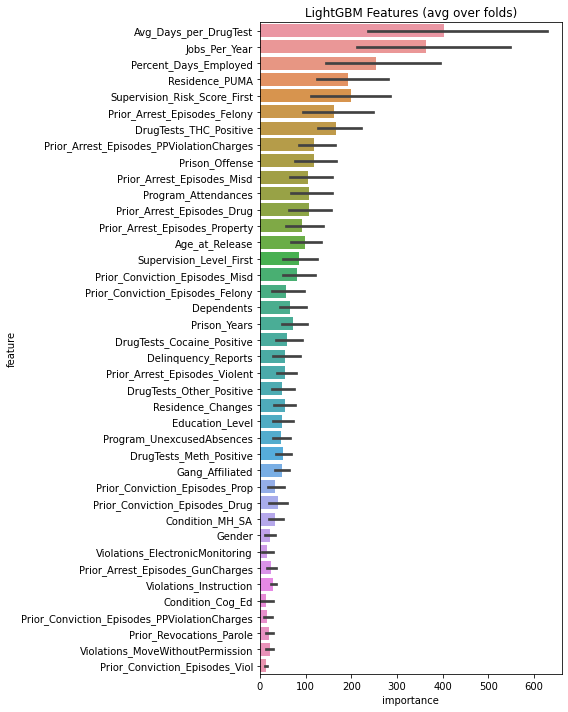

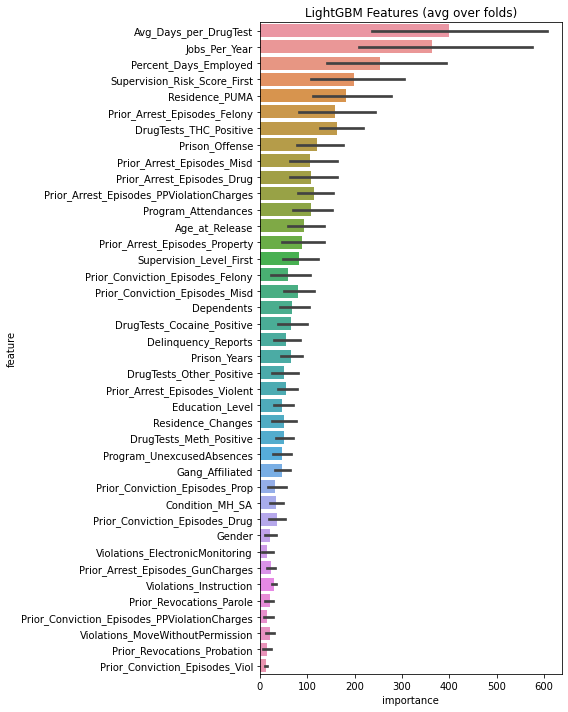

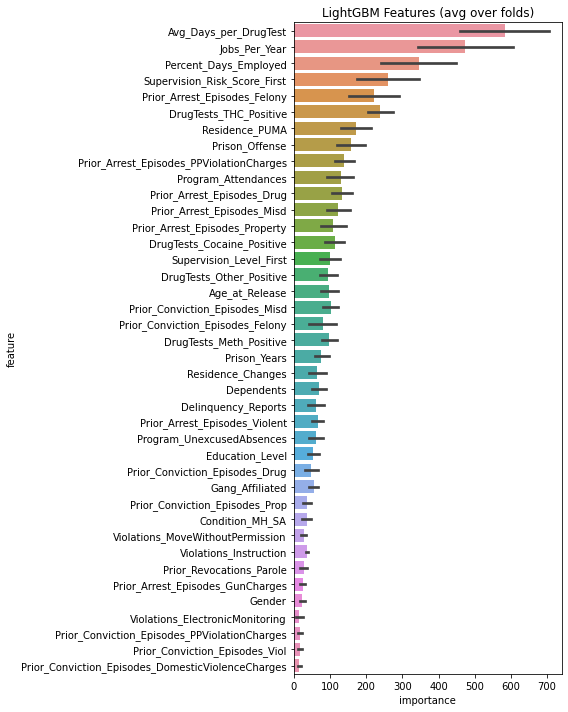

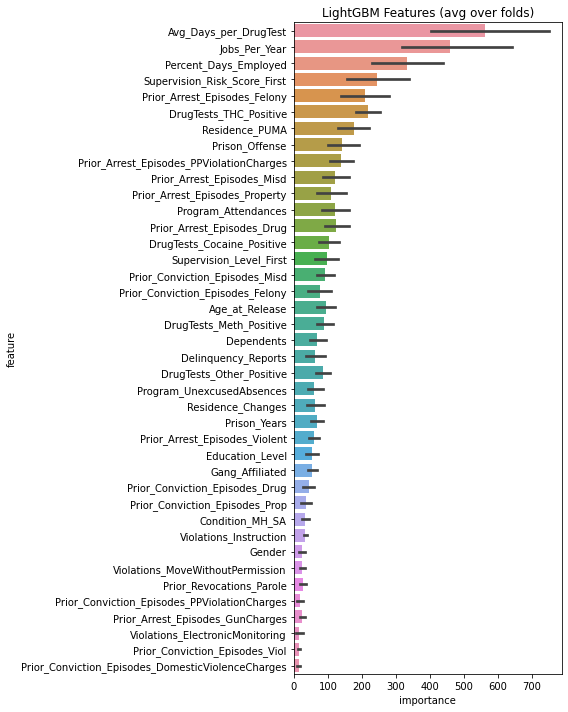

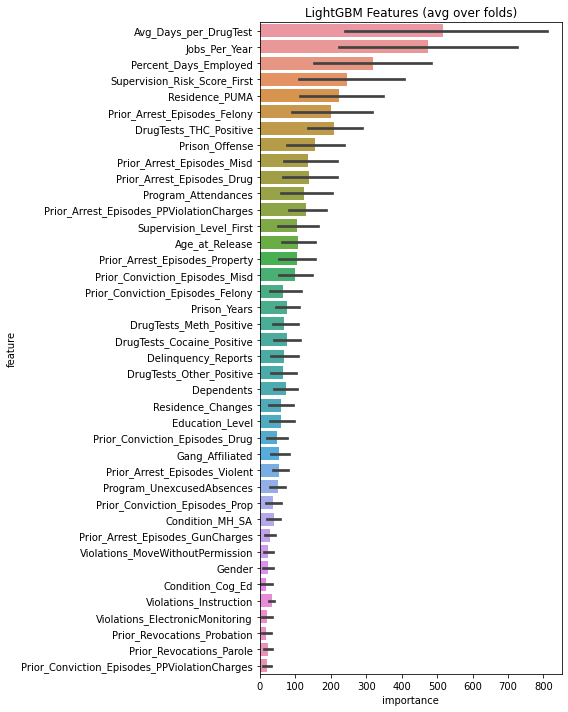

In [48]:
pred_5, oof_preds_5 = kfold_lightgbm(train, 5, top_5_params)
pred_4, oof_preds_4 = kfold_lightgbm(train, 5, top_4_params)
pred_3, oof_preds_3 = kfold_lightgbm(train, 5, top_3_params)
pred_2, oof_preds_2 = kfold_lightgbm(train, 5, top_2_params)
pred_1, oof_preds_1 = kfold_lightgbm(train, 5, top_1_params)

In [49]:
lbm_train = pd.DataFrame(data={
    "lbm_1": oof_preds_1.tolist(),
    "lbm_2": oof_preds_2.tolist(),
    "lbm_3": oof_preds_3.tolist(),
    "lbm_4": oof_preds_4.tolist(),
    "lbm_5": oof_preds_5.tolist(),
})
lbm_test = pd.DataFrame(data={
    "lbm_1": pred_1.tolist(),
    "lbm_2": pred_2.tolist(),
    "lbm_3": pred_3.tolist(),
    "lbm_4": pred_4.tolist(),
    "lbm_5": pred_5.tolist(),
})

In [50]:
lbm_train.to_csv('lbm_train.csv', index = False)
lbm_test.to_csv('lbm_test.csv', index = False)